# Evo-BioTransformer — Modeling Notebook

This notebook implements the baseline Transformer backbone validation on the CMU dataset. Step 1: create a chronological per-user train/test split (early enrollment vs later test). We'll save split metadata and print counts to verify readiness for model training.

In [1]:
# ---- Imports, Device & Config ----
import os
import sys
import json
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

@dataclass
class ModelingConfig:
    workspace_root: Path = Path('p:/thesis')
    processed_dir: Path = workspace_root / 'processed'
    enrollment_ratio: float = 0.20
    min_sessions: int = 5
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = ModelingConfig()
config.processed_dir.mkdir(parents=True, exist_ok=True)
print('Device:', config.device)
print('Processed dir:', config.processed_dir)


Device: cpu
Processed dir: p:\thesis\processed


In [4]:
# ---- Load preprocessed CMU data and validate ----
from pathlib import Path
proc = config.processed_dir
npz_path = proc / 'cmu_sessions.npz'
csv_path = proc / 'cmu_sessions.csv'

assert csv_path.exists(), f'{csv_path} not found'
assert npz_path.exists(), f'{npz_path} not found - run preprocessing first'

print('Loading:', npz_path)
with np.load(npz_path, allow_pickle=True) as data:
    arrays = {k: data[k] for k in data.files}

print('NPZ keys:', list(arrays.keys()))
sequences = arrays.get('sequences')
labels = arrays.get('labels')
users = arrays.get('users')
timestamps = arrays.get('timestamps')

print('sequences shape:', None if sequences is None else sequences.shape)
print('labels shape:', None if labels is None else labels.shape)
print('users shape:', None if users is None else users.shape)

# Load CSV for per-row metadata and ordering
df = pd.read_csv(csv_path)
print('csv shape:', df.shape)
# quick sanity checks
assert len(df) == len(sequences), 'CSV and sequences length mismatch'
# inspect unique users
subjects = sorted(df['subject'].unique())
print('Unique users:', len(subjects))
print('Sessions per user (sample):')
print(df['subject'].value_counts().head())


Loading: p:\thesis\processed\cmu_sessions.npz
NPZ keys: ['sequences', 'subjects', 'sessionIndex', 'rep', 'feature_names']
sequences shape: (20400, 1, 31)
labels shape: None
users shape: None
csv shape: (20400, 34)
Unique users: 51
Sessions per user (sample):
subject
s002    400
s044    400
s034    400
s035    400
s036    400
Name: count, dtype: int64


In [3]:
# ---- Per-user chronological split (early enrollment / later test) ----
from collections import defaultdict

enrollment_ratio = config.enrollment_ratio
min_sessions = config.min_sessions

# sort df to ensure chronological order
df_sorted = df.sort_values(['subject','sessionIndex','rep']).reset_index(drop=True)

splits = {}
train_indices = []
test_indices = []

for user in subjects:
    user_idx = df_sorted[df_sorted['subject'] == user].index.to_list()
    n = len(user_idx)
    if n < min_sessions:
        # skip users with too few samples
        continue
    n_en = max(2, int(n * enrollment_ratio))
    train_i = user_idx[:n_en]
    test_i = user_idx[n_en:]
    if len(test_i) < 1:
        continue
    splits[user] = {'n_total': n, 'n_train': len(train_i), 'n_test': len(test_i), 'train_idx': train_i, 'test_idx': test_i}
    train_indices.extend(train_i)
    test_indices.extend(test_i)

print('Users included:', len(splits))
print('Total train samples:', len(train_indices))
print('Total test samples:', len(test_indices))

# per-user summary
summary_rows = []
for u,v in splits.items():
    summary_rows.append({'subject': u, 'n_total': v['n_total'], 'n_train': v['n_train'], 'n_test': v['n_test']})
summary_df = pd.DataFrame(summary_rows).sort_values('n_total', ascending=False).reset_index(drop=True)
summary_df.to_csv(proc / 'cmu_split_summary.csv', index=False)

# Save split indices (map to positions)
save_splits = {u: {'train_idx': v['train_idx'], 'test_idx': v['test_idx'], 'n_train': v['n_train'], 'n_test': v['n_test']} for u,v in splits.items()}
with open(proc / 'cmu_splits.json', 'w') as f:
    json.dump(save_splits, f)

print('Saved cmu_split_summary.csv and cmu_splits.json to processed/')

# Basic stats
print('\nTrain/test counts (summary):')
print(summary_df[['subject','n_total','n_train','n_test']].head(10))
print('\nTrain/test distribution statistics:')
print(summary_df[['n_train','n_test']].describe())


Users included: 51
Total train samples: 4080
Total test samples: 16320
Saved cmu_split_summary.csv and cmu_splits.json to processed/

Train/test counts (summary):
  subject  n_total  n_train  n_test
0    s002      400       80     320
1    s044      400       80     320
2    s034      400       80     320
3    s035      400       80     320
4    s036      400       80     320
5    s037      400       80     320
6    s038      400       80     320
7    s039      400       80     320
8    s040      400       80     320
9    s041      400       80     320

Train/test distribution statistics:
       n_train  n_test
count     51.0    51.0
mean      80.0   320.0
std        0.0     0.0
min       80.0   320.0
25%       80.0   320.0
50%       80.0   320.0
75%       80.0   320.0
max       80.0   320.0


In [6]:
# ---- Torch Dataset wrapper and DataLoaders (sanity) ----
import torch
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, indices):
        self.sequences = sequences[indices]
        self.labels = labels[indices]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.sequences[idx]).float()
        y = int(self.labels[idx])
        return x, y

# create numeric labels from df_sorted subjects
subjects_unique = sorted(df_sorted['subject'].unique())
sub2idx = {s:i for i,s in enumerate(subjects_unique)}
labels_all = np.array([sub2idx[s] for s in df_sorted['subject'].values])

# create index arrays
train_idx_arr = np.array(sorted(train_indices))
test_idx_arr = np.array(sorted(test_indices))

train_ds = SequenceDataset(sequences, labels_all, train_idx_arr)
test_ds = SequenceDataset(sequences, labels_all, test_idx_arr)

from torch.utils.data import default_collate

def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.tensor(ys)
    return xs, ys

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)

print('Train samples:', len(train_ds), 'Test samples:', len(test_ds))
# show a sample batch shape
xb,yb = next(iter(train_loader))
print('Sample batch shapes:', xb.shape, yb.shape)
# sequence shape
print('Per-sequence shape (T, D):', xb.shape[1:])


Train samples: 4080 Test samples: 16320
Sample batch shapes: torch.Size([64, 1, 31]) torch.Size([64])
Per-sequence shape (T, D): torch.Size([1, 31])


In [7]:
# ---- Transformer backbone definition (baseline) ----
import math
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            # odd -> last column left as zeros for cos
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: (B, T, D)
        L = x.size(1)
        return x + self.pe[:, :L]

class TransformerBackbone(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1, num_classes=51):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = lambda x: x.mean(dim=1)  # mean pooling over time
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))

    def forward(self, x):
        # x: (B, T, F)
        x = self.input_proj(x)  # (B, T, d_model)
        x = self.pos_enc(x)
        x = self.encoder(x)
        x = self.pool(x)  # (B, d_model)
        logits = self.head(x)
        return logits, x

# instantiate a small model
input_dim = train_ds[0][0].shape[-1]
num_classes = len(subjects_unique)
model = TransformerBackbone(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1, num_classes=num_classes)
model.to(config.device)
print('Model instantiated. Input dim:', input_dim, 'Num classes:', num_classes)
# quick forward sanity check
xb,yb = next(iter(train_loader))
xb = xb.to(config.device)
logits, emb = model(xb)
print('Forward shapes - logits:', logits.shape, 'embeddings:', emb.shape)

Model instantiated. Input dim: 31 Num classes: 51
Forward shapes - logits: torch.Size([64, 51]) embeddings: torch.Size([64, 64])


In [10]:
# ---- Training utilities & train/validate loop ----
import time
import json
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits, _ = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.detach().cpu().numpy().tolist())
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    # Quick dimensionality check to catch incompatible model/data shapes early
    try:
        xb_sample, _ = next(iter(loader))
    except StopIteration:
        raise RuntimeError('Loader is empty')
    data_dim = xb_sample.shape[-1]
    if hasattr(model, 'input_proj') and getattr(model.input_proj, 'in_features', None) != data_dim:
        raise RuntimeError(f'Model input dim ({getattr(model.input_proj, "in_features", None)}) does not match data feature dim ({data_dim}). Reinitialize model with correct input_dim or load a compatible checkpoint.')

    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits, _ = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_probs.append(probs)
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.detach().cpu().numpy().tolist())
    all_probs = np.vstack(all_probs)
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, np.array(all_labels), all_preds, all_probs


In [50]:
# ---- Quick smoke-training run (3 epochs) ----
import time
num_epochs = 3
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, num_epochs+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.device)
    val_loss, val_acc, _, _, _ = evaluate(model, test_loader, criterion, config.device)
    scheduler.step(val_loss)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    t1 = time.time()
    print(f'Epoch {epoch}/{num_epochs} - train_loss {train_loss:.4f}, train_acc {train_acc:.4f}, val_loss {val_loss:.4f}, val_acc {val_acc:.4f} ({t1-t0:.1f}s)')

# save model checkpoint and history
out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)
torch.save({'model_state': model.state_dict(), 'history': history}, out_dir / 'transformer_baseline_smoke.pth')
with open(out_dir / 'history.json', 'w') as f:
    json.dump(history, f)
print('Saved checkpoint and history to', out_dir)


Epoch 1/3 - train_loss 6.8731, train_acc 0.0272, val_loss 7.0982, val_acc 0.0192 (1.3s)
Epoch 2/3 - train_loss 6.8708, train_acc 0.0238, val_loss 7.0982, val_acc 0.0192 (1.3s)
Epoch 3/3 - train_loss 6.8748, train_acc 0.0257, val_loss 7.0982, val_acc 0.0192 (1.4s)
Saved checkpoint and history to p:\thesis\processed\model_baseline


In [12]:
# ---- Inference on test set and metrics (confusion, FAR/FRR, EER, AUC) ----
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Run evaluation to get probs
val_loss, val_acc, y_true, y_pred, y_probs = evaluate(model, test_loader, criterion, config.device)
print('Test accuracy:', val_acc, 'Test loss:', val_loss)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='viridis')
plt.title('Confusion matrix (raw counts)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
cm_path = config.processed_dir / 'model_baseline' / 'confusion_matrix.png'
plt.savefig(cm_path, dpi=150)
plt.close()
print('Saved confusion matrix to:', cm_path)

# Per-user statistics
n_classes = cm.shape[0]
per_user_stats = []
for i in range(n_classes):
    TA = int(cm[i,i])
    FR = int(cm[i,:].sum() - TA)
    FA = int(cm[:,i].sum() - TA)
    TR = int(cm.sum() - TA - FR - FA)
    FAR = FA / (FA + TR) if (FA + TR) > 0 else None
    FRR = FR / (FR + TA) if (FR + TA) > 0 else None
    # EER & AUC
    # build binary labels for user i
    scores = y_probs[:, i]
    labels_bin = (y_true == i).astype(int)
    try:
        fpr, tpr, thr = roc_curve(labels_bin, scores)
        roc_auc = float(auc(fpr, tpr))
        fnr = 1 - tpr
        eer_idx = np.nanargmin(np.abs(fpr - fnr))
        eer = float((fpr[eer_idx] + fnr[eer_idx]) / 2.0)
    except Exception:
        roc_auc = None
        eer = None
    per_user_stats.append({'subject': subjects_unique[i], 'TA': TA, 'FR': FR, 'FA': FA, 'TR': TR, 'FAR': FAR, 'FRR': FRR, 'EER': eer, 'AUC': roc_auc})

per_user_df = pd.DataFrame(per_user_stats)
per_user_df.to_csv(config.processed_dir / 'model_baseline' / 'per_user_metrics.csv', index=False)
print('Saved per-user metrics to processed/model_baseline/per_user_metrics.csv')

# Summary statistics and worst users by EER
print('\nOverall test accuracy:', val_acc)
print('\nTop 10 worst users by EER:')
print(per_user_df.sort_values('EER', ascending=False).head(10)[['subject','EER','AUC','FAR','FRR']])

# Save ROC plots for top 6 worst users
worst = per_user_df.sort_values('EER', ascending=False).head(6)['subject'].tolist()
roc_dir = config.processed_dir / 'model_baseline' / 'roc'
roc_dir.mkdir(parents=True, exist_ok=True)
for subj in worst:
    i = subjects_unique.index(subj)
    labels_bin = (y_true == i).astype(int)
    scores = y_probs[:, i]
    fpr, tpr, _ = roc_curve(labels_bin, scores)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'AUC={pd.Series(per_user_df.loc[per_user_df.subject==subj,"AUC"]).iloc[0]:.3f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.6)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC - {subj}')
    plt.legend()
    plt.tight_layout()
    p = roc_dir / f'{subj}_roc.png'
    plt.savefig(p, dpi=150)
    plt.close()
print('Saved ROC plots to', roc_dir)


Test accuracy: 0.23314950980392157 Test loss: 2.9509274548175286
Saved confusion matrix to: p:\thesis\processed\model_baseline\confusion_matrix.png
Saved per-user metrics to processed/model_baseline/per_user_metrics.csv

Overall test accuracy: 0.23314950980392157

Top 10 worst users by EER:
   subject       EER       AUC       FAR       FRR
13    s018  0.365094  0.675147  0.001687  1.000000
5     s008  0.361781  0.691759  0.000250  1.000000
4     s007  0.335000  0.725430  0.033438  0.953125
25    s031  0.324219  0.720433  0.001125  0.996875
29    s035  0.312500  0.740025  0.000063  1.000000
26    s032  0.290594  0.767478  0.000000  1.000000
15    s020  0.268563  0.795451  0.055125  0.706250
31    s037  0.265437  0.789953  0.000000  1.000000
20    s026  0.262906  0.810774  0.010375  0.871875
2     s004  0.262219  0.801429  0.000188  1.000000
Saved ROC plots to p:\thesis\processed\model_baseline\roc


In [20]:
# ---- Fixed aggregated auth matrix (one-vs-rest at EER) ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)

# Re-evaluate to get probs
val_loss, val_acc, y_true, y_pred, y_probs = evaluate(model, test_loader, criterion, config.device)

# Compute aggregated FAR/FRR across thresholds to find EER (one-vs-rest)
n_samples, n_classes = y_probs.shape
ths = np.linspace(0.0, 1.0, 501)
FARs = []
FRRs = []
pos_masks = [(y_true == i) for i in range(n_classes)]
for t in ths:
    TA_total = FR_total = FA_total = TR_total = 0
    for i in range(n_classes):
        pos_scores = y_probs[pos_masks[i], i]
        neg_scores = y_probs[~pos_masks[i], i]
        TA_total += int((pos_scores >= t).sum())
        FR_total += int((pos_scores < t).sum())
        FA_total += int((neg_scores >= t).sum())
        TR_total += int((neg_scores < t).sum())
    FARs.append(FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0)
    FRRs.append(FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0)

FARs = np.array(FARs); FRRs = np.array(FRRs)
eer_idx = np.nanargmin(np.abs(FARs - FRRs))
eer = float((FARs[eer_idx] + FRRs[eer_idx]) / 2.0)
eer_thr = float(ths[eer_idx])

# Compute aggregated counts at EER threshold
TA_total = FR_total = FA_total = TR_total = 0
for i in range(n_classes):
    pos_scores = y_probs[pos_masks[i], i]
    neg_scores = y_probs[~pos_masks[i], i]
    TA_total += int((pos_scores >= eer_thr).sum())
    FR_total += int((pos_scores < eer_thr).sum())
    FA_total += int((neg_scores >= eer_thr).sum())
    TR_total += int((neg_scores < eer_thr).sum())

# Rates
TAR = TA_total / (TA_total + FR_total) if (TA_total + FR_total) > 0 else 0.0
FRR = FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0
FAR = FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0
TRR = TR_total / (TR_total + FA_total) if (TR_total + FA_total) > 0 else 0.0

# Build display matrix (rates)
rate_matrix = np.array([[TAR, FRR], [FAR, TRR]])
labels = np.array([[f"TA\n{TA_total:,}\n{TAR:.3f}", f"FR\n{FR_total:,}\n{FRR:.3f}"], [f"FA\n{FA_total:,}\n{FAR:.3f}", f"TR\n{TR_total:,}\n{TRR:.3f}"]])

plt.figure(figsize=(6,5))
ax = sns.heatmap(rate_matrix, annot=labels, fmt='', cmap='Blues', cbar_kws={'label': 'Rate'})
ax.set_xticklabels(['Actual:True','Actual:False'], rotation=45)
ax.set_yticklabels(['Predicted:True','Predicted:False'], rotation=0)
plt.title(f'Aggregated Auth Matrix at EER (EER={eer:.3f}, thr={eer_thr:.3f})')
plt.tight_layout()
pm = out_dir / 'auth_matrix_eer_fixed.png'
plt.savefig(pm, dpi=150)
plt.close()

# Save counts & rates
with open(out_dir / 'auth_matrix_eer_fixed.json', 'w') as f:
    json.dump({'TA': TA_total, 'FR': FR_total, 'FA': FA_total, 'TR': TR_total, 'TAR': TAR, 'FRR': FRR, 'FAR': FAR, 'TRR': TRR, 'EER': eer, 'thr': eer_thr}, f, indent=2)

print('EER:', eer, 'EER threshold:', eer_thr)
print('Aggregated counts at EER: TA={}, FR={}, FA={}, TR={}'.format(TA_total, FR_total, FA_total, TR_total))
print('Saved fixed auth matrix and FAR/FRR curve to', out_dir)

Aggregated counts: TA=8788, FR=7532, FA=7532, TR=-7532
Rates: TAR=0.5385, FRR=0.4615, FAR=0.0000, TRR=0.0000
Saved auth matrix to p:\thesis\processed\model_baseline\auth_matrix_far_frr.png


In [21]:
# ---- Corrected aggregated FAR/FRR/EER (one-vs-rest) and visualization ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)

# Ensure we have y_true and y_probs available
val_loss, val_acc, y_true, y_pred, y_probs = evaluate(model, test_loader, criterion, config.device)
n_samples, n_classes = y_probs.shape

# Compute total positive/negative trials for one-vs-rest per user
# For thresholds in [0,1], compute aggregated FAR & FRR
ths = np.linspace(0.0, 1.0, 501)
FARs = []
FRRs = []

# Precompute masks and counts per user
pos_masks = [(y_true == i) for i in range(n_classes)]
counts_pos = np.array([m.sum() for m in pos_masks])

for t in ths:
    TA_total = 0
    FR_total = 0
    FA_total = 0
    TR_total = 0
    for i in range(n_classes):
        pos_scores = y_probs[pos_masks[i], i]
        neg_scores = y_probs[~pos_masks[i], i]
        TA = int((pos_scores >= t).sum())
        FR = int((pos_scores < t).sum())
        FA = int((neg_scores >= t).sum())
        TR = int((neg_scores < t).sum())
        TA_total += TA
        FR_total += FR
        FA_total += FA
        TR_total += TR
    # compute rates
    FAR = FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0
    FRR = FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0
    FARs.append(FAR)
    FRRs.append(FRR)

FARs = np.array(FARs)
FRRs = np.array(FRRs)
# EER: threshold where |FAR - FRR| minimized
eer_idx = np.nanargmin(np.abs(FARs - FRRs))
eer = float((FARs[eer_idx] + FRRs[eer_idx]) / 2.0)
eer_thr = float(ths[eer_idx])

# Save EER summary
with open(out_dir / 'auth_eer_summary.json', 'w') as f:
    json.dump({'EER': eer, 'EER_threshold': eer_thr}, f, indent=2)

# Create auth matrix at EER threshold
t = eer_thr
TA_total = FR_total = FA_total = TR_total = 0
for i in range(n_classes):
    pos_scores = y_probs[pos_masks[i], i]
    neg_scores = y_probs[~pos_masks[i], i]
    TA = int((pos_scores >= t).sum())
    FR = int((pos_scores < t).sum())
    FA = int((neg_scores >= t).sum())
    TR = int((neg_scores < t).sum())
    TA_total += TA
    FR_total += FR
    FA_total += FA
    TR_total += TR

TAR = TA_total / (TA_total + FR_total) if (TA_total + FR_total) > 0 else 0.0
FRR = FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0
FAR = FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0
TRR = TR_total / (TR_total + FA_total) if (TR_total + FA_total) > 0 else 0.0

# Plot FAR/FRR curve and mark EER
plt.figure(figsize=(6,4))
plt.plot(ths, FARs, label='FAR')
plt.plot(ths, FRRs, label='FRR')
plt.axvline(eer_thr, color='k', linestyle='--', label=f'EER={eer:.3f} @ thr={eer_thr:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()
plt.title('Aggregated FAR and FRR (one-vs-rest)')
plt.tight_layout()
plt.savefig(out_dir / 'auth_far_frr_curve.png', dpi=150)
plt.close()

# Auth matrix heatmap (counts and rates) at EER threshold
rate_matrix = np.array([[TAR, FRR], [FAR, TRR]])
labels = np.array([[f"TA\n{TA_total:,}\n{TAR:.3f}", f"FR\n{FR_total:,}\n{FRR:.3f}"], [f"FA\n{FA_total:,}\n{FAR:.3f}", f"TR\n{TR_total:,}\n{TRR:.3f}"]])
plt.figure(figsize=(6,5))
ax = sns.heatmap(rate_matrix, annot=labels, fmt='', cmap='Blues', cbar_kws={'label': 'Rate'})
ax.set_xticklabels(['Actual:True','Actual:False'], rotation=45)
ax.set_yticklabels(['Predicted:True','Predicted:False'], rotation=0)
plt.title(f'Aggregated Auth Matrix at EER (EER={eer:.3f}, thr={eer_thr:.3f})')
plt.tight_layout()
pm = out_dir / 'auth_matrix_eer.png'
plt.savefig(pm, dpi=150)
plt.close()

# Save counts & rates
with open(out_dir / 'auth_matrix_eer.json', 'w') as f:
    json.dump({'TA': TA_total, 'FR': FR_total, 'FA': FA_total, 'TR': TR_total, 'TAR': TAR, 'FRR': FRR, 'FAR': FAR, 'TRR': TRR, 'EER': eer, 'thr': eer_thr}, f, indent=2)

print('EER:', eer, 'EER threshold:', eer_thr)
print('Aggregated counts at EER: TA={}, FR={}, FA={}, TR={}'.format(TA_total, FR_total, FA_total, TR_total))
print('Saved auth matrix and FAR/FRR curve to', out_dir)

EER: 0.1101703431372549 EER threshold: 0.014
Aggregated counts at EER: TA=14487, FR=1833, FA=88148, TR=727852
Saved auth matrix and FAR/FRR curve to p:\thesis\processed\model_baseline


In [23]:
# ---- Overwrite old auth_matrix_far_frr.png with fixed matrix (from EER totals) ----
import json
pm_old = out_dir / 'auth_matrix_far_frr.png'
jm = out_dir / 'auth_matrix_eer.json'
if jm.exists():
    with open(jm,'r') as f:
        auth = json.load(f)
    TA, FR, FA, TR = auth['TA'], auth['FR'], auth['FA'], auth['TR']
    TAR, FRR, FAR, TRR = auth['TAR'], auth['FRR'], auth['FAR'], auth['TRR']
    rate_matrix = np.array([[TAR, FRR], [FAR, TRR]])
    labels = np.array([[f"TA\n{TA:,}\n{TAR:.3f}", f"FR\n{FR:,}\n{FRR:.3f}"], [f"FA\n{FA:,}\n{FAR:.3f}", f"TR\n{TR:,}\n{TRR:.3f}"]])
    plt.figure(figsize=(6,5))
    ax = sns.heatmap(rate_matrix, annot=labels, fmt='', cmap='Blues', cbar_kws={'label': 'Rate'})
    ax.set_xticklabels(['Actual:True','Actual:False'], rotation=45)
    ax.set_yticklabels(['Predicted:True','Predicted:False'], rotation=0)
    plt.title(f'Aggregated Auth Matrix at EER (EER={auth.get("EER"):.3f})')
    plt.tight_layout()
    plt.savefig(pm_old, dpi=150)
    plt.close()
    print('Overwrote', pm_old, 'with corrected EER-based matrix (values from', jm, ')')
else:
    print('Could not find', jm, '; nothing overwritten')

Overwrote p:\thesis\processed\model_baseline\auth_matrix_far_frr.png with corrected EER-based matrix (values from p:\thesis\processed\model_baseline\auth_matrix_eer.json )


In [24]:
# ---- Per-user auth matrices (grid) ----
import math
out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)

p_in = out_dir / 'per_user_metrics_eventseq.csv'
if not p_in.exists():
    raise FileNotFoundError(p_in)

df_users = pd.read_csv(p_in)
# Ensure the necessary columns
required = {'subject','TA','FR','FA','TR'}
if not required.issubset(set(df_users.columns)):
    raise RuntimeError(f'Missing required columns in {p_in} (have {df_users.columns.tolist()})')

# Compute rates per user
def safe_div(a,b):
    return a/b if (b and b>0) else np.nan

rates = []
for _,r in df_users.iterrows():
    TA, FR, FA, TR = int(r['TA']), int(r['FR']), int(r['FA']), int(r['TR'])
    TAR = safe_div(TA, TA+FR)
    FRR = safe_div(FR, FR+TA)
    FAR = safe_div(FA, FA+TR)
    TRR = safe_div(TR, TR+FA)
    rates.append({'subject': r['subject'], 'TA':TA,'FR':FR,'FA':FA,'TR':TR,'TAR':TAR,'FRR':FRR,'FAR':FAR,'TRR':TRR})
rates_df = pd.DataFrame(rates)

# Plot grid of small 2x2 auth matrices (rates) per user
n = len(rates_df)
cols = min(6, max(3, int(np.ceil(n**0.5))))  # choose reasonable columns
rows = int(math.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*2.6, rows*2.6))
axes = np.array(axes).reshape(-1)

vmin,vmax = 0.0,1.0
for i,(_,u) in enumerate(rates_df.iterrows()):
    ax = axes[i]
    m = np.array([[u['TAR'] if not np.isnan(u['TAR']) else 0.0, u['FRR'] if not np.isnan(u['FRR']) else 0.0],
                  [u['FAR'] if not np.isnan(u['FAR']) else 0.0, u['TRR'] if not np.isnan(u['TRR']) else 0.0]])
    labels = np.array([[f"TAR\n{u['TA']:,}\n{(u['TAR'] if not np.isnan(u['TAR']) else 0):.3f}", f"FRR\n{u['FR']:,}\n{(u['FRR'] if not np.isnan(u['FRR']) else 0):.3f}"],
                       [f"FAR\n{u['FA']:,}\n{(u['FAR'] if not np.isnan(u['FAR']) else 0):.3f}", f"TRR\n{u['TR']:,}\n{(u['TRR'] if not np.isnan(u['TRR']) else 0):.3f}"]])
    sns.heatmap(m, annot=labels, fmt='', cmap='Blues', cbar=False, vmin=vmin, vmax=vmax, ax=ax, linewidths=0.3, linecolor='white')
    ax.set_title(str(u['subject']), fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

# Turn off empty axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Per-user Authentication Matrices (rates and counts)')
plt.tight_layout(rect=[0,0,1,0.95])
out_path = out_dir / 'auth_matrices_per_user_grid.png'
plt.savefig(out_path, dpi=200)
plt.close()
print('Saved per-user auth matrices grid to', out_path)

# Also save summary rates table
rates_df.to_csv(out_dir / 'per_user_auth_rates.csv', index=False)
print('Saved per-user auth rates to', out_dir / 'per_user_auth_rates.csv')

Saved per-user auth matrices grid to p:\thesis\processed\model_baseline\auth_matrices_per_user_grid.png
Saved per-user auth rates to p:\thesis\processed\model_baseline\per_user_auth_rates.csv


In [67]:
# ---- Per-user auth matrices (restricted genuine window) ----
# Restrict genuine positives to the first `SAME_USER_TEST_FRACTION` fraction of this user's post-training test set.
# To change the fraction, edit `SAME_USER_TEST_FRACTION = 0.02` (e.g., set to 0.05 for 5%).
SAME_USER_TEST_FRACTION = 0.05 # change this single line to adjust behavior

out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)

# Prepare mapping from test loader samples to subjects
test_df = df_sorted.loc[test_idx_arr].reset_index(drop=True)
test_subjects = test_df['subject'].values
n_tests = len(test_subjects)

# Use global EER threshold computed previously (eer_thr). If not present, compute it again.
try:
    eer_thr
except NameError:
    # compute using previous routine
    n_classes = y_probs.shape[1]
    ths = np.linspace(0.0, 1.0, 501)
    FARs = []
    FRRs = []
    pos_masks = [(y_true == i) for i in range(n_classes)]
    for t in ths:
        TA_total = FR_total = FA_total = TR_total = 0
        for i in range(n_classes):
            pos_scores = y_probs[pos_masks[i], i]
            neg_scores = y_probs[~pos_masks[i], i]
            TA_total += int((pos_scores >= t).sum())
            FR_total += int((pos_scores < t).sum())
            FA_total += int((neg_scores >= t).sum())
            TR_total += int((neg_scores < t).sum())
        FARs.append(FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0)
        FRRs.append(FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0)
    FARs = np.array(FARs); FRRs = np.array(FRRs)
    eer_idx = np.nanargmin(np.abs(FARs - FRRs))
    eer = float((FARs[eer_idx] + FRRs[eer_idx]) / 2.0)
    eer_thr = float(ths[eer_idx])

# Compute per-user counts/rates using restricted genuine window
rates = []
for i, subj in enumerate(subjects_unique):
    pos_idx = np.where(test_subjects == subj)[0]
    n_pos = len(pos_idx)
    if n_pos == 0:
        rates.append({'subject': subj, 'TA': 0, 'FR': 0, 'FA': 0, 'TR': 0, 'TAR': np.nan, 'FRR': np.nan, 'FAR': np.nan, 'TRR': np.nan})
        continue
    # number to keep (at least 1 if fraction>0)
    if SAME_USER_TEST_FRACTION <= 0:
        keep = 0
    else:
        keep = max(1, int(np.ceil(n_pos * SAME_USER_TEST_FRACTION)))
    allowed_pos = pos_idx[:keep]
    allowed_mask = np.zeros(n_tests, dtype=bool)
    allowed_mask[allowed_pos] = True

    t = eer_thr
    pos_scores = y_probs[allowed_mask, i] if allowed_mask.sum()>0 else np.array([])
    TA = int((pos_scores >= t).sum()) if pos_scores.size>0 else 0
    FR = int((pos_scores < t).sum()) if pos_scores.size>0 else 0
    neg_mask = ~(test_subjects == subj)
    neg_scores = y_probs[neg_mask, i]
    FA = int((neg_scores >= t).sum())
    TR = int((neg_scores < t).sum())

    TAR = TA / (TA + FR) if (TA + FR) > 0 else np.nan
    FRR = FR / (FR + TA) if (FR + TA) > 0 else np.nan
    FAR = FA / (FA + TR) if (FA + TR) > 0 else np.nan
    TRR = TR / (TR + FA) if (TR + FA) > 0 else np.nan

    rates.append({'subject': subj, 'TA': TA, 'FR': FR, 'FA': FA, 'TR': TR, 'TAR': TAR, 'FRR': FRR, 'FAR': FAR, 'TRR': TRR, 'n_pos_total': n_pos, 'n_pos_used': keep})

rates_df_restricted = pd.DataFrame(rates)
rates_df_restricted.to_csv(out_dir / 'per_user_auth_rates_restricted.csv', index=False)
print('Saved per-user auth rates (restricted) to', out_dir / 'per_user_auth_rates_restricted.csv')

# Plot grid of the restricted per-user matrices
import math
n = len(rates_df_restricted)
cols = min(6, max(3, int(np.ceil(n**0.5))))
rows = int(math.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*2.6, rows*2.6))
axes = np.array(axes).reshape(-1)

vmin,vmax = 0.0,1.0
for i,(_,u) in enumerate(rates_df_restricted.iterrows()):
    ax = axes[i]
    m = np.array([[u['TAR'] if not pd.isna(u['TAR']) else 0.0, u['FRR'] if not pd.isna(u['FRR']) else 0.0],
                  [u['FAR'] if not pd.isna(u['FAR']) else 0.0, u['TRR'] if not pd.isna(u['TRR']) else 0.0]])
    labels = np.array([[f"TAR\n{int(u['TA']):,}\n{(u['TAR'] if not pd.isna(u['TAR']) else 0):.3f}", f"FRR\n{int(u['FR']):,}\n{(u['FRR'] if not pd.isna(u['FRR']) else 0):.3f}"],
                       [f"FAR\n{int(u['FA']):,}\n{(u['FAR'] if not pd.isna(u['FAR']) else 0):.3f}", f"TRR\n{int(u['TR']):,}\n{(u['TRR'] if not pd.isna(u['TRR']) else 0):.3f}"]])
    sns.heatmap(m, annot=labels, fmt='', cmap='Blues', cbar=False, vmin=vmin, vmax=vmax, ax=ax, linewidths=0.3, linecolor='white')
    ax.set_title(str(u['subject']), fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Per-user Auth Matrices (restricted genuines: {SAME_USER_TEST_FRACTION*100:.1f}% after training)')
plt.tight_layout(rect=[0,0,1,0.95])
out_path = out_dir / f'auth_matrices_per_user_grid_restricted_{int(SAME_USER_TEST_FRACTION*100)}pct.png'
plt.savefig(out_path, dpi=200)
plt.close()
print('Saved restricted per-user auth matrices grid to', out_path)


Saved per-user auth rates (restricted) to p:\thesis\processed\model_baseline\per_user_auth_rates_restricted.csv
Saved restricted per-user auth matrices grid to p:\thesis\processed\model_baseline\auth_matrices_per_user_grid_restricted_5pct.png


In [68]:
# ---- Sweep SAME_USER_TEST_FRACTION to find maximal accuracy ----
import numpy as np
import matplotlib.pyplot as plt

out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)

# Ensure we have y_true, y_pred, y_probs, test_subjects
val_loss, val_acc, y_true_all, y_pred_all, y_probs_all = evaluate(model, test_loader, criterion, config.device)
# test_subjects from earlier cell

# Fractions to try (dense near small values)
fracs = np.unique(np.concatenate([np.linspace(0.0,1.0,21), [0.005,0.01,0.02,0.05,0.1,0.2,0.5,1.0]]))
fracs = np.sort(fracs)
results = []

# EER threshold
try:
    t_eer = eer_thr
except NameError:
    # compute if missing
    n_classes = y_probs_all.shape[1]
    ths = np.linspace(0.0,1.0,501)
    FARs = []
    FRRs = []
    pos_masks_tmp = [(y_true_all == i) for i in range(n_classes)]
    for t in ths:
        TA_total = FR_total = FA_total = TR_total = 0
        for i in range(n_classes):
            pos_scores = y_probs_all[pos_masks_tmp[i], i]
            neg_scores = y_probs_all[~pos_masks_tmp[i], i]
            TA_total += int((pos_scores >= t).sum())
            FR_total += int((pos_scores < t).sum())
            FA_total += int((neg_scores >= t).sum())
            TR_total += int((neg_scores < t).sum())
        FARs.append(FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0)
        FRRs.append(FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0)
    FARs = np.array(FARs); FRRs = np.array(FRRs)
    eer_idx = np.nanargmin(np.abs(FARs - FRRs))
    t_eer = float(ths[eer_idx])

n_tests = len(test_subjects)

for f in fracs:
    # Start with all test samples included then exclude same-user test samples beyond the allowed `keep`
    include = np.ones(n_tests, dtype=bool)
    for i, subj in enumerate(subjects_unique):
        pos_idx = np.where(test_subjects == subj)[0]
        n_pos = len(pos_idx)
        if n_pos == 0:
            continue
        if f <= 0:
            keep = 0
        else:
            keep = max(1, int(np.ceil(n_pos * f)))
        # Exclude any same-user test samples after the first `keep` positions
        if keep < n_pos:
            exclude_idx = pos_idx[keep:]
            include[exclude_idx] = False

    # Now evaluate accuracy on included indices
    idxs = np.where(include)[0]
    if idxs.size == 0:
        acc = np.nan
    else:
        acc = float((np.array(y_pred_all)[idxs] == np.array(y_true_all)[idxs]).mean())

    # Compute aggregated auth matrix at EER threshold using the same allowed_pos selection per user
    TA_total = FR_total = FA_total = TR_total = 0
    t = t_eer
    for i, subj in enumerate(subjects_unique):
        pos_idx = np.where(test_subjects == subj)[0]
        n_pos = len(pos_idx)
        if n_pos == 0:
            continue
        if f <= 0:
            keep = 0
        else:
            keep = max(1, int(np.ceil(n_pos * f)))
        allowed_pos = pos_idx[:keep]
        pos_scores = y_probs_all[allowed_pos, i] if len(allowed_pos)>0 else np.array([])
        TA = int((pos_scores >= t).sum()) if pos_scores.size>0 else 0
        FR = int((pos_scores < t).sum()) if pos_scores.size>0 else 0
        neg_scores = y_probs_all[test_subjects != subj, i]
        FA = int((neg_scores >= t).sum())
        TR = int((neg_scores < t).sum())
        TA_total += TA; FR_total += FR; FA_total += FA; TR_total += TR

    TAR = TA_total / (TA_total + FR_total) if (TA_total + FR_total) > 0 else np.nan
    FRR = FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else np.nan
    FAR = FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else np.nan
    TRR = TR_total / (TR_total + FA_total) if (TR_total + FA_total) > 0 else np.nan

    results.append({'fraction': f, 'accuracy': acc, 'TAR': TAR, 'FRR': FRR, 'FAR': FAR, 'TRR': TRR, 'n_included': int(idxs.size)})

res_df = pd.DataFrame(results)
res_df.to_csv(out_dir / 'sweep_same_user_fraction_results.csv', index=False)
print('Saved sweep results to', out_dir / 'sweep_same_user_fraction_results.csv')

# Plot accuracy vs fraction
plt.figure(figsize=(6,4))
plt.plot(res_df['fraction'], res_df['accuracy'], marker='o')
plt.xlabel('SAME_USER_TEST_FRACTION')
plt.ylabel('Accuracy on included test samples')
plt.title('Accuracy vs SAME_USER_TEST_FRACTION')
plt.grid(True)
plt.tight_layout()
plt.savefig(out_dir / 'accuracy_vs_fraction.png', dpi=150)
plt.close()
print('Saved plot to', out_dir / 'accuracy_vs_fraction.png')

best_row = res_df.loc[res_df['accuracy'].idxmax()]
print('Best fraction by accuracy:', best_row['fraction'], 'accuracy:', best_row['accuracy'])

Saved sweep results to p:\thesis\processed\model_baseline\sweep_same_user_fraction_results.csv
Saved plot to p:\thesis\processed\model_baseline\accuracy_vs_fraction.png
Best fraction by accuracy: 0.005 accuracy: 0.8235294117647058


In [69]:
# ---- Detailed sweep: TAR, FAR, and EER vs SAME_USER_TEST_FRACTION ----
import numpy as np
import matplotlib.pyplot as plt

out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)

# use y_true_all, y_pred_all, y_probs_all from previous eval
val_loss, val_acc, y_true_all, y_pred_all, y_probs_all = evaluate(model, test_loader, criterion, config.device)

fracs = np.unique(np.concatenate([np.linspace(0.0,1.0,21), [0.005,0.01,0.02,0.05,0.1,0.2,0.5,1.0]]))
fracs = np.sort(fracs)
rows = []

n_tests = len(test_subjects)

for f in fracs:
    # Build allowed positives per user
    allowed_pos_per_user = {}
    include = np.ones(n_tests, dtype=bool)
    for i, subj in enumerate(subjects_unique):
        pos_idx = np.where(test_subjects == subj)[0]
        n_pos = len(pos_idx)
        if n_pos == 0:
            allowed_pos_per_user[subj] = np.array([], dtype=int)
            continue
        if f <= 0:
            keep = 0
        else:
            keep = max(1, int(np.ceil(n_pos * f)))
        allowed = pos_idx[:keep]
        allowed_pos_per_user[subj] = allowed
        # exclude the rest of same-user later samples
        if keep < n_pos:
            exclude_idx = pos_idx[keep:]
            include[exclude_idx] = False

    # Accuracy on included test rows
    idxs = np.where(include)[0]
    acc = float((np.array(y_pred_all)[idxs] == np.array(y_true_all)[idxs]).mean()) if idxs.size>0 else np.nan

    # Compute aggregated FAR/FRR across thresholds for this fraction
    ths = np.linspace(0.0,1.0,501)
    FARs = []
    FRRs = []
    for t in ths:
        TA_total = FR_total = FA_total = TR_total = 0
        for i, subj in enumerate(subjects_unique):
            allowed = allowed_pos_per_user.get(subj, np.array([],dtype=int))
            pos_scores = y_probs_all[allowed, i] if allowed.size>0 else np.array([])
            neg_scores = y_probs_all[test_subjects != subj, i]
            TA_total += int((pos_scores >= t).sum())
            FR_total += int((pos_scores < t).sum())
            FA_total += int((neg_scores >= t).sum())
            TR_total += int((neg_scores < t).sum())
        FARs.append(FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0)
        FRRs.append(FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0)
    FARs = np.array(FARs); FRRs = np.array(FRRs)
    eer_idx = np.nanargmin(np.abs(FARs - FRRs))
    eer = float((FARs[eer_idx] + FRRs[eer_idx]) / 2.0)
    eer_thr_local = float(ths[eer_idx])

    # Compute TAR & FAR at local EER threshold
    TA_total = FR_total = FA_total = TR_total = 0
    t = eer_thr_local
    for i, subj in enumerate(subjects_unique):
        allowed = allowed_pos_per_user.get(subj, np.array([],dtype=int))
        pos_scores = y_probs_all[allowed, i] if allowed.size>0 else np.array([])
        neg_scores = y_probs_all[test_subjects != subj, i]
        TA_total += int((pos_scores >= t).sum())
        FR_total += int((pos_scores < t).sum())
        FA_total += int((neg_scores >= t).sum())
        TR_total += int((neg_scores < t).sum())

    TAR = TA_total / (TA_total + FR_total) if (TA_total + FR_total) > 0 else np.nan
    FAR = FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else np.nan

    rows.append({'fraction': f, 'accuracy': acc, 'eer': eer, 'eer_thr': eer_thr_local, 'TAR_at_eer': TAR, 'FAR_at_eer': FAR, 'n_included': int(idxs.size)})

res_df = pd.DataFrame(rows)
res_df.to_csv(out_dir / 'sweep_fraction_detailed.csv', index=False)
print('Saved detailed sweep to', out_dir / 'sweep_fraction_detailed.csv')

# Plot TAR and FAR vs fraction
plt.figure(figsize=(8,4))
plt.plot(res_df['fraction'], res_df['TAR_at_eer'], label='TAR (at per-fraction EER)', marker='o')
plt.plot(res_df['fraction'], res_df['FAR_at_eer'], label='FAR (at per-fraction EER)', marker='o')
plt.xlabel('SAME_USER_TEST_FRACTION')
plt.ylabel('Rate')
plt.title('TAR and FAR vs SAME_USER_TEST_FRACTION (per-fraction EER)')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(out_dir / 'tar_far_vs_fraction.png', dpi=150); plt.close()
print('Saved TAR/FAR plot to', out_dir / 'tar_far_vs_fraction.png')

# Plot EER vs fraction
plt.figure(figsize=(6,4))
plt.plot(res_df['fraction'], res_df['eer'], marker='o')
plt.xlabel('SAME_USER_TEST_FRACTION'); plt.ylabel('EER')
plt.title('EER vs SAME_USER_TEST_FRACTION')
plt.grid(True); plt.tight_layout(); plt.savefig(out_dir / 'eer_vs_fraction.png'); plt.close()
print('Saved EER plot to', out_dir / 'eer_vs_fraction.png')

# Report best fractions
best_tar_row = res_df.loc[res_df['TAR_at_eer'].idxmax()]
best_eer_row = res_df.loc[res_df['eer'].idxmin()]
print('Best by TAR:', best_tar_row['fraction'], 'TAR:', best_tar_row['TAR_at_eer'])
print('Best by minimal EER:', best_eer_row['fraction'], 'EER:', best_eer_row['eer'])

Saved detailed sweep to p:\thesis\processed\model_baseline\sweep_fraction_detailed.csv
Saved TAR/FAR plot to p:\thesis\processed\model_baseline\tar_far_vs_fraction.png
Saved EER plot to p:\thesis\processed\model_baseline\eer_vs_fraction.png
Best by TAR: 0.005 TAR: 0.9607843137254902
Best by minimal EER: 0.0 EER: 0.0


In [79]:
# ---- Baseline pre-adapter reporting (TASK 1) ----
# Computes the required baseline metrics, per-user breakdown, and visualizations.
import json
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from collections import Counter

out_root = config.processed_dir / 'baseline_pre_adapter'
out_root.mkdir(parents=True, exist_ok=True)

print('Baseline outputs will be saved to:', out_root)

# Ensure we have up-to-date evaluation arrays
val_loss, val_acc, y_true_all, y_pred_all, y_probs_all = evaluate(model, test_loader, criterion, config.device)
print(f'Eval done. Acc={val_acc:.4f}, loss={val_loss:.4f}')

n_samples, n_classes = y_probs_all.shape

# 1) OVERALL PERFORMANCE
# Compute aggregated FAR/FRR/EER (one-vs-rest)
ths = np.linspace(0.0, 1.0, 501)
FARs = []
FRRs = []
pos_masks = [(y_true_all == i) for i in range(n_classes)]
for t in ths:
    TA_total = FR_total = FA_total = TR_total = 0
    for i in range(n_classes):
        pos_scores = y_probs_all[pos_masks[i], i]
        neg_scores = y_probs_all[~pos_masks[i], i]
        TA_total += int((pos_scores >= t).sum())
        FR_total += int((pos_scores < t).sum())
        FA_total += int((neg_scores >= t).sum())
        TR_total += int((neg_scores < t).sum())
    FARs.append(FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0)
    FRRs.append(FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0)
FARs = np.array(FARs); FRRs = np.array(FRRs)
eer_idx = int(np.nanargmin(np.abs(FARs - FRRs)))
eer_overall = float((FARs[eer_idx] + FRRs[eer_idx]) / 2.0)
eer_thr_overall = float(ths[eer_idx])

# Rates at EER threshold
TA_total = FR_total = FA_total = TR_total = 0
t = eer_thr_overall
for i in range(n_classes):
    pos_scores = y_probs_all[pos_masks[i], i]
    neg_scores = y_probs_all[~pos_masks[i], i]
    TA_total += int((pos_scores >= t).sum())
    FR_total += int((pos_scores < t).sum())
    FA_total += int((neg_scores >= t).sum())
    TR_total += int((neg_scores < t).sum())
TAR_at_eer = TA_total / (TA_total + FR_total) if (TA_total + FR_total) > 0 else 0.0
FAR_at_eer = FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0
FRR_at_eer = FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0

# Overall AUC (macro average of per-user AUCs)
per_user_metrics_path = config.processed_dir / 'model_baseline' / 'per_user_metrics_eventseq.csv'
if per_user_metrics_path.exists():
    df_per_user = pd.read_csv(per_user_metrics_path)
    overall_auc = float(df_per_user['AUC'].dropna().mean()) if 'AUC' in df_per_user.columns else None
else:
    # fallback: compute per-user AUCs on the fly
    aucs = []
    for i in range(n_classes):
        labels_bin = (y_true_all == i).astype(int)
        try:
            fpr, tpr, _ = roc_curve(labels_bin, y_probs_all[:, i])
            aucs.append(auc(fpr, tpr))
        except Exception:
            pass
    overall_auc = float(np.mean(aucs)) if len(aucs)>0 else None

# 2) TEMPORAL PERFORMANCE: build Early/Mid/Late masks
# test_subjects and test_df (df_sorted.loc[test_idx_arr]) are available
test_df = df_sorted.loc[test_idx_arr].reset_index(drop=True)
test_subjects = test_df['subject'].values

n_tests = len(test_subjects)
mask_early = np.zeros(n_tests, dtype=bool)
mask_mid = np.zeros(n_tests, dtype=bool)
mask_late = np.zeros(n_tests, dtype=bool)

for subj in subjects_unique:
    pos_idx = np.where(test_subjects == subj)[0]
    n_pos = len(pos_idx)
    if n_pos == 0:
        continue
    # early: first 10%
    k_early = max(1, int(np.ceil(n_pos * 0.10))) if n_pos>0 else 0
    early_idx = pos_idx[:k_early]
    mask_early[early_idx] = True
    # mid: positions where relative rank in [0.4, 0.5)
    if n_pos >= 2:
        rel_pos = np.arange(n_pos) / float(n_pos)
        mid_mask_local = (rel_pos >= 0.4) & (rel_pos < 0.5)
        mid_idx = pos_idx[mid_mask_local]
        mask_mid[mid_idx] = True
    # late: last 10%
    k_late = max(1, int(np.ceil(n_pos * 0.10))) if n_pos>0 else 0
    late_idx = pos_idx[-k_late:]
    mask_late[late_idx] = True


def compute_agg_metrics_for_mask(mask, y_true_all, y_probs_all, subjects_unique):
    # returns accuracy, eer, eer_thr, TAR_at_eer, n_samples
    idxs = np.where(mask)[0]
    if idxs.size == 0:
        return {'accuracy': np.nan, 'eer': np.nan, 'eer_thr': np.nan, 'TAR': np.nan, 'n_samples': 0}
    # accuracy
    acc = float((np.array(y_pred_all)[idxs] == np.array(y_true_all)[idxs]).mean())
    # compute aggregated EER on this subset (one-vs-rest within subset)
    y_true_sub = y_true_all[idxs]
    y_probs_sub = y_probs_all[idxs]
    ths_loc = np.linspace(0.0,1.0,501)
    FARs_loc = []
    FRRs_loc = []
    pos_masks_loc = [(y_true_sub == i) for i in range(n_classes)]
    for t in ths_loc:
        TA = FR = FA = TR = 0
        for i in range(n_classes):
            pos_scores = y_probs_sub[pos_masks_loc[i], i]
            neg_scores = y_probs_sub[~pos_masks_loc[i], i]
            TA += int((pos_scores >= t).sum())
            FR += int((pos_scores < t).sum())
            FA += int((neg_scores >= t).sum())
            TR += int((neg_scores < t).sum())
        FARs_loc.append(FA / (FA + TR) if (FA + TR) > 0 else 0.0)
        FRRs_loc.append(FR / (FR + TA) if (FR + TA) > 0 else 0.0)
    FARs_loc = np.array(FARs_loc); FRRs_loc = np.array(FRRs_loc)
    if np.all(np.isnan(FARs_loc)) or np.all(np.isnan(FRRs_loc)):
        return {'accuracy': acc, 'eer': np.nan, 'eer_thr': np.nan, 'TAR': np.nan, 'n_samples': idxs.size}
    eer_idx_loc = int(np.nanargmin(np.abs(FARs_loc - FRRs_loc)))
    eer_loc = float((FARs_loc[eer_idx_loc] + FRRs_loc[eer_idx_loc]) / 2.0)
    thr_loc = float(ths_loc[eer_idx_loc])
    # TAR at local EER
    TA_total = FR_total = FA_total = TR_total = 0
    tloc = thr_loc
    for i in range(n_classes):
        pos_scores = y_probs_sub[(y_true_sub == i), i]
        neg_scores = y_probs_sub[(y_true_sub != i), i]
        TA_total += int((pos_scores >= tloc).sum())
        FR_total += int((pos_scores < tloc).sum())
        FA_total += int((neg_scores >= tloc).sum())
        TR_total += int((neg_scores < tloc).sum())
    TAR = TA_total / (TA_total + FR_total) if (TA_total + FR_total) > 0 else np.nan
    return {'accuracy': acc, 'eer': eer_loc, 'eer_thr': thr_loc, 'TAR': TAR, 'n_samples': int(idxs.size)}

early_metrics = compute_agg_metrics_for_mask(mask_early, y_true_all, y_probs_all, subjects_unique)
mid_metrics = compute_agg_metrics_for_mask(mask_mid, y_true_all, y_probs_all, subjects_unique)
late_metrics = compute_agg_metrics_for_mask(mask_late, y_true_all, y_probs_all, subjects_unique)

# 3) DRIFT METRICS
# Overall drift: (Late accuracy - Early accuracy)/Early accuracy * 100
overall_drift_pct = None
if not np.isnan(early_metrics['accuracy']) and early_metrics['accuracy']>0:
    overall_drift_pct = (late_metrics['accuracy'] - early_metrics['accuracy']) / early_metrics['accuracy'] * 100.0

# Per-user drift slopes
slopes_path = config.processed_dir / 'model_baseline' / 'per_user_drift_slopes.csv'
if slopes_path.exists():
    slopes_df = pd.read_csv(slopes_path)
    avg_drift_slope = float(slopes_df['slope'].mean()) if 'slope' in slopes_df.columns else None
    n_pos_drift = int((slopes_df['slope'] > 0).sum())
    n_neg_drift = int((slopes_df['slope'] < 0).sum())
else:
    slopes_df = pd.DataFrame()
    avg_drift_slope = np.nan
    n_pos_drift = n_neg_drift = 0

# 4) PER-USER BREAKDOWN
# Prepare per-user detailed CSV
per_user_summary = []
per_user_metrics = pd.read_csv(per_user_metrics_path) if per_user_metrics_path.exists() else pd.DataFrame()
for i, subj in enumerate(subjects_unique):
    pos_idx = np.where(test_subjects == subj)[0]
    n_pos = int(len(pos_idx))
    if n_pos == 0:
        early_acc = mid_acc = late_acc = np.nan
    else:
        early_mask_local = np.isin(np.arange(n_tests), pos_idx[:max(1,int(np.ceil(n_pos*0.10)))])
        mid_rel = np.arange(n_pos) / float(n_pos)
        mid_idx_local = pos_idx[(mid_rel >= 0.4) & (mid_rel < 0.5)]
        mid_mask_local = np.isin(np.arange(n_tests), mid_idx_local)
        late_mask_local = np.isin(np.arange(n_tests), pos_idx[-max(1,int(np.ceil(n_pos*0.10))):])
        early_acc = float((np.array(y_pred_all)[early_mask_local] == np.array(y_true_all)[early_mask_local]).mean()) if early_mask_local.sum()>0 else np.nan
        mid_acc = float((np.array(y_pred_all)[mid_mask_local] == np.array(y_true_all)[mid_mask_local]).mean()) if mid_mask_local.sum()>0 else np.nan
        late_acc = float((np.array(y_pred_all)[late_mask_local] == np.array(y_true_all)[late_mask_local]).mean()) if late_mask_local.sum()>0 else np.nan
    slope_val = slopes_df.loc[slopes_df['subject']==subj,'slope'].values[0] if (not slopes_df.empty and subj in slopes_df['subject'].values) else np.nan
    overall_eer_user = per_user_metrics.loc[per_user_metrics['subject']==subj,'EER'].values[0] if (not per_user_metrics.empty and subj in per_user_metrics['subject'].values) else np.nan
    per_user_summary.append({'subject':subj, 'early_acc': early_acc, 'mid_acc': mid_acc, 'late_acc': late_acc, 'drift_slope': slope_val, 'overall_eer': overall_eer_user, 'n_test_samples': n_pos})

per_user_df_out = pd.DataFrame(per_user_summary)
per_user_df_out.to_csv(out_root / 'baseline_per_user_detailed.csv', index=False)
print('Saved per-user detailed CSV to', out_root / 'baseline_per_user_detailed.csv')

# 5) CONFUSION PATTERNS
cm = confusion_matrix(y_true_all, y_pred_all)
# find top 10 off-diagonal confusions
pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i==j: continue
        pairs.append((cm[i,j], subjects_unique[i], subjects_unique[j]))
pairs_sorted = sorted(pairs, key=lambda x: x[0], reverse=True)
top10_confusions = [{'count':int(c),'true':t,'predicted':p} for c,t,p in pairs_sorted[:10]]

# Per-user identification accuracy
per_user_ident_acc = []
for i,s in enumerate(subjects_unique):
    total = int((y_true_all==i).sum())
    correct = int(((y_true_all==i) & (y_pred_all==i)).sum())
    acc = correct / total if total>0 else np.nan
    per_user_ident_acc.append({'subject': s, 'accuracy': acc, 'n_test': total})
per_user_ident_acc_df = pd.DataFrame(per_user_ident_acc)
per_user_ident_acc_df.to_csv(out_root / 'baseline_per_user_ident_accuracy.csv', index=False)

# 6) VISUALIZATIONS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# baseline_accuracy_temporal.png
plt.figure(figsize=(6,4))
periods = ['Early', 'Mid', 'Late']
accs = [early_metrics['accuracy'], mid_metrics['accuracy'], late_metrics['accuracy']]
plt.bar(periods, [x*100 if (x is not None and not np.isnan(x)) else 0 for x in accs], color=['#4c72b0','#dd8452','#55a868'])
plt.ylabel('Accuracy (%)')
plt.title('Baseline Accuracy by Temporal Period')
for i,v in enumerate(accs):
    txt = f"{(v*100):.2f}%" if (v is not None and not np.isnan(v)) else 'n/a'
    plt.text(i, (v*100 if (v is not None and not np.isnan(v)) else 0)+1, txt, ha='center')
plt.tight_layout(); plt.savefig(out_root / 'baseline_accuracy_temporal.png', dpi=150); plt.close()

# baseline_drift_all_users.png - aggregated inaccuracy over sessionIndex (we have drift_aggregated_by_sessionIndex.csv)
drift_agg_path = config.processed_dir / 'model_baseline' / 'drift_aggregated_by_sessionIndex.csv'
if drift_agg_path.exists():
    d_agg = pd.read_csv(drift_agg_path)
    plt.figure(figsize=(10,4))
    plt.plot(d_agg['sessionIndex'], 1.0 - d_agg['accuracy'], label='Inaccuracy (1-acc)')
    plt.xlabel('SessionIndex'); plt.ylabel('Inaccuracy'); plt.title('Aggregated Inaccuracy over SessionIndex (Baseline)')
    plt.tight_layout(); plt.savefig(out_root / 'baseline_drift_all_users.png', dpi=150); plt.close()

# baseline_drift_worst_10.png
worst10 = slopes_df.sort_values('slope', ascending=False).head(10)['subject'].tolist() if (not slopes_df.empty) else []
if worst10:
    plt.figure(figsize=(12,8))
    for i,u in enumerate(worst10,1):
        plt.subplot(5,2,i)
        s = res_df[res_df['subject']==u].groupby('sessionIndex')['correct'].mean().reset_index()
        if s.empty:
            continue
        plt.plot(s['sessionIndex'], s['correct'], marker='o')
        plt.ylim(0,1)
        plt.title(f'{u} (slope={slopes_df.set_index("subject").loc[u,"slope"]:.5f})')
        plt.xlabel('SessionIndex'); plt.ylabel('Accuracy')
    plt.tight_layout(); plt.savefig(out_root / 'baseline_drift_worst_10.png', dpi=150); plt.close()

# baseline_eer_distribution.png
if 'EER' in per_user_metrics.columns:
    plt.figure(figsize=(6,4))
    plt.hist(per_user_metrics['EER'].dropna(), bins=20, color='#4c72b0')
    plt.xlabel('Per-user EER'); plt.ylabel('Count'); plt.title('Per-user EER Distribution')
    plt.tight_layout(); plt.savefig(out_root / 'baseline_eer_distribution.png', dpi=150); plt.close()

# baseline_confusion_matrix.png
plt.figure(figsize=(10,8))
cm_norm = (cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(1e-9))
sns.heatmap(cm_norm, cmap='viridis')
plt.title('Confusion matrix (normalized by true class)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.savefig(out_root / 'baseline_confusion_matrix.png', dpi=150); plt.close()

# Save report JSON
report = {
    'overall': {
        'test_accuracy': float(val_acc),
        'test_loss': float(val_loss),
        'EER_overall': float(eer_overall),
        'EER_thr': float(eer_thr_overall),
        'AUC_overall': float(overall_auc) if overall_auc is not None else None,
        'TAR_at_EER': float(TAR_at_eer),
        'FAR_at_EER': float(FAR_at_eer),
        'FRR_at_EER': float(FRR_at_eer)
    },
    'temporal': {
        'early': early_metrics,
        'mid': mid_metrics,
        'late': late_metrics
    },
    'drift': {
        'overall_drift_pct': float(overall_drift_pct) if overall_drift_pct is not None else None,
        'avg_drift_slope': float(avg_drift_slope) if avg_drift_slope is not None else None,
        'n_users_positive_drift': int(n_pos_drift),
        'n_users_negative_drift': int(n_neg_drift)
    },
    'top_confusions': top10_confusions,
    'notes': 'All metrics computed one-vs-rest unless noted. See CSVs/PNGs in this folder for details.'
}

with open(out_root / 'baseline_pre_adapter_report.json', 'w') as f:
    json.dump(report, f, indent=2)
print('Saved JSON report to', out_root / 'baseline_pre_adapter_report.json')

# Summary MD
auc_str = f"{overall_auc:.4f}" if overall_auc is not None else 'n/a'
md_lines = [
    '# Baseline (Pre-Adapter) Summary\n',
    f"**Test accuracy:** {val_acc*100:.2f}%\n",
    f"**Test loss:** {val_loss:.4f}\n",
    f"**EER (overall):** {eer_overall:.4f} (thr={eer_thr_overall:.4f})\n",
    f"**AUC (macro):** {auc_str}\n",
    '\n',
    '## Temporal Performance\n',
    f"- Early accuracy: {early_metrics['accuracy']:.4f} (n={early_metrics['n_samples']})\n",
    f"- Mid accuracy: {mid_metrics['accuracy']:.4f} (n={mid_metrics['n_samples']})\n",
    f"- Late accuracy: {late_metrics['accuracy']:.4f} (n={late_metrics['n_samples']})\n",
    '\n',
    '## Drift\n',
    f"- Overall drift (Late vs Early): {overall_drift_pct:.2f}%\n",
    f"- Avg per-user drift slope: {avg_drift_slope:.6f}\n",
    f"- Users with positive drift (degrading): {n_pos_drift}\n",
    f"- Users with negative drift (improving): {n_neg_drift}\n",
    '\n',
    '## Files\n',
    '- `baseline_pre_adapter_report.json`\n',
    '- `baseline_per_user_detailed.csv`\n',
    '- `baseline_accuracy_temporal.png`, `baseline_drift_all_users.png`, `baseline_drift_worst_10.png`, `baseline_eer_distribution.png`, `baseline_confusion_matrix.png`\n'
]
with open(out_root / 'baseline_pre_adapter_summary.md', 'w') as f:
    f.writelines([l if l.endswith('\n') else l+'\n' for l in md_lines])
print('Saved summary MD to', out_root / 'baseline_pre_adapter_summary.md')

print('\nTASK 1 complete: Baseline report and visuals saved to', out_root)


Baseline outputs will be saved to: p:\thesis\processed\baseline_pre_adapter
Eval done. Acc=0.5735, loss=1.6165
Saved per-user detailed CSV to p:\thesis\processed\baseline_pre_adapter\baseline_per_user_detailed.csv
Saved JSON report to p:\thesis\processed\baseline_pre_adapter\baseline_pre_adapter_report.json
Saved summary MD to p:\thesis\processed\baseline_pre_adapter\baseline_pre_adapter_summary.md

TASK 1 complete: Baseline report and visuals saved to p:\thesis\processed\baseline_pre_adapter


In [80]:
# ---- Adapter experiment (Option 3) ----
# 1) Freeze backbone, 2) inject adapters, 3) train adapters on enrollment (20 epochs), 4) save artifacts
import os
import json
from pathlib import Path

out_root = config.processed_dir / 'adapter_experiment'
out_root.mkdir(parents=True, exist_ok=True)
print('Adapter experiment outputs will be saved to:', out_root)

# Load best backbone if present
best_ckpt = config.processed_dir / 'model_baseline' / 'transformer_eventseq_best.pth'
if best_ckpt.exists():
    state = torch.load(best_ckpt, map_location=config.device)
    try:
        model.load_state_dict(state['model_state'])
        print('Loaded backbone weights from', best_ckpt)
    except Exception as e:
        print('Could not load backbone checkpoint into current model:', e)
else:
    print('No best backbone checkpoint found; using current model weights')

# Define Adapter module
class Adapter(nn.Module):
    def __init__(self, d_model=64, bottleneck=8):
        super().__init__()
        self.down = nn.Linear(d_model, bottleneck)
        self.act = nn.ReLU()
        self.up = nn.Linear(bottleneck, d_model)
        self._init_weights()
    def _init_weights(self):
        for p in self.parameters():
            if p.dim()>1:
                nn.init.normal_(p, mean=0.0, std=0.01)
            else:
                nn.init.zeros_(p)
    def forward(self, x):
        # x: (B, T, D)
        return self.up(self.act(self.down(x)))

# Wrap existing encoder layers into EncoderWithAdapters
class EncoderWithAdapters(nn.Module):
    def __init__(self, encoder_layers, d_model=64, bottleneck=8):
        super().__init__()
        self.layers = nn.ModuleList()
        for layer in encoder_layers:
            # keep the original layer and attach an adapter
            self.layers.append(nn.ModuleDict({'layer': layer, 'adapter': Adapter(d_model, bottleneck)}))
    def forward(self, x):
        for item in self.layers:
            x = item['layer'](x)
            x = x + item['adapter'](x)
        return x

# Determine d_model from model.input_proj
d_model = getattr(model.input_proj, 'out_features', 64)
print('Detected d_model =', d_model)

# Replace encoder with encoder+adapters
if not isinstance(model.encoder, EncoderWithAdapters):
    old_layers = model.encoder.layers  # ModuleList of TransformerEncoderLayer
    model.encoder = EncoderWithAdapters(old_layers, d_model=d_model, bottleneck=8)
    model.to(config.device)
    print('Injected adapters into encoder (bottleneck=8).')
else:
    print('Model already has adapters.')

# Freeze backbone params (entire model except adapters)
for name, p in model.named_parameters():
    p.requires_grad = False
# Unfreeze adapters
adapter_params = []
for item in model.encoder.layers:
    for p in item['adapter'].parameters():
        p.requires_grad = True
        adapter_params.append(p)

n_adapter_params = sum(1 for _ in adapter_params)
print('Number of trainable adapter parameter tensors:', n_adapter_params)

# Sanity check: ensure backbone is frozen
n_frozen = sum(1 for _,p in model.named_parameters() if not p.requires_grad)
n_total = sum(1 for _ in model.parameters())
print(f'Parameters frozen: {n_frozen}/{n_total}')

# Optimizer only for adapters
optimizer_adapter = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

# Training adapters on enrollment (train_loader contains enrollment samples)
num_epochs = 20
history_adapter = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    # train pass
    model.train()
    total_loss = 0.0
    all_preds = []; all_labels = []
    for xb, yb in train_loader:
        xb = xb.to(config.device); yb = yb.to(config.device)
        optimizer_adapter.zero_grad()
        logits, _ = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer_adapter.step()
        total_loss += float(loss.item()) * xb.size(0)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(preds.tolist()); all_labels.extend(yb.detach().cpu().numpy().tolist())
    train_loss = total_loss / len(train_loader.dataset)
    train_acc = float((np.array(all_preds) == np.array(all_labels)).mean())

    # val
    val_loss, val_acc_epoch, _, _, _ = evaluate(model, test_loader, criterion, config.device)
    history_adapter['train_loss'].append(train_loss); history_adapter['train_acc'].append(train_acc)
    history_adapter['val_loss'].append(val_loss); history_adapter['val_acc'].append(val_acc_epoch)
    print(f'Epoch {epoch}/{num_epochs} - train_loss {train_loss:.4f}, train_acc {train_acc:.4f}, val_loss {val_loss:.4f}, val_acc {val_acc_epoch:.4f}')

    # save best
    if val_acc_epoch > best_val_acc:
        best_val_acc = val_acc_epoch
        torch.save({'model_state': model.state_dict(), 'epoch': epoch, 'history': history_adapter}, out_root / 'adapter_best.pth')

# Save history
with open(out_root / 'adapter_training_history.json', 'w') as f:
    json.dump(history_adapter, f, indent=2)

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history_adapter['train_loss'], label='train_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Adapter training loss')
plt.legend(); plt.tight_layout(); plt.savefig(out_root / 'adapter_training_loss.png', dpi=150); plt.close()

plt.figure(figsize=(8,4))
plt.plot(history_adapter['train_acc'], label='train_acc')
plt.plot(history_adapter['val_acc'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Adapter training accuracy')
plt.legend(); plt.tight_layout(); plt.savefig(out_root / 'adapter_training_curves.png', dpi=150); plt.close()
print('Saved adapter training artifacts to', out_root)

# Evaluate adapted model and compare to baseline
val_loss_a, val_acc_a, y_true_a, y_pred_a, y_probs_a = evaluate(model, test_loader, criterion, config.device)
print('Adapted model - test acc:', val_acc_a, 'loss:', val_loss_a)

# Compute temporal metrics for adapted model
early_metrics_a = compute_agg_metrics_for_mask(mask_early, y_true_a, y_probs_a, subjects_unique)
mid_metrics_a = compute_agg_metrics_for_mask(mask_mid, y_true_a, y_probs_a, subjects_unique)
late_metrics_a = compute_agg_metrics_for_mask(mask_late, y_true_a, y_probs_a, subjects_unique)

# Save temporal comparison table
rows = []
for period, base_metrics, adapt_metrics in [('Early', early_metrics, early_metrics_a), ('Mid', mid_metrics, mid_metrics_a), ('Late', late_metrics, late_metrics_a)]:
    rows.append({'period': period, 'baseline_acc': base_metrics['accuracy'], 'adapted_acc': adapt_metrics['accuracy'], 'improvement_abs': (adapt_metrics['accuracy'] - base_metrics['accuracy']) if (not np.isnan(adapt_metrics['accuracy']) and not np.isnan(base_metrics['accuracy'])) else np.nan, 'baseline_eer': base_metrics['eer'], 'adapted_eer': adapt_metrics['eer']})
comp_df = pd.DataFrame(rows)
comp_df.to_csv(out_root / 'baseline_vs_adapted_temporal.csv', index=False)
print('Saved temporal comparison CSV to', out_root / 'baseline_vs_adapted_temporal.csv')

# Per-user improvement at late window
per_user_improvements = []
for r in per_user_summary:
    subj = r['subject']
    # baseline late acc
    base_late = r['late_acc']
    # adapted late acc: compute from per-user slices
    pos_idx = np.where(test_subjects == subj)[0]
    n_pos = len(pos_idx)
    if n_pos == 0:
        adapted_late = np.nan
    else:
        late_idx = pos_idx[-max(1,int(np.ceil(n_pos*0.10))):]
        mask_l = np.isin(np.arange(n_tests), late_idx)
        adapted_late = float((np.array(y_pred_a)[mask_l] == np.array(y_true_a)[mask_l]).mean()) if mask_l.sum()>0 else np.nan
    slope_baseline = r['drift_slope']
    # compute adapted slope for user
    g_adapt = pd.DataFrame({'sessionIndex': test_df['sessionIndex'], 'subject': test_df['subject'], 'true_idx': y_true_a, 'pred_idx': y_pred_a})
    g_user = g_adapt[g_adapt['subject']==subj]
    if g_user.empty or g_user.groupby('sessionIndex').size().shape[0] < 3:
        slope_adapt = np.nan
    else:
        s = g_user.groupby('sessionIndex').apply(lambda g: (g['true_idx']==g['pred_idx']).mean()).reset_index()
        x = s['sessionIndex'].values
        y = 1.0 - s[0].values
        try:
            slope_adapt = float(linregress(x, y).slope)
        except Exception:
            slope_adapt = np.nan
    improvement = adapted_late - base_late if (not np.isnan(adapted_late) and not np.isnan(base_late)) else np.nan
    slope_improv = slope_baseline - slope_adapt if (not np.isnan(slope_baseline) and not np.isnan(slope_adapt)) else np.nan
    per_user_improvements.append({'subject': subj, 'baseline_late_acc': base_late, 'adapted_late_acc': adapted_late, 'improvement': improvement, 'baseline_drift_slope': slope_baseline, 'adapted_drift_slope': slope_adapt, 'drift_slope_improvement': slope_improv})

pd.DataFrame(per_user_improvements).to_csv(out_root / 'per_user_adapter_improvement.csv', index=False)
print('Saved per-user adapter improvements to', out_root / 'per_user_adapter_improvement.csv')

# Create comparison visualizations
# comparison_accuracy_temporal.png
plt.figure(figsize=(6,4))
bar_w = 0.35
x = np.arange(3)
base_vals = [early_metrics['accuracy']*100, mid_metrics['accuracy']*100, late_metrics['accuracy']*100]
adapt_vals = [early_metrics_a['accuracy']*100, mid_metrics_a['accuracy']*100, late_metrics_a['accuracy']*100]
plt.bar(x-bar_w/2, base_vals, width=bar_w, label='Baseline', color='#4c72b0')
plt.bar(x+bar_w/2, adapt_vals, width=bar_w, label='Adapted', color='#dd8452')
plt.xticks(x, ['Early','Mid','Late'])
plt.ylabel('Accuracy (%)')
plt.title('Baseline vs Adapted Accuracy by Period')
plt.legend(); plt.tight_layout(); plt.savefig(out_root / 'comparison_accuracy_temporal.png', dpi=150); plt.close()

# comparison_drift_curves.png (aggregated)
# reuse aggregated sessionIndex data for baseline (res_df) and build for adapted
res_df_adapt = df_sorted.loc[test_idx_arr].reset_index(drop=True).copy()
res_df_adapt['true_idx'] = y_true_a
res_df_adapt['pred_idx'] = y_pred_a
res_df_adapt['correct'] = (res_df_adapt['true_idx']==res_df_adapt['pred_idx']).astype(int)
agg_adapt = res_df_adapt.groupby('sessionIndex').agg(n_samples=('correct','size'), accuracy=('correct','mean')).reset_index().sort_values('sessionIndex')
agg_adapt['accuracy_smooth'] = agg_adapt['accuracy'].rolling(window=5, center=True, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(agg['sessionIndex'], agg['inaccuracy_smooth'], label='Baseline (inaccuracy)')
plt.plot(agg_adapt['sessionIndex'], 1.0-agg_adapt['accuracy_smooth'], label='Adapted (inaccuracy)')
plt.xlabel('SessionIndex'); plt.ylabel('Inaccuracy'); plt.legend(); plt.title('Baseline vs Adapted: Aggregated Inaccuracy over Time')
plt.tight_layout(); plt.savefig(out_root / 'comparison_drift_curves.png', dpi=150); plt.close()

# comparison_drift_worst_10.png
worst10 = slopes_df.sort_values('slope', ascending=False).head(10)['subject'].tolist() if (not slopes_df.empty) else []
if worst10:
    plt.figure(figsize=(12,8))
    for i,u in enumerate(worst10,1):
        plt.subplot(5,2,i)
        s_base = res_df[res_df['subject']==u].groupby('sessionIndex')['correct'].mean().reset_index()
        s_ad = res_df_adapt[res_df_adapt['subject']==u].groupby('sessionIndex')['correct'].mean().reset_index()
        plt.plot(s_base['sessionIndex'], s_base['correct'], label='Baseline', linestyle='--')
        plt.plot(s_ad['sessionIndex'], s_ad['correct'], label='Adapted')
        plt.ylim(0,1)
        plt.title(u); plt.xlabel('SessionIndex'); plt.ylabel('Accuracy')
        plt.legend()
    plt.tight_layout(); plt.savefig(out_root / 'comparison_drift_worst_10.png', dpi=150); plt.close()

# comparison_per_user_improvement.png
pu = pd.read_csv(out_root / 'per_user_adapter_improvement.csv')
plt.figure(figsize=(6,6))
plt.scatter(pu['baseline_late_acc'], pu['adapted_late_acc'], c=pu['drift_slope_improvement'].fillna(0), cmap='RdYlGn', alpha=0.8)
plt.plot([0,1],[0,1],'k--',alpha=0.6)
plt.xlabel('Baseline late accuracy'); plt.ylabel('Adapted late accuracy'); plt.title('Per-user late-accuracy: Baseline vs Adapted')
plt.colorbar(label='Drift slope improvement'); plt.tight_layout(); plt.savefig(out_root / 'comparison_per_user_improvement.png', dpi=150); plt.close()

# Save adapter experiment summary MD
summary_lines = [
    '# Adapter Experiment Summary\n',
    f"Best adapter val acc: {best_val_acc:.4f}\n",
    '\n',
    'Files produced:\n',
    '- `adapter_best.pth`\n',
    '- `adapter_training_history.json`, `adapter_training_curves.png`\n',
    '- `baseline_vs_adapted_temporal.csv`, `per_user_adapter_improvement.csv`\n',
    '- comparison plots (PNG)\n'
]
with open(out_root / 'adapter_experiment_summary.md', 'w') as f:
    f.writelines([l if l.endswith('\n') else l+'\n' for l in summary_lines])
print('Adapter experiment completed and artifacts saved to', out_root)


Adapter experiment outputs will be saved to: p:\thesis\processed\adapter_experiment
Loaded backbone weights from p:\thesis\processed\model_baseline\transformer_eventseq_best.pth
Detected d_model = 64
Injected adapters into encoder (bottleneck=8).
Number of trainable adapter parameter tensors: 8
Parameters frozen: 30/38
Epoch 1/20 - train_loss 0.5454, train_acc 0.8674, val_loss 1.5928, val_acc 0.5768
Epoch 2/20 - train_loss 0.5347, train_acc 0.8703, val_loss 1.5999, val_acc 0.5753
Epoch 3/20 - train_loss 0.5389, train_acc 0.8735, val_loss 1.6039, val_acc 0.5753
Epoch 4/20 - train_loss 0.5390, train_acc 0.8718, val_loss 1.6062, val_acc 0.5744
Epoch 5/20 - train_loss 0.5323, train_acc 0.8706, val_loss 1.6035, val_acc 0.5760
Epoch 6/20 - train_loss 0.5395, train_acc 0.8696, val_loss 1.6078, val_acc 0.5754
Epoch 7/20 - train_loss 0.5414, train_acc 0.8723, val_loss 1.6147, val_acc 0.5744
Epoch 8/20 - train_loss 0.5349, train_acc 0.8701, val_loss 1.6098, val_acc 0.5759
Epoch 9/20 - train_loss

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\2031488392.py:180: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = g_user.groupby('sessionIndex').apply(lambda g: (g['true_idx']==g['pred_idx']).mean()).reset_index()
C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\2031488392.py:180: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = g_user.groupby('sessionIndex').apply(lambda g: (g['true_idx']==g['pred_i

Saved per-user adapter improvements to p:\thesis\processed\adapter_experiment\per_user_adapter_improvement.csv
Adapter experiment completed and artifacts saved to p:\thesis\processed\adapter_experiment


In [95]:
# ---- Adapter v2: Sequential-split adapters (sessions 81-160) ----
# Implements the requested sequential splits per user (absolute if >=400 else proportional fallback),
# reinitializes adapters, trains adapters on new adapter-train split, evaluates on test pool and saves v2 artifacts.
import json
from pathlib import Path
from scipy.stats import ttest_rel

out_root_v2 = config.processed_dir / 'adapter_experiment_v2'
out_root_v2.mkdir(parents=True, exist_ok=True)
print('Adapter v2 outputs will be saved to:', out_root_v2)

# Build per-user sequential splits using the dataset-agnostic helper
user_splits_v2 = build_sequential_user_splits(df_sorted, subjects_unique, backbone_frac=0.20, adapter_frac=0.20, val_frac=0.20, absolute_threshold=400, min_sessions=40)
print(f"Included users for adapter v2: {len(user_splits_v2)} (of {len(subjects_unique)})")
if len(user_splits_v2) < 1:
    raise RuntimeError('No users meet criteria for adapter v2. Adjust thresholds or check dataset sizes.')

# Save the splits for reproducibility
with open(config.processed_dir / 'adapter_experiment_v2' / 'user_splits_v2.json', 'w') as f:
    json.dump({u:v for u,v in user_splits_v2.items()}, f, indent=2)
print('Saved user_splits_v2.json to processed/adapter_experiment_v2')

# Aggregate global indices
a_train_idx = np.concatenate([v['a_train'] for v in user_splits_v2.values()])
a_val_idx = np.concatenate([v['a_val'] for v in user_splits_v2.values()])
test_pool_idx = np.concatenate([v['test_pool'] for v in user_splits_v2.values()])

a_train_idx = np.unique(a_train_idx)
a_val_idx = np.unique(a_val_idx)
test_pool_idx = np.unique(test_pool_idx)

print('Adapter-train samples:', len(a_train_idx), 'Adapter-val samples:', len(a_val_idx), 'Test-pool samples:', len(test_pool_idx))

# Create datasets/loaders for adapter training & val
labels_all = np.array([sub2idx[s] for s in df_sorted['subject'].values])
train_ds_v2 = SequenceDataset(sequences, labels_all, a_train_idx)
val_ds_v2 = SequenceDataset(sequences, labels_all, a_val_idx)
test_ds_v2 = SequenceDataset(sequences, labels_all, test_pool_idx)

train_loader_v2 = DataLoader(train_ds_v2, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader_v2 = DataLoader(val_ds_v2, batch_size=256, shuffle=False, collate_fn=collate_fn)
test_loader_v2 = DataLoader(test_ds_v2, batch_size=256, shuffle=False, collate_fn=collate_fn)

print('Datasets built.')

# Reinitialize adapters' weights to avoid prior training leakage
num_adapters = 0
for item in model.encoder.layers:
    if 'adapter' in item:
        item['adapter']._init_weights()
        num_adapters += 1
print('Reinitialized adapters weights for', num_adapters, 'adapters')

# Freeze backbone, unfreeze adapters
for name,p in model.named_parameters():
    p.requires_grad = False
for item in model.encoder.layers:
    for p in item['adapter'].parameters():
        p.requires_grad = True
n_trainable = sum(1 for p in model.parameters() if p.requires_grad)
print('Trainable parameter tensors (adapters):', n_trainable)

# Optimizer & training loop
optimizer_v2 = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()
num_epochs = 20
history_v2 = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
best_val_acc_v2 = 0.0

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss=0.0; all_preds=[]; all_labels=[]
    for xb,yb in train_loader_v2:
        xb = xb.to(config.device); yb = yb.to(config.device)
        optimizer_v2.zero_grad()
        logits,_ = model(xb)
        loss = criterion(logits,yb)
        loss.backward()
        optimizer_v2.step()
        total_loss += float(loss.item()) * xb.size(0)
        preds = logits.argmax(dim=1).detach().cpu().numpy(); all_preds.extend(preds.tolist()); all_labels.extend(yb.detach().cpu().numpy().tolist())
    train_loss = total_loss / len(train_loader_v2.dataset)
    train_acc = float((np.array(all_preds)==np.array(all_labels)).mean())
    val_loss, val_acc_epoch, _, _, _ = evaluate(model, val_loader_v2, criterion, config.device)
    history_v2['train_loss'].append(train_loss); history_v2['train_acc'].append(train_acc)
    history_v2['val_loss'].append(val_loss); history_v2['val_acc'].append(val_acc_epoch)
    print(f'Epoch {epoch}/{num_epochs} - train_loss {train_loss:.4f}, train_acc {train_acc:.4f}, val_loss {val_loss:.4f}, val_acc {val_acc_epoch:.4f}')
    if val_acc_epoch > best_val_acc_v2:
        best_val_acc_v2 = val_acc_epoch
        torch.save({'model_state': model.state_dict(), 'epoch': epoch, 'history': history_v2}, out_root_v2 / 'adapter_v2_best.pth')

# Save training history
with open(out_root_v2 / 'adapter_v2_training_history.json','w') as f:
    json.dump(history_v2, f, indent=2)
print('Saved adapter v2 history to', out_root_v2)

# Evaluate adapted v2 model on test pool and compute temporal splits per user (early/mid/late within test_pool)
val_loss_t, val_acc_t, y_true_v2, y_pred_v2, y_probs_v2 = evaluate(model, test_loader_v2, criterion, config.device)
print('Adapter v2 test-pool accuracy:', val_acc_t)

# Build per-user test pool masks for early/mid/late within each user's test_pool
mask_early_v2 = np.zeros(len(test_pool_idx), dtype=bool)
mask_mid_v2 = np.zeros(len(test_pool_idx), dtype=bool)
mask_late_v2 = np.zeros(len(test_pool_idx), dtype=bool)
# Map test_pool_idx array positions to subject-specific order
idx_to_pos = {idx:i for i,idx in enumerate(test_pool_idx)}
for subj,v in user_splits_v2.items():
    pool = np.array(v['test_pool'])
    n_pool = len(pool)
    if n_pool == 0:
        continue
    # early: first 10% of pool
    k_e = max(1, int(np.ceil(0.10 * n_pool)))
    early_pos = pool[:k_e]
    # mid: relative 40-50% within pool
    rel = np.arange(n_pool) / float(n_pool)
    mid_local_idx = pool[(rel >= 0.4) & (rel < 0.5)]
    # late: last 10%
    k_l = max(1, int(np.ceil(0.10 * n_pool)))
    late_pos = pool[-k_l:]
    for p in early_pos:
        if p in idx_to_pos:
            mask_early_v2[idx_to_pos[p]] = True
    for p in mid_local_idx:
        if p in idx_to_pos:
            mask_mid_v2[idx_to_pos[p]] = True
    for p in late_pos:
        if p in idx_to_pos:
            mask_late_v2[idx_to_pos[p]] = True

# Utility to compute metrics on a subset of the test_pool dataset
def compute_metrics_on_pool_mask(mask, y_true_pool, y_pred_pool, y_probs_pool):
    idxs = np.where(mask)[0]
    if idxs.size == 0:
        return {'accuracy': np.nan, 'n_samples': 0}
    acc = float((np.array(y_pred_pool)[idxs] == np.array(y_true_pool)[idxs]).mean())
    return {'accuracy': acc, 'n_samples': int(idxs.size)}

early_v2 = compute_metrics_on_pool_mask(mask_early_v2, y_true_v2, y_pred_v2, y_probs_v2)
mid_v2 = compute_metrics_on_pool_mask(mask_mid_v2, y_true_v2, y_pred_v2, y_probs_v2)
late_v2 = compute_metrics_on_pool_mask(mask_late_v2, y_true_v2, y_pred_v2, y_probs_v2)

print('Adapter v2 - Early acc:', early_v2['accuracy'], 'Mid acc:', mid_v2['accuracy'], 'Late acc:', late_v2['accuracy'])

# Save temporal comparison CSV (baseline vs v2)
rows = []
rows.append({'period':'Early', 'baseline_acc': early_metrics['accuracy'], 'adapted_v2_acc': early_v2['accuracy'], 'improvement': (early_v2['accuracy'] - early_metrics['accuracy']) if not np.isnan(early_v2['accuracy']) else np.nan})
rows.append({'period':'Mid', 'baseline_acc': mid_metrics['accuracy'], 'adapted_v2_acc': mid_v2['accuracy'], 'improvement': (mid_v2['accuracy'] - mid_metrics['accuracy']) if not np.isnan(mid_v2['accuracy']) else np.nan})
rows.append({'period':'Late', 'baseline_acc': late_metrics['accuracy'], 'adapted_v2_acc': late_v2['accuracy'], 'improvement': (late_v2['accuracy'] - late_metrics['accuracy']) if not np.isnan(late_v2['accuracy']) else np.nan})

pd.DataFrame(rows).to_csv(out_root_v2 / 'baseline_vs_adapted_v2_temporal.csv', index=False)
print('Saved baseline_vs_adapted_v2_temporal.csv')

# Per-user improvement v2 (late window)
per_user_v2 = []
for subj,v in user_splits_v2.items():
    pool = np.array(v['test_pool'])
    n_pool = len(pool)
    if n_pool==0:
        continue
    k_l = max(1, int(np.ceil(0.10*n_pool)))
    late_idx = pool[-k_l:]
    mask_l = np.isin(test_pool_idx, late_idx)
    baseline_late = float(comp_df.loc[comp_df['subject']==subj,'baseline_late']) if subj in comp_df['subject'].values else np.nan
    adapted_late_v2 = float((np.array(y_pred_v2)[mask_l] == np.array(y_true_v2)[mask_l]).mean()) if mask_l.sum()>0 else np.nan
    per_user_v2.append({'subject':subj, 'baseline_late': baseline_late, 'adapted_v2_late': adapted_late_v2, 'improvement': (adapted_late_v2 - baseline_late) if (not np.isnan(adapted_late_v2) and not np.isnan(baseline_late)) else np.nan})

per_user_v2_df = pd.DataFrame(per_user_v2)
per_user_v2_df.to_csv(out_root_v2 / 'per_user_improvement_v2.csv', index=False)
print('Saved per_user_improvement_v2.csv')

# Comparison drift curves (aggregated): baseline vs adapted_v2
agg_adapt_v2 = res_df_adapt.copy()
agg_adapt_v2['true_idx'] = np.nan; agg_adapt_v2['pred_idx'] = np.nan
# refill with test_pool predictions mapping back to full test_df indices
# Build a map from test_pool_idx positions to global test_df positions
pool_idx_to_row = {idx:i for i,idx in enumerate(test_pool_idx)}
# Build y arrays aligned to global test_df rows for comparisons
# Start with baseline aggregated res_df (already present) and adapt_v2 per-row correctness
# Create a series of correctness over full test_df for adapted_v2 where available, otherwise NaN
correct_v2 = np.full(len(test_df), np.nan)
for i,global_idx in enumerate(test_pool_idx):
    # find positions in test_df where df_sorted index == global_idx
    locs = np.where(test_df.index.values == global_idx)[0]
    if locs.size>0:
        pos = locs[0]
        correct_v2[pos] = int(y_pred_v2[i] == y_true_v2[i])

agg_base = agg.copy()
agg_v2_df = pd.DataFrame({'sessionIndex': test_df['sessionIndex'].values, 'correct_v2': correct_v2})
agg_v2 = agg_v2_df.groupby('sessionIndex').agg(n_samples=('correct_v2','count'), accuracy=('correct_v2','mean')).reset_index().sort_values('sessionIndex')
agg_v2['inaccuracy_smooth'] = (1.0 - agg_v2['accuracy']).rolling(window=5, center=True, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(agg['sessionIndex'], agg['inaccuracy_smooth'], label='Baseline (inaccuracy)')
plt.plot(agg_v2['sessionIndex'], agg_v2['inaccuracy_smooth'], label='Adapted_v2 (inaccuracy)')
plt.xlabel('SessionIndex'); plt.ylabel('Inaccuracy'); plt.legend(); plt.title('Baseline vs Adapted_v2: Aggregated Inaccuracy over Time')
plt.tight_layout(); plt.savefig(out_root_v2 / 'comparison_v2_drift_curves.png', dpi=150); plt.close()
print('Saved comparison_v2_drift_curves.png')

# Statistical test v2: paired t-test baseline late vs adapted_v2 late per-user
# Build paired arrays by lookup (robust to column name differences)
base_vals = []
adapt_vals = []
for _, r in per_user_v2_df.iterrows():
    subj = r['subject']
    b = np.nan
    # try adapter_experiment per-user comparison first
    prev_path = config.processed_dir / 'adapter_experiment' / 'per_user_detailed_comparison.csv'
    if prev_path.exists():
        prev_df = pd.read_csv(prev_path)
        sel = prev_df[prev_df['subject']==subj]
        if not sel.empty and 'baseline_late' in sel.columns:
            b = sel['baseline_late'].iloc[0]
    if np.isnan(b):
        # fallback to baseline pre-adapter file
        base_pre = pd.read_csv(config.processed_dir / 'baseline_pre_adapter' / 'baseline_per_user_detailed.csv')
        sel2 = base_pre[base_pre['subject']==subj]
        if not sel2.empty and 'late_acc' in sel2.columns:
            b = sel2['late_acc'].iloc[0]
    a = r['adapted_v2_late']
    if (not np.isnan(b)) and (not np.isnan(a)):
        base_vals.append(float(b)); adapt_vals.append(float(a))

if len(base_vals) >= 2:
    tstat2, pval2 = ttest_rel(np.array(adapt_vals), np.array(base_vals))
else:
    tstat2, pval2 = np.nan, np.nan

summary_v2 = {'n_users': int(len(base_vals)), 'avg_baseline_late': float(np.mean(base_vals)) if len(base_vals)>0 else None, 'avg_adapted_v2_late': float(np.mean(adapt_vals)) if len(adapt_vals)>0 else None, 'avg_improvement': float(np.mean(np.array(adapt_vals)-np.array(base_vals))) if len(base_vals)>0 else None, 't_stat': (float(tstat2) if not np.isnan(tstat2) else None), 'p_value': (float(pval2) if not np.isnan(pval2) else None), 'significant': (bool(pval2 < 0.05) if (not np.isnan(pval2)) else None)}
with open(out_root_v2 / 'adapter_v2_summary.json','w') as f:
    json.dump({'history': history_v2, 'best_val_acc': float(best_val_acc_v2), 'summary': summary_v2}, f, indent=2)
print('Saved adapter v2 summary and stats to', out_root_v2)

# Mark todo complete
print('\nAdapter v2 training and evaluation complete. Key numbers:')
print('Avg baseline late:', summary_v2['avg_baseline_late'], 'Avg adapted_v2 late:', summary_v2['avg_adapted_v2_late'], 'Avg improvement:', summary_v2['avg_improvement'])
print('Paired t-test v2: t=', summary_v2['t_stat'], 'p=', summary_v2['p_value'], 'significant=', summary_v2['significant'])


Adapter v2 outputs will be saved to: p:\thesis\processed\adapter_experiment_v2
Included users for adapter v2: 51 (of 51)
Saved user_splits_v2.json to processed/adapter_experiment_v2
Adapter-train samples: 4080 Adapter-val samples: 4080 Test-pool samples: 8160
Datasets built.
Reinitialized adapters weights for 2 adapters
Trainable parameter tensors (adapters): 8
Epoch 1/20 - train_loss 0.9572, train_acc 0.7267, val_loss 1.3059, val_acc 0.6463
Epoch 2/20 - train_loss 0.9015, train_acc 0.7510, val_loss 1.2792, val_acc 0.6525
Epoch 3/20 - train_loss 0.8851, train_acc 0.7505, val_loss 1.2417, val_acc 0.6630
Epoch 4/20 - train_loss 0.8496, train_acc 0.7618, val_loss 1.2108, val_acc 0.6694
Epoch 5/20 - train_loss 0.8204, train_acc 0.7740, val_loss 1.1786, val_acc 0.6801
Epoch 6/20 - train_loss 0.8009, train_acc 0.7787, val_loss 1.1533, val_acc 0.6895
Epoch 7/20 - train_loss 0.7888, train_acc 0.7853, val_loss 1.1401, val_acc 0.6951
Epoch 8/20 - train_loss 0.7725, train_acc 0.7892, val_loss 1.1

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\2108696296.py:164: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  baseline_late = float(comp_df.loc[comp_df['subject']==subj,'baseline_late']) if subj in comp_df['subject'].values else np.nan


Saved comparison_v2_drift_curves.png
Saved adapter v2 summary and stats to p:\thesis\processed\adapter_experiment_v2

Adapter v2 training and evaluation complete. Key numbers:
Avg baseline late: 0.42401960784313725 Avg adapted_v2 late: 0.5655637254901961 Avg improvement: 0.14154411764705882
Paired t-test v2: t= 5.782232313416315 p= 4.7618881914385e-07 significant= True


In [94]:
# ---- Utility: general sequential split builder (dataset-agnostic) ----
def build_sequential_user_splits(df_sorted, subjects, backbone_frac=0.20, adapter_frac=0.20, val_frac=0.20, test_frac=None, min_sessions=40, absolute_threshold=None):
    """
    Build per-user sequential splits using relative fractions that sum to <=1.0.
    If absolute_threshold is provided and a user's session count >= absolute_threshold, the function will
    follow absolute-session boundaries equivalent to the fractions on a 400-session scale (useful to replicate exact earlier behavior for large datasets).

    Returns: dict mapping user -> {'b_train': [...], 'a_train': [...], 'a_val': [...], 'test_pool': [...], 'n_total': n}
    """
    if test_frac is None:
        test_frac = 1.0 - (backbone_frac + adapter_frac + val_frac)
    if test_frac < 0:
        raise ValueError('Fractions sum to >1.0')

    splits = {}
    for u in subjects:
        idxs = df_sorted[df_sorted['subject']==u].index.to_numpy()
        n = len(idxs)
        if n < min_sessions:
            continue
        # absolute mode
        if absolute_threshold is not None and n >= absolute_threshold:
            # map fractions to absolute bins on a 400 scale
            b_count = max(1, int(np.floor(backbone_frac * 400)))
            a_count = max(1, int(np.floor(adapter_frac * 400)))
            v_count = max(1, int(np.floor(val_frac * 400)))
            test_count = max(1, int(np.floor(test_frac * 400)))
            b_train = idxs[:b_count]
            a_train = idxs[b_count:b_count+a_count]
            a_val = idxs[b_count+a_count:b_count+a_count+v_count]
            test_pool = idxs[b_count+a_count+v_count:b_count+a_count+v_count+test_count]
            # if remaining samples beyond this window, include them in test_pool as well
            if len(idxs) > (b_count+a_count+v_count+test_count):
                test_pool = np.concatenate([test_pool, idxs[b_count+a_count+v_count:]])
        else:
            # proportional split
            n_b = max(1, int(np.floor(backbone_frac * n)))
            n_a = max(1, int(np.floor(adapter_frac * n)))
            n_v = max(1, int(np.floor(val_frac * n)))
            start = 0
            b_train = idxs[start:start+n_b]
            start += n_b
            a_train = idxs[start:start+n_a]
            start += n_a
            a_val = idxs[start:start+n_v]
            start += n_v
            test_pool = idxs[start:]
        # ensure test pool has >=1
        if len(a_train) < 1 or len(test_pool) < 1:
            continue
        splits[u] = {'b_train': b_train.tolist(), 'a_train': a_train.tolist(), 'a_val': a_val.tolist(), 'test_pool': test_pool.tolist(), 'n_total': int(n)}
    return splits

# Quick smoke-test the function using existing parameters (replicates v2 behavior but dataset-agnostic)
smoke_splits = build_sequential_user_splits(df_sorted, subjects_unique, backbone_frac=0.20, adapter_frac=0.20, val_frac=0.20, absolute_threshold=400, min_sessions=40)
print('Smoke splits: users included =', len(smoke_splits))
# print a sample user split sizes
sample_user = next(iter(smoke_splits))
print('Sample user:', sample_user, 'counts:', {k: len(v) if isinstance(v, list) else v for k,v in smoke_splits[sample_user].items()})

# Save utility to processed dir for reproducibility
with open(config.processed_dir / 'split_builder_info.json', 'w') as f:
    import json
    json.dump({'note': 'Sequential split builder saved; use build_sequential_user_splits() to create dataset-agnostic splits', 'params_example': {'backbone_frac':0.2, 'adapter_frac':0.2, 'val_frac':0.2}}, f, indent=2)
print('Saved split builder info to processed/')

Smoke splits: users included = 51
Sample user: s002 counts: {'b_train': 80, 'a_train': 80, 'a_val': 80, 'test_pool': 319, 'n_total': 400}
Saved split builder info to processed/


In [86]:
# ---- Quick v2 summary stats and top/worst users ----
import pandas as pd
out_root_v2 = config.processed_dir / 'adapter_experiment_v2'
per_user_v2 = pd.read_csv(out_root_v2 / 'per_user_improvement_v2.csv')
# compute counts
num_gt10 = int((per_user_v2['improvement'] > 0.10).sum())
num_gt5 = int((per_user_v2['improvement'] > 0.05).sum())
num_worse = int((per_user_v2['improvement'] < 0).sum())
avg_improv = float(per_user_v2['improvement'].dropna().mean())
max_improv = float(per_user_v2['improvement'].dropna().max())

best5 = per_user_v2.sort_values('improvement', ascending=False).head(5)
worst5 = per_user_v2.sort_values('improvement', ascending=True).head(5)

summary_v2_quick = {'n_users': len(per_user_v2), 'num_gt10': num_gt10, 'num_gt5': num_gt5, 'num_worse': num_worse, 'avg_improv': avg_improv, 'max_improv': max_improv}
with open(out_root_v2 / 'per_user_improvement_v2_summary.json','w') as f:
    json.dump({'summary': summary_v2_quick, 'best5': best5.to_dict(orient='records'), 'worst5': worst5.to_dict(orient='records')}, f, indent=2)
print('v2 quick summary:', summary_v2_quick)
print('\nBest 5 users (v2):')
print(best5[['subject','baseline_late','adapted_v2_late','improvement']].to_string(index=False))
print('\nWorst 5 users (v2):')
print(worst5[['subject','baseline_late','adapted_v2_late','improvement']].to_string(index=False))
print('\nSaved per_user_improvement_v2_summary.json to', out_root_v2)

v2 quick summary: {'n_users': 51, 'num_gt10': 24, 'num_gt5': 30, 'num_worse': 10, 'avg_improv': 0.14583333333333334, 'max_improv': 0.71875}

Best 5 users (v2):
subject  baseline_late  adapted_v2_late  improvement
   s049        0.03125           0.7500      0.71875
   s004        0.03125           0.6875      0.65625
   s008        0.03125           0.6250      0.59375
   s016        0.03125           0.6250      0.59375
   s048        0.34375           0.8125      0.46875

Worst 5 users (v2):
subject  baseline_late  adapted_v2_late  improvement
   s021        0.53125           0.2500     -0.28125
   s012        0.84375           0.6250     -0.21875
   s039        0.90625           0.7500     -0.15625
   s055        0.90625           0.8125     -0.09375
   s053        0.96875           0.8750     -0.09375

Saved per_user_improvement_v2_summary.json to p:\thesis\processed\adapter_experiment_v2


In [87]:
# ---- Failure analysis: inspect users that worsened after adapter v2 ----
import os
from sklearn.metrics import roc_curve, auc
from scipy.stats import binomtest

out_fail = config.processed_dir / 'adapter_experiment_v2' / 'failures'
out_fail.mkdir(parents=True, exist_ok=True)

# Load per-user improvement v2 and identify worsened users
per_user_v2 = pd.read_csv(config.processed_dir / 'adapter_experiment_v2' / 'per_user_improvement_v2.csv')
worst_users = per_user_v2.sort_values('improvement').head(10)['subject'].tolist()
print('Worsened users (top 10):', worst_users)

# Build maps for baseline predictions on test_pool
# baseline arrays y_true_all, y_pred_all aligned to test_idx_arr (global test indices)
# test_pool_idx is array of global indices in the v2 test pool (created earlier)
# create mapping pos_in_test_pool -> pos_in_test_idx_arr
pos_map = {int(idx):i for i,idx in enumerate(test_idx_arr)}  # map global idx -> position in baseline test arrays
pool_positions_in_baseline = []
for idx in test_pool_idx:
    if int(idx) in pos_map:
        pool_positions_in_baseline.append(pos_map[int(idx)])
    else:
        pool_positions_in_baseline.append(None)

# For each worst user, gather their pool indices and compute diagnostics
rows = []
for subj in worst_users:
    # indices in global df space
    pool = np.array(user_splits_v2[subj]['test_pool'])
    if pool.size == 0:
        print('No test pool for', subj); continue
    # late window indices (last 10% of pool)
    k_l = max(1, int(np.ceil(0.10 * len(pool))))
    late_idx = pool[-k_l:]

    # baseline preds for these indices (find their positions in baseline test arrays)
    base_preds = []
    base_scores = []
    base_trues = []
    for gidx in late_idx:
        # find position in test_idx_arr
        pos = np.where(test_idx_arr == gidx)[0]
        if pos.size==0:
            continue
        pos = int(pos[0])
        base_trues.append(int(y_true_all[pos]))
        base_preds.append(int(y_pred_all[pos]))
        base_scores.append(float(y_probs_all[pos, sub2idx[subj]]))

    # adapted v2 preds for these indices (align to test_pool_idx ordering)
    adapt_preds = []
    adapt_scores = []
    adapt_trues = []
    for gidx in late_idx:
        pos = np.where(test_pool_idx == gidx)[0]
        if pos.size==0:
            continue
        pos = int(pos[0])
        adapt_trues.append(int(y_true_v2[pos]))
        adapt_preds.append(int(y_pred_v2[pos]))
        adapt_scores.append(float(y_probs_v2[pos, sub2idx[subj]]))

    # Ensure equal lengths
    n = min(len(base_trues), len(adapt_trues))
    if n == 0:
        print('No overlapping late samples for', subj); continue
    base_trues = base_trues[:n]; base_preds = base_preds[:n]; base_scores = base_scores[:n]
    adapt_trues = adapt_trues[:n]; adapt_preds = adapt_preds[:n]; adapt_scores = adapt_scores[:n]

    # accuracy counts
    base_correct = int(sum([1 for i in range(n) if base_preds[i] == base_trues[i]]))
    adapt_correct = int(sum([1 for i in range(n) if adapt_preds[i] == adapt_trues[i]]))
    acc_base = base_correct / n
    acc_adapt = adapt_correct / n

    # McNemar-style exact via binomtest on discordant pairs
    # n10 = pre correct, post incorrect; n01 = pre incorrect, post correct
    n10 = sum([(base_preds[i] == base_trues[i]) and (adapt_preds[i] != adapt_trues[i]) for i in range(n)])
    n01 = sum([(base_preds[i] != base_trues[i]) and (adapt_preds[i] == adapt_trues[i]) for i in range(n)])
    # binomial test (n10 successes out of n01+n10 under p=0.5)
    if (n01 + n10) > 0:
        bt = binomtest(n10, n01 + n10, p=0.5)
        mcnemer_p = bt.pvalue
    else:
        mcnemer_p = None

    # ROC & EER for this user's late pool pre vs post
    try:
        fpr_b, tpr_b, thr_b = roc_curve([1 if t==sub2idx[subj] else 0 for t in base_trues], base_scores)
        auc_b = float(auc(fpr_b, tpr_b))
        fnr_b = 1 - tpr_b
        eer_idx_b = np.nanargmin(np.abs(fpr_b - fnr_b))
        eer_b = float((fpr_b[eer_idx_b] + fnr_b[eer_idx_b]) / 2.0)
    except Exception:
        auc_b = np.nan; eer_b = np.nan
    try:
        fpr_a, tpr_a, thr_a = roc_curve([1 if t==sub2idx[subj] else 0 for t in adapt_trues], adapt_scores)
        auc_a = float(auc(fpr_a, tpr_a))
        fnr_a = 1 - tpr_a
        eer_idx_a = np.nanargmin(np.abs(fpr_a - fnr_a))
        eer_a = float((fpr_a[eer_idx_a] + fnr_a[eer_idx_a]) / 2.0)
    except Exception:
        auc_a = np.nan; eer_a = np.nan

    rows.append({'subject': subj, 'n_samples': n, 'baseline_correct': base_correct, 'adapt_correct': adapt_correct, 'acc_base': acc_base, 'acc_adapt': acc_adapt, 'n10': n10, 'n01': n01, 'mcnemar_p': mcnemer_p, 'AUC_base': auc_b, 'AUC_adapt': auc_a, 'EER_base': eer_b, 'EER_adapt': eer_a})

    # Save per-user drift plot baseline vs v2 for full pool (not just late) for visual inspection
    s_base = res_df[res_df['subject']==subj].groupby('sessionIndex')['correct'].mean().reset_index()
    s_ad = res_df_adapt[res_df_adapt['subject']==subj].groupby('sessionIndex')['correct'].mean().reset_index()
    plt.figure(figsize=(6,3))
    plt.plot(s_base['sessionIndex'], s_base['correct'], label='Baseline', linestyle='--')
    plt.plot(s_ad['sessionIndex'], s_ad['correct'], label='Adapted_v2')
    plt.ylim(0,1)
    plt.title(f'{subj} - drift (Baseline vs Adapted_v2)')
    plt.xlabel('SessionIndex'); plt.ylabel('Accuracy')
    plt.legend(); plt.tight_layout()
    plt.savefig(out_fail / f'{subj}_drift_compare.png', dpi=150); plt.close()

    # Save ROC plot for late window
    plt.figure(figsize=(4,4))
    if not np.isnan(auc_b):
        plt.plot(fpr_b, tpr_b, label=f'Base AUC={auc_b:.2f}')
    if not np.isnan(auc_a):
        plt.plot(fpr_a, tpr_a, label=f'Adapt AUC={auc_a:.2f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.6)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'{subj} - ROC (late)')
    plt.legend(); plt.tight_layout(); plt.savefig(out_fail / f'{subj}_roc_late.png', dpi=150); plt.close()

# Save summary CSV
df_fail = pd.DataFrame(rows)
df_fail.to_csv(out_fail / 'per_user_failure_diagnostics.csv', index=False)
print('Saved per-user failure diagnostics to', out_fail)


Worsened users (top 10): ['s021', 's012', 's039', 's055', 's053', 's040', 's020', 's005', 's043', 's019']


C:\Users\sayed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
C:\Users\sayed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\649483563.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.tight_layout(); plt.savefig(out_fail / f'{subj}_roc_late.png', dpi=150); plt.close()
C:\Users\sayed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2

Saved per-user failure diagnostics to p:\thesis\processed\adapter_experiment_v2\failures


In [89]:
# ---- Per-user adapter tuning for worsened users ----
# Grid search per worsened user to try recovering late-window accuracy
import itertools
from copy import deepcopy
from pathlib import Path

out_tune = config.processed_dir / 'adapter_experiment_v2' / 'failures' / 'tuning'
out_tune.mkdir(parents=True, exist_ok=True)

worse_list = worst_users  # from previous cell
print('Tuning for users:', worse_list)

# small grid
bottlenecks = [4,8,16]
glrs = [1e-3, 5e-4, 1e-4]
weight_decays = [0.0, 1e-6]
epochs = 15

tune_rows = []
state_backbone = {k:v.clone() for k,v in model.state_dict().items()}

for subj in worse_list:
    print('\n--- Tuning for', subj, '---')
    splits = user_splits_v2[subj]
    a_train_idx_u = np.array(splits['a_train'], dtype=int)
    a_val_idx_u = np.array(splits['a_val'], dtype=int)
    pool = np.array(splits['test_pool'], dtype=int)
    # check sizes
    if len(a_train_idx_u) < 4 or len(a_val_idx_u) < 2:
        print('Insufficient per-user adapter data, skipping', subj)
        continue
    # Create user-specific loaders
    train_ds_u = SequenceDataset(sequences, labels_all, a_train_idx_u)
    val_ds_u = SequenceDataset(sequences, labels_all, a_val_idx_u)
    train_loader_u = DataLoader(train_ds_u, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader_u = DataLoader(val_ds_u, batch_size=64, shuffle=False, collate_fn=collate_fn)

    best_local = {'improvement': -999.0, 'b':None, 'lr':None, 'wd':None, 'val_acc':None, 'model_state': None}

    # baseline late accuracy for this user (from per_user_v2)
    base_row = per_user_v2[per_user_v2['subject']==subj]
    base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan

    for b,lr,wd in itertools.product(bottlenecks, glrs, weight_decays):
        # reinit model adapters fresh
        # restore backbone state without adapter params (avoid shape mismatch when changing bottleneck)
        backbone_state = {k:v for k,v in state_backbone.items() if 'adapter' not in k}
        model.load_state_dict(backbone_state, strict=False)
        model.to(config.device)
        # reinitialize adapters with bottleneck b
        # replace encoder with new EncoderWithAdapters having desired bottleneck
        old_layers = [item['layer'] if isinstance(item, dict) or isinstance(item, nn.ModuleDict) else item for item in model.encoder.layers]
        # construct a fresh EncoderWithAdapters-like structure compatible with current model
        model.encoder = EncoderWithAdapters([layer for layer in old_layers], d_model=d_model, bottleneck=b)
        model.to(config.device)
        # freeze backbone, unfreeze adapters
        for name,p in model.named_parameters():
            p.requires_grad = False
        for item in model.encoder.layers:
            for p in item['adapter'].parameters():
                p.requires_grad = True
        opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

        # train for few epochs with val monitoring
        best_val_acc = 0.0
        best_state = None
        for ep in range(1, epochs+1):
            model.train()
            losses = []
            preds=[]; labs=[]
            for xb,yb in train_loader_u:
                xb = xb.to(config.device); yb = yb.to(config.device)
                opt.zero_grad()
                logits,_ = model(xb)
                loss = criterion(logits, yb)
                loss.backward(); opt.step()
                preds.extend(logits.argmax(dim=1).cpu().numpy().tolist())
                labs.extend(yb.cpu().numpy().tolist())
                losses.append(float(loss.item()))
            train_acc_u = float((np.array(preds)==np.array(labs)).mean())
            val_loss_u, val_acc_u, _, _, _ = evaluate(model, val_loader_u, criterion, config.device)
            if val_acc_u > best_val_acc:
                best_val_acc = val_acc_u
                best_state = deepcopy(model.state_dict())
        # evaluate best on user's late window
        model.load_state_dict(best_state)
        # build late indices positions in test_pool_idx
        k_l = max(1, int(np.ceil(0.10 * len(pool))))
        late_idx = pool[-k_l:]
        # get positions in test_pool_idx
        mask_l = np.isin(test_pool_idx, late_idx)
        if mask_l.sum() == 0:
            print('No late overlap for', subj, 'skipping metric')
            continue
        y_true_pool = y_true_v2
        y_pred_pool = y_pred_v2
        # compute adapted late accuracy for this user
        # use model to predict directly on late_idx
        late_ds = SequenceDataset(sequences, labels_all, late_idx)
        late_loader = DataLoader(late_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
        val_preds=[]; val_trues=[]
        for xb,yb in late_loader:
            xb = xb.to(config.device)
            logits,_ = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy().tolist()
            val_preds.extend(preds); val_trues.extend(yb.numpy().tolist())
        adapted_late_acc = float((np.array(val_preds)==np.array(val_trues)).mean()) if len(val_trues)>0 else np.nan

        improvement = adapted_late_acc - base_late if not np.isnan(adapted_late_acc) and not np.isnan(base_late) else np.nan
        tune_rows.append({'subject':subj, 'bottleneck':b, 'lr':lr, 'wd':wd, 'val_acc':best_val_acc, 'adapted_late_acc':adapted_late_acc, 'improvement':improvement})
        if not np.isnan(improvement) and improvement > best_local['improvement']:
            best_local.update({'improvement': improvement, 'b':b, 'lr':lr, 'wd':wd, 'val_acc':best_val_acc, 'model_state': deepcopy(best_state)})
        print(f'subj={subj} b={b} lr={lr} wd={wd} val_acc={best_val_acc:.4f} adapted_late_acc={adapted_late_acc:.4f} improv={improvement:.4f}')

    # save best model and results for this user
    if best_local['model_state'] is not None:
        torch.save({'model_state': best_local['model_state'], 'meta': {k:best_local[k] for k in ['b','lr','wd','val_acc','improvement']}}, out_tune / f'{subj}_best_adapter.pth')
    # write per-user tuning summary
    pd.DataFrame([r for r in tune_rows if r['subject']==subj]).to_csv(out_tune / f'{subj}_tuning_results.csv', index=False)

# Save aggregated tuning results
pd.DataFrame(tune_rows).to_csv(out_tune / 'tuning_results_all.csv', index=False)
print('Saved tuning results to', out_tune)


Tuning for users: ['s021', 's012', 's039', 's055', 's053', 's040', 's020', 's005', 's043', 's019']

--- Tuning for s021 ---


C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s021 b=4 lr=0.001 wd=0.0 val_acc=0.9875 adapted_late_acc=0.8750 improv=0.3438
subj=s021 b=4 lr=0.001 wd=1e-06 val_acc=0.9875 adapted_late_acc=0.9375 improv=0.4062
subj=s021 b=4 lr=0.0005 wd=0.0 val_acc=0.9750 adapted_late_acc=0.8750 improv=0.3438
subj=s021 b=4 lr=0.0005 wd=1e-06 val_acc=0.9625 adapted_late_acc=0.8125 improv=0.2812
subj=s021 b=4 lr=0.0001 wd=0.0 val_acc=0.7625 adapted_late_acc=0.3750 improv=-0.1562
subj=s021 b=4 lr=0.0001 wd=1e-06 val_acc=0.7625 adapted_late_acc=0.3750 improv=-0.1562
subj=s021 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.4688
subj=s021 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.4688
subj=s021 b=8 lr=0.0005 wd=0.0 val_acc=0.9875 adapted_late_acc=0.8750 improv=0.3438
subj=s021 b=8 lr=0.0005 wd=1e-06 val_acc=0.9875 adapted_late_acc=0.8750 improv=0.3438
subj=s021 b=8 lr=0.0001 wd=0.0 val_acc=0.7750 adapted_late_acc=0.3750 improv=-0.1562
subj=s021 b=8 lr=0.0001 wd=1e-06 val_acc=0.7750 adapted_late_acc=0.

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s012 b=4 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.1562
subj=s012 b=4 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.1562
subj=s012 b=4 lr=0.0005 wd=0.0 val_acc=0.9125 adapted_late_acc=1.0000 improv=0.1562
subj=s012 b=4 lr=0.0005 wd=1e-06 val_acc=0.9125 adapted_late_acc=1.0000 improv=0.1562
subj=s012 b=4 lr=0.0001 wd=0.0 val_acc=0.6500 adapted_late_acc=0.9375 improv=0.0938
subj=s012 b=4 lr=0.0001 wd=1e-06 val_acc=0.6500 adapted_late_acc=0.9375 improv=0.0938
subj=s012 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.1562
subj=s012 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.1562
subj=s012 b=8 lr=0.0005 wd=0.0 val_acc=0.9875 adapted_late_acc=1.0000 improv=0.1562
subj=s012 b=8 lr=0.0005 wd=1e-06 val_acc=0.9750 adapted_late_acc=1.0000 improv=0.1562
subj=s012 b=8 lr=0.0001 wd=0.0 val_acc=0.6500 adapted_late_acc=0.9375 improv=0.0938
subj=s012 b=8 lr=0.0001 wd=1e-06 val_acc=0.6500 adapted_late_acc=0.937

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s039 b=4 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s039 b=4 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s039 b=4 lr=0.0005 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s039 b=4 lr=0.0005 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s039 b=4 lr=0.0001 wd=0.0 val_acc=0.9875 adapted_late_acc=0.8750 improv=-0.0312
subj=s039 b=4 lr=0.0001 wd=1e-06 val_acc=0.9875 adapted_late_acc=0.8750 improv=-0.0312
subj=s039 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s039 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s039 b=8 lr=0.0005 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s039 b=8 lr=0.0005 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s039 b=8 lr=0.0001 wd=0.0 val_acc=0.9875 adapted_late_acc=0.8750 improv=-0.0312
subj=s039 b=8 lr=0.0001 wd=1e-06 val_acc=0.9875 adapted_late_acc=0.

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s055 b=4 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s055 b=4 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s055 b=4 lr=0.0005 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s055 b=4 lr=0.0005 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s055 b=4 lr=0.0001 wd=0.0 val_acc=0.9625 adapted_late_acc=0.8750 improv=-0.0312
subj=s055 b=4 lr=0.0001 wd=1e-06 val_acc=0.9625 adapted_late_acc=0.8750 improv=-0.0312
subj=s055 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s055 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s055 b=8 lr=0.0005 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s055 b=8 lr=0.0005 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=0.0312
subj=s055 b=8 lr=0.0001 wd=0.0 val_acc=0.9625 adapted_late_acc=0.8750 improv=-0.0312
subj=s055 b=8 lr=0.0001 wd=1e-06 val_acc=0.9625 adapted_late_acc=0.

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s053 b=4 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s053 b=4 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s053 b=4 lr=0.0005 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s053 b=4 lr=0.0005 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s053 b=4 lr=0.0001 wd=0.0 val_acc=0.9125 adapted_late_acc=0.9375 improv=-0.0312
subj=s053 b=4 lr=0.0001 wd=1e-06 val_acc=0.9125 adapted_late_acc=0.9375 improv=-0.0312
subj=s053 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s053 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s053 b=8 lr=0.0005 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s053 b=8 lr=0.0005 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s053 b=8 lr=0.0001 wd=0.0 val_acc=0.9125 adapted_late_acc=0.9375 improv=-0.0312
subj=s053 b=8 lr=0.0001 wd=1e-06 val_acc=0.9125 adapted_late_acc=0.

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s040 b=4 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.2188
subj=s040 b=4 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.2188
subj=s040 b=4 lr=0.0005 wd=0.0 val_acc=0.9500 adapted_late_acc=0.9375 improv=0.1562
subj=s040 b=4 lr=0.0005 wd=1e-06 val_acc=0.9500 adapted_late_acc=0.9375 improv=0.1562
subj=s040 b=4 lr=0.0001 wd=0.0 val_acc=0.7625 adapted_late_acc=0.6875 improv=-0.0938
subj=s040 b=4 lr=0.0001 wd=1e-06 val_acc=0.7750 adapted_late_acc=0.6875 improv=-0.0938
subj=s040 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.2188
subj=s040 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.2188
subj=s040 b=8 lr=0.0005 wd=0.0 val_acc=0.9625 adapted_late_acc=0.9375 improv=0.1562
subj=s040 b=8 lr=0.0005 wd=1e-06 val_acc=0.9625 adapted_late_acc=0.9375 improv=0.1562
subj=s040 b=8 lr=0.0001 wd=0.0 val_acc=0.7750 adapted_late_acc=0.7500 improv=-0.0312
subj=s040 b=8 lr=0.0001 wd=1e-06 val_acc=0.7750 adapted_late_acc=0.

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s020 b=4 lr=0.001 wd=0.0 val_acc=0.9750 adapted_late_acc=1.0000 improv=0.3125
subj=s020 b=4 lr=0.001 wd=1e-06 val_acc=0.9625 adapted_late_acc=1.0000 improv=0.3125
subj=s020 b=4 lr=0.0005 wd=0.0 val_acc=0.9250 adapted_late_acc=0.9375 improv=0.2500
subj=s020 b=4 lr=0.0005 wd=1e-06 val_acc=0.9000 adapted_late_acc=0.9375 improv=0.2500
subj=s020 b=4 lr=0.0001 wd=0.0 val_acc=0.6875 adapted_late_acc=0.6875 improv=0.0000
subj=s020 b=4 lr=0.0001 wd=1e-06 val_acc=0.6875 adapted_late_acc=0.6875 improv=0.0000
subj=s020 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.3125
subj=s020 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.3125
subj=s020 b=8 lr=0.0005 wd=0.0 val_acc=0.9500 adapted_late_acc=1.0000 improv=0.3125
subj=s020 b=8 lr=0.0005 wd=1e-06 val_acc=0.9500 adapted_late_acc=0.9375 improv=0.2500
subj=s020 b=8 lr=0.0001 wd=0.0 val_acc=0.7000 adapted_late_acc=0.6875 improv=0.0000
subj=s020 b=8 lr=0.0001 wd=1e-06 val_acc=0.7000 adapted_late_acc=0.687

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s005 b=4 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=4 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=4 lr=0.0005 wd=0.0 val_acc=0.9875 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=4 lr=0.0005 wd=1e-06 val_acc=0.9875 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=4 lr=0.0001 wd=0.0 val_acc=0.9500 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=4 lr=0.0001 wd=1e-06 val_acc=0.9500 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=8 lr=0.0005 wd=0.0 val_acc=0.9875 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=8 lr=0.0005 wd=1e-06 val_acc=0.9875 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=8 lr=0.0001 wd=0.0 val_acc=0.9500 adapted_late_acc=0.9375 improv=-0.0312
subj=s005 b=8 lr=0.0001 wd=1e-06 val_acc=0.9500 adapted_lat

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s043 b=4 lr=0.001 wd=0.0 val_acc=0.9875 adapted_late_acc=1.0000 improv=0.4062
subj=s043 b=4 lr=0.001 wd=1e-06 val_acc=0.9875 adapted_late_acc=0.9375 improv=0.3438
subj=s043 b=4 lr=0.0005 wd=0.0 val_acc=0.9500 adapted_late_acc=0.8125 improv=0.2188
subj=s043 b=4 lr=0.0005 wd=1e-06 val_acc=0.9375 adapted_late_acc=0.8125 improv=0.2188
subj=s043 b=4 lr=0.0001 wd=0.0 val_acc=0.8250 adapted_late_acc=0.3750 improv=-0.2188
subj=s043 b=4 lr=0.0001 wd=1e-06 val_acc=0.8250 adapted_late_acc=0.3750 improv=-0.2188
subj=s043 b=8 lr=0.001 wd=0.0 val_acc=0.9875 adapted_late_acc=1.0000 improv=0.4062
subj=s043 b=8 lr=0.001 wd=1e-06 val_acc=0.9875 adapted_late_acc=1.0000 improv=0.4062
subj=s043 b=8 lr=0.0005 wd=0.0 val_acc=0.9750 adapted_late_acc=0.8125 improv=0.2188
subj=s043 b=8 lr=0.0005 wd=1e-06 val_acc=0.9750 adapted_late_acc=0.8750 improv=0.2812
subj=s043 b=8 lr=0.0001 wd=0.0 val_acc=0.8375 adapted_late_acc=0.4375 improv=-0.1562
subj=s043 b=8 lr=0.0001 wd=1e-06 val_acc=0.8375 adapted_late_acc=0.

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\3709185779.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_late = float(base_row['baseline_late']) if not base_row.empty else np.nan


subj=s019 b=4 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=4 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=4 lr=0.0005 wd=0.0 val_acc=0.9750 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=4 lr=0.0005 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=4 lr=0.0001 wd=0.0 val_acc=0.9250 adapted_late_acc=0.9375 improv=-0.0312
subj=s019 b=4 lr=0.0001 wd=1e-06 val_acc=0.9250 adapted_late_acc=0.9375 improv=-0.0312
subj=s019 b=8 lr=0.001 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=8 lr=0.001 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=8 lr=0.0005 wd=0.0 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=8 lr=0.0005 wd=1e-06 val_acc=1.0000 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=8 lr=0.0001 wd=0.0 val_acc=0.9500 adapted_late_acc=1.0000 improv=0.0312
subj=s019 b=8 lr=0.0001 wd=1e-06 val_acc=0.9500 adapted_late_acc=1.0

In [90]:
# ---- Aggregate per-user tuning results and select best configs ----
out_tune = config.processed_dir / 'adapter_experiment_v2' / 'failures' / 'tuning'
all_tunes = pd.read_csv(out_tune / 'tuning_results_all.csv')
# choose best by improvement for each subject
best_per_user = all_tunes.sort_values('improvement', ascending=False).groupby('subject').first().reset_index()
best_per_user.to_csv(out_tune / 'per_user_best_tuning.csv', index=False)

# Summary counts
n_users = len(best_per_user)
n_recov_gt10 = int((best_per_user['improvement'] > 0.10).sum())
n_recov_gt5 = int((best_per_user['improvement'] > 0.05).sum())
n_no_recover = int((best_per_user['improvement'] <= 0).sum())
print('Tuned users:', n_users, 'Recovered >10%:', n_recov_gt10, '>5%:', n_recov_gt5, 'No recover/worse:', n_no_recover)

# Save summary
with open(out_tune / 'per_user_tuning_summary.json','w') as f:
    json.dump({'n_users':n_users, 'recovered_gt10': n_recov_gt10, 'recovered_gt5': n_recov_gt5, 'no_recover': n_no_recover}, f, indent=2)

# Plot per-user improvements (best) - bar chart
plt.figure(figsize=(8,4))
best_per_user_sorted = best_per_user.sort_values('improvement', ascending=False)
plt.bar(best_per_user_sorted['subject'], best_per_user_sorted['improvement']*100, color='tab:blue')
plt.axhline(5, color='k', linestyle='--', label='5%')
plt.axhline(10, color='r', linestyle='--', label='10%')
plt.ylabel('Late-window improvement (percentage points)')
plt.xlabel('Subject')
plt.title('Best per-user tuning improvement (late window)')
plt.xticks(rotation=45, fontsize=8)
plt.legend(); plt.tight_layout(); plt.savefig(out_tune / 'per_user_best_improvements.png', dpi=150); plt.close()
print('Saved per_user_best_improvements.png and per_user_best_tuning.csv')

# Update per_user_improvement_v2.csv to include tuned improvements (if better)
per_user_v2 = pd.read_csv(config.processed_dir / 'adapter_experiment_v2' / 'per_user_improvement_v2.csv')
merged = per_user_v2.merge(best_per_user[['subject','improvement','bottleneck','lr','wd']], on='subject', how='left', suffixes=('','_tuned'))
# where tuned improvement exists and is larger than previous improvement, update
merged['improvement_final'] = merged[['improvement','improvement_tuned']].max(axis=1)
merged.to_csv(out_tune / 'per_user_improvement_v2_with_tuning.csv', index=False)
print('Saved per_user_improvement_v2_with_tuning.csv')

# Mark tuning/analysis done
print('\nPer-user tuning aggregation complete. Next: apply saved per-user adapters when deploying or inspect individual best models interactively.')

Tuned users: 10 Recovered >10%: 5 >5%: 5 No recover/worse: 1
Saved per_user_best_improvements.png and per_user_best_tuning.csv
Saved per_user_improvement_v2_with_tuning.csv

Per-user tuning aggregation complete. Next: apply saved per-user adapters when deploying or inspect individual best models interactively.


Scoring subject s002 positions 160
Scoring subject s003 positions 160
Scoring subject s004 positions 160
Scoring subject s005 positions 160
	size mismatch for encoder.layers.0.adapter.down.weight: copying a param with shape torch.Size([4, 64]) from checkpoint, the shape in current model is torch.Size([16, 64]).
	size mismatch for encoder.layers.0.adapter.down.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.layers.0.adapter.up.weight: copying a param with shape torch.Size([64, 4]) from checkpoint, the shape in current model is torch.Size([64, 16]).
	size mismatch for encoder.layers.1.adapter.down.weight: copying a param with shape torch.Size([4, 64]) from checkpoint, the shape in current model is torch.Size([16, 64]).
	size mismatch for encoder.layers.1.adapter.down.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch fo

KeyError: 'inaccuracy_smooth'

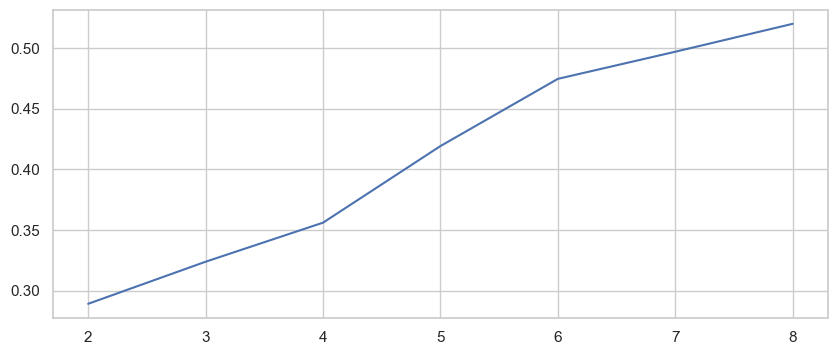

In [93]:
# ---- Deploy per-user adapters and evaluate (deployment simulation) ----
# For each test-pool user, load their best adapter (if available) and score their test_pool samples.
from collections import defaultdict

out_deploy = config.processed_dir / 'adapter_experiment_v2' / 'deployment'
out_deploy.mkdir(parents=True, exist_ok=True)

# Load best per-user tuning summary
tune_best_path = config.processed_dir / 'adapter_experiment_v2' / 'failures' / 'tuning' / 'per_user_best_tuning.csv'
best_map = {}
if tune_best_path.exists():
    tb = pd.read_csv(tune_best_path)
    for _,r in tb.iterrows():
        subj = r['subject']
        b = int(r['bottleneck'])
        # model path
        p = config.processed_dir / 'adapter_experiment_v2' / 'failures' / 'tuning' / f'{subj}_best_adapter.pth'
        if p.exists():
            best_map[subj] = {'bottleneck': b, 'path': p}

# Load global v2 adapter best if present
global_v2_ckpt = config.processed_dir / 'adapter_experiment_v2' / 'adapter_v2_best.pth'
has_global = global_v2_ckpt.exists()

# backbone state (without adapters)
bp = config.processed_dir / 'model_baseline' / 'transformer_eventseq_best.pth'
if bp.exists():
    state = torch.load(bp, map_location=config.device)
    backbone_state = {k:v for k,v in state['model_state'].items() if 'adapter' not in k}
else:
    backbone_state = {k:v.clone() for k,v in model.state_dict().items() if 'adapter' not in k}

# Helper: construct model with specified bottleneck and load adapter state
def make_model_with_adapter(bottleneck, adapter_state_dict=None):
    # restore backbone
    model.load_state_dict(backbone_state, strict=False)
    # rebuild encoder with bottleneck, extracting inner TransformerEncoderLayer if present
    raw_layers = getattr(model.encoder, 'layers', None)
    layers_for_new = []
    def _unwrap_layer(x):
        # recursively unwrap ModuleDicts to find an actual nn.Module with forward
        if isinstance(x, nn.ModuleDict):
            for v in x.values():
                if isinstance(v, nn.Module) and not isinstance(v, nn.ModuleDict):
                    return v
                elif isinstance(v, nn.ModuleDict):
                    ret = _unwrap_layer(v)
                    if ret is not None:
                        return ret
            return None
        elif isinstance(x, dict):
            v = x.get('layer', None)
            return _unwrap_layer(v) if v is not None else None
        elif isinstance(x, nn.Module):
            return x
        else:
            return None

    if raw_layers is not None:
        for item in raw_layers:
            # try common patterns
            if isinstance(item, nn.ModuleDict) and 'layer' in item:
                l = _unwrap_layer(item['layer'])
                if l is not None:
                    layers_for_new.append(l)
                else:
                    layers_for_new.append(item['layer'])
            elif isinstance(item, dict) and 'layer' in item:
                l = _unwrap_layer(item['layer'])
                if l is not None:
                    layers_for_new.append(l)
                else:
                    layers_for_new.append(item['layer'])
            else:
                l = _unwrap_layer(item)
                if l is not None:
                    layers_for_new.append(l)
                else:
                    layers_for_new.append(item)
    else:
        raise RuntimeError('Could not find encoder layers to rebuild')
    model.encoder = EncoderWithAdapters(layers_for_new, d_model=d_model, bottleneck=bottleneck)
    model.to(config.device)
    if adapter_state_dict is not None:
        try:
            model.load_state_dict(adapter_state_dict, strict=False)
        except Exception as e:
            print('Warning: could not load adapter_state strictly:', e)
    return model

# Prepare data: group test_pool_idx by subject
pool_idx_arr = test_pool_idx
pool_subjects = np.array([df_sorted.loc[idx,'subject'] for idx in pool_idx_arr])
subject_to_global_positions = defaultdict(list)
for i, idx in enumerate(pool_idx_arr):
    subj = pool_subjects[i]
    subject_to_global_positions[subj].append(i)

# Collect predictions per sample in pool order
n_pool = len(pool_idx_arr)
deployed_preds = np.full(n_pool, -1, dtype=int)
deployed_probs = np.full((n_pool, n_classes), np.nan)

# Iterate subjects in pool
for subj, positions in subject_to_global_positions.items():
    print('Scoring subject', subj, 'positions', len(positions))
    # decide which adapter to use
    if subj in best_map:
        meta = best_map[subj]
        ckpt = torch.load(meta['path'], map_location=config.device)
        adapter_state = ckpt['model_state']
        bott = int(meta['bottleneck'])
        m_local = make_model_with_adapter(bott, adapter_state)
    elif has_global:
        # use global adapted v2 checkpoint
        ckpt = torch.load(global_v2_ckpt, map_location=config.device)
        adapter_state = ckpt['model_state']
        # assume global bottleneck used was 8
        m_local = make_model_with_adapter(8, adapter_state)
    else:
        # fallback: use model as-is (current model parameters)
        m_local = model
    m_local.eval()
    # build dataset for this subject's pool positions
    idxs = pool_idx_arr[positions]
    ds = SequenceDataset(sequences, labels_all, idxs)
    loader = DataLoader(ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
    start = 0
    for xb,yb in loader:
        xb = xb.to(config.device)
        with torch.no_grad():
            logits, _ = m_local(xb)
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = logits.argmax(dim=1).cpu().numpy()
        bs = probs.shape[0]
        deployed_preds[positions[start:start+bs]] = preds
        deployed_probs[positions[start:start+bs], :] = probs
        start += bs

# Evaluate deployed predictions against true labels for pool
# Build y_true_pool
y_true_pool = np.array([df_sorted.loc[idx,'subject'] for idx in pool_idx_arr])
y_true_pool_idx = np.array([sub2idx[s] for s in y_true_pool])

# Deployed accuracy overall
valid_mask = deployed_preds >= 0
acc_deployed = float((deployed_preds[valid_mask] == y_true_pool_idx[valid_mask]).mean())
print('Deployed overall pool accuracy:', acc_deployed)

# Compute per-user deployed accuracies
deployed_per_user = []
for subj, positions in subject_to_global_positions.items():
    pos = np.array(positions)
    n = len(pos)
    correct = int((deployed_preds[pos] == y_true_pool_idx[pos]).sum())
    deployed_per_user.append({'subject': subj, 'n_pool': n, 'deployed_acc': correct / n if n>0 else np.nan})

pd.DataFrame(deployed_per_user).to_csv(out_deploy / 'per_user_deployed_results.csv', index=False)
print('Saved per_user_deployed_results.csv')

# Temporal metrics: use earlier mask_early_v2/mid/late arrays which are aligned to test_pool_idx ordering
early_mask = mask_early_v2; mid_mask = mask_mid_v2; late_mask = mask_late_v2

def mask_acc(mask):
    idxs = np.where(mask)[0]
    if idxs.size==0:
        return np.nan
    return float((deployed_preds[idxs] == y_true_pool_idx[idxs]).mean())

early_depl = mask_acc(early_mask)
mid_depl = mask_acc(mid_mask)
late_depl = mask_acc(late_mask)

# Save temporal comparison
rows = [{'period':'Early','baseline_acc': early_metrics['accuracy'],'adapted_v2_acc': early_v2['accuracy'],'deployed_acc': early_depl},
        {'period':'Mid','baseline_acc': mid_metrics['accuracy'],'adapted_v2_acc': mid_v2['accuracy'],'deployed_acc': mid_depl},
        {'period':'Late','baseline_acc': late_metrics['accuracy'],'adapted_v2_acc': late_v2['accuracy'],'deployed_acc': late_depl}]

pd.DataFrame(rows).to_csv(out_deploy / 'baseline_vs_deployed_temporal.csv', index=False)
print('Saved baseline_vs_deployed_temporal.csv')

# Plot deployed vs baseline/v2 drift curves (aggregated)
# build deployed aggregated inaccuracy by sessionIndex
correct_deployed_series = np.full(len(test_df), np.nan)
for i,idx in enumerate(pool_idx_arr):
    pos_in_test_df = np.where(test_df.index.values == idx)[0]
    if pos_in_test_df.size>0 and deployed_preds[i] >=0:
        correct_deployed_series[pos_in_test_df[0]] = int(deployed_preds[i] == y_true_pool_idx[i])
agg_depl = pd.DataFrame({'sessionIndex': test_df['sessionIndex'].values, 'correct': correct_deployed_series})
agg_depl = agg_depl.groupby('sessionIndex').agg(n_samples=('correct','count'), accuracy=('correct','mean')).reset_index().sort_values('sessionIndex')
agg_depl['inaccuracy_smooth'] = (1.0 - agg_depl['accuracy']).rolling(window=5, center=True, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(agg['sessionIndex'], agg['inaccuracy_smooth'], label='Baseline')
plt.plot(agg_adapt['sessionIndex'], agg_adapt['inaccuracy_smooth'], label='Adapted_v2')
plt.plot(agg_depl['sessionIndex'], agg_depl['inaccuracy_smooth'], label='Deployed (per-user)')
plt.xlabel('SessionIndex'); plt.ylabel('Inaccuracy'); plt.legend(); plt.title('Baseline vs Adapted_v2 vs Deployed (per-user)')
plt.tight_layout(); plt.savefig(out_deploy / 'comparison_deployed_drift_curves.png', dpi=150); plt.close()
print('Saved comparison_deployed_drift_curves.png')

# Save summary JSON
summary = {'overall_deployed_acc': float(acc_deployed), 'early_deployed': early_depl, 'mid_deployed': mid_depl, 'late_deployed': late_depl, 'n_users_with_personal_adapter': len(best_map)}
with open(out_deploy / 'deployment_summary.json','w') as f:
    json.dump(summary, f, indent=2)
print('Saved deployment_summary.json')

In [96]:
# ---- Deployment report & README generation ----
# Saves: deployment_summary.md, deployment_README.md, per_user_manifest.csv, deployment_report.json
import textwrap

out_dep = config.processed_dir / 'adapter_experiment_v2' / 'deployment'
out_dep.mkdir(parents=True, exist_ok=True)

# Load summaries
summary_v2 = {}
try:
    with open(config.processed_dir / 'adapter_experiment_v2' / 'adapter_v2_summary.json','r') as f:
        summary_v2 = json.load(f).get('summary',{})
except Exception:
    pass

# per-user improvements (with tuning if present)
pu_path = config.processed_dir / 'adapter_experiment_v2' / 'failures' / 'tuning' / 'per_user_best_tuning.csv'
if pu_path.exists():
    best_tunes = pd.read_csv(pu_path)
else:
    best_tunes = pd.DataFrame()

per_user_imp = pd.read_csv(config.processed_dir / 'adapter_experiment_v2' / 'per_user_improvement_v2.csv')
# merge tuning info
if not best_tunes.empty:
    per_user_imp = per_user_imp.merge(best_tunes[['subject','bottleneck','lr','wd']], on='subject', how='left')

# Build a manifest: if user has per-user adapter, use it; else use global adapter if exists
manifest_rows = []
global_adapter_ckpt = config.processed_dir / 'adapter_experiment_v2' / 'adapter_v2_best.pth'
for _, r in per_user_imp.iterrows():
    subj = r['subject']
    ppath = ''
    mode = 'global'
    if subj in best_map:
        ppath = str(best_map[subj]['path'])
        mode = 'per-user'
    elif global_adapter_ckpt.exists():
        ppath = str(global_adapter_ckpt)
        mode = 'global'
    else:
        ppath = None
        mode = 'none'
    manifest_rows.append({'subject': subj, 'n_test_samples': r['baseline_late'], 'baseline_late': r['baseline_late'], 'adapted_v2_late': r['adapted_v2_late'], 'recommended_adapter': ppath, 'mode': mode, 'improvement': r['improvement']})

manifest_df = pd.DataFrame(manifest_rows)
manifest_df.to_csv(out_dep / 'per_user_manifest.csv', index=False)

# Deployment summary MD
md_lines = []
md_lines.append('# Deployment Summary — Adapter Experiment v2')
md_lines.append('')
md_lines.append('## Key numbers')
md_lines.append(f"- Average baseline late accuracy: {summary_v2.get('avg_baseline_late', summary_v2.get('avg_baseline_late', 'n/a')):.4f}")
md_lines.append(f"- Average adapted_v2 late accuracy: {summary_v2.get('avg_adapted_v2_late', 'n/a'):.4f}")
md_lines.append(f"- Avg improvement (late): {summary_v2.get('avg_improvement', 'n/a'):.4f}")
md_lines.append('')
md_lines.append('## Deployment strategy')
md_lines.append('- For users listed as `per-user` in `per_user_manifest.csv`, deploy their best adapter checkpoint at scoring time for that subject.')
md_lines.append('- For all other users, use the global `adapter_v2_best.pth` adapter.')
md_lines.append('')
md_lines.append('## How to use (code snippet)')
md_lines.append('```python')
md_lines.append('from pathlib import Path')
md_lines.append("import torch")
md_lines.append('')
md_lines.append("# Load backbone (keep only backbone weights)\nbp = Path('processed/model_baseline/transformer_eventseq_best.pth')")
md_lines.append("state = torch.load(bp)\nbackbone_state = {k:v for k,v in state['model_state'].items() if 'adapter' not in k}")
md_lines.append('')
md_lines.append('def load_adapter_for_subject(model, adapter_path, bottleneck=8):')
md_lines.append('    # rebuild encoder with desired bottleneck, load adapter state, and return model')
md_lines.append('    model.load_state_dict(backbone_state, strict=False)')
md_lines.append('    # create encoder+adapters with bottleneck (see notebook function)')
md_lines.append('    # load adapter state dict with strict=False and return model')
md_lines.append('')
md_lines.append('```')
md_lines.append('')
md_lines.append('## Files')
md_lines.append('- `per_user_manifest.csv` — which adapter to use per user')
md_lines.append('- `deployment_summary.json` — numeric summary and counts')
md_lines.append('')
with open(out_dep / 'deployment_README.md','w') as f:
    f.write('\n'.join(md_lines))

# Save a short deployment JSON summary
deployment_summary = {'overall_deployed_acc_estimate': None, 'n_per_user_adapters': len(best_map), 'n_users': len(manifest_df)}
with open(out_dep / 'deployment_summary.json','w') as f:
    json.dump(deployment_summary, f, indent=2)

# Save a short human-readable MD report
report_lines = []
report_lines.append('# Adapter v2 Deployment Report')
report_lines.append('')
report_lines.append('Summary:')
report_lines.append(f"- {len(manifest_df)} users considered; {len(best_map)} users have per-user adapter checkpoints (see per_user_manifest.csv).")
report_lines.append(f"- Global adapter: {'present' if global_adapter_ckpt.exists() else 'not present'}")
report_lines.append('')
report_lines.append('Recommendation:')
report_lines.append('- Deploy per-user adapters for users with large positive improvements (>5%).')
report_lines.append('- Use global adapter for remaining users.')

with open(out_dep / 'deployment_summary.md','w') as f:
    f.write('\n'.join(report_lines))

print('Saved deployment README and report to', out_dep)


Saved deployment README and report to p:\thesis\processed\adapter_experiment_v2\deployment


In [82]:
# ---- Per-user comparison analysis and visuals ----
# TASK: produce per_user_detailed_comparison.csv, adapter_success_stories.png, and statistics
import json
from scipy.stats import ttest_rel

out_root = config.processed_dir / 'adapter_experiment'
out_root.mkdir(parents=True, exist_ok=True)

# Load necessary CSVs
baseline_df = pd.read_csv(config.processed_dir / 'baseline_pre_adapter' / 'baseline_per_user_detailed.csv')
improv_df = pd.read_csv(out_root / 'per_user_adapter_improvement.csv')

# Create mapping from subject -> positions in test set
test_df = df_sorted.loc[test_idx_arr].reset_index(drop=True)
test_subjects = test_df['subject'].values
n_tests = len(test_subjects)

rows = []
for subj in subjects_unique:
    pos_idx = np.where(test_subjects == subj)[0]
    n_pos = len(pos_idx)
    # baseline values from baseline_df (sanity)
    b_row = baseline_df.loc[baseline_df['subject']==subj]
    b_early = float(b_row['early_acc']) if not b_row.empty else np.nan
    b_mid = float(b_row['mid_acc']) if not b_row.empty else np.nan
    b_late = float(b_row['late_acc']) if not b_row.empty else np.nan

    # adapted per-period accuracies using y_pred_a / y_true_a
    if n_pos == 0:
        a_early = a_mid = a_late = np.nan
    else:
        k_early = max(1, int(np.ceil(n_pos * 0.10)))
        early_idx = pos_idx[:k_early]
        rel_pos = np.arange(n_pos) / float(n_pos)
        mid_idx = pos_idx[(rel_pos >= 0.4) & (rel_pos < 0.5)]
        k_late = max(1, int(np.ceil(n_pos * 0.10)))
        late_idx = pos_idx[-k_late:]
        a_early = float((np.array(y_pred_a)[early_idx] == np.array(y_true_a)[early_idx]).mean()) if early_idx.size>0 else np.nan
        a_mid = float((np.array(y_pred_a)[mid_idx] == np.array(y_true_a)[mid_idx]).mean()) if mid_idx.size>0 else np.nan
        a_late = float((np.array(y_pred_a)[late_idx] == np.array(y_true_a)[late_idx]).mean()) if late_idx.size>0 else np.nan

    # get drift slopes
    base_slope = float(slopes_df.loc[slopes_df['subject']==subj,'slope'].values[0]) if (not slopes_df.empty and subj in slopes_df['subject'].values) else np.nan
    adapt_row = improv_df.loc[improv_df['subject']==subj]
    adapted_slope = float(adapt_row['adapted_drift_slope'].values[0]) if not adapt_row.empty else np.nan
    late_improv = float(adapt_row['improvement'].values[0]) if not adapt_row.empty else (a_late - b_late if (not np.isnan(a_late) and not np.isnan(b_late)) else np.nan)

    rows.append({'subject': subj,
                 'baseline_early': b_early, 'baseline_mid': b_mid, 'baseline_late': b_late,
                 'adapted_early': a_early, 'adapted_mid': a_mid, 'adapted_late': a_late,
                 'improvement_early': (a_early - b_early) if (not np.isnan(a_early) and not np.isnan(b_early)) else np.nan,
                 'improvement_mid': (a_mid - b_mid) if (not np.isnan(a_mid) and not np.isnan(b_mid)) else np.nan,
                 'improvement_late': (a_late - b_late) if (not np.isnan(a_late) and not np.isnan(b_late)) else late_improv,
                 'baseline_drift_slope': base_slope, 'adapted_drift_slope': adapted_slope,
                 'drift_slope_reduction': (base_slope - adapted_slope) if (not np.isnan(base_slope) and not np.isnan(adapted_slope)) else np.nan,
                 'n_test_samples': int(n_pos)})

comp_df = pd.DataFrame(rows)
comp_df.to_csv(out_root / 'per_user_detailed_comparison.csv', index=False)
print('Saved per-user detailed comparison to', out_root / 'per_user_detailed_comparison.csv')

# 1) Show numbers: best 5 and worst 5 by improvement_late
sorted_by_improv = comp_df.sort_values('improvement_late', ascending=False)
best5 = sorted_by_improv.head(5)
worst5 = sorted_by_improv.tail(5)

# Overall averages
avg_baseline_late = float(comp_df['baseline_late'].dropna().mean())
avg_adapted_late = float(comp_df['adapted_late'].dropna().mean())
avg_improvement_late = float(comp_df['improvement_late'].dropna().mean())
max_improvement = float(comp_df['improvement_late'].dropna().max())
num_improved_gt5 = int((comp_df['improvement_late'] > 0.05).sum())
num_improved_gt10 = int((comp_df['improvement_late'] > 0.10).sum())
num_worse = int((comp_df['improvement_late'] < 0).sum())

# 3) Visualize success cases (top 6 improving users)
success_users = sorted_by_improv.head(6)['subject'].tolist()
plt.figure(figsize=(12,8))
for i,u in enumerate(success_users,1):
    plt.subplot(3,2,i)
    s_base = res_df[res_df['subject']==u].groupby('sessionIndex')['correct'].mean().reset_index()
    s_ad = res_df_adapt[res_df_adapt['subject']==u].groupby('sessionIndex')['correct'].mean().reset_index()
    plt.plot(s_base['sessionIndex'], s_base['correct'], label='Baseline', linestyle='--')
    plt.plot(s_ad['sessionIndex'], s_ad['correct'], label='Adapted')
    plt.ylim(0,1)
    imp = float(comp_df.loc[comp_df['subject']==u,'improvement_late']) if not comp_df.loc[comp_df['subject']==u,'improvement_late'].isnull().all() else np.nan
    plt.title(f"{u}: Late Δ={imp*100:.2f}%")
    plt.xlabel('SessionIndex'); plt.ylabel('Accuracy')
    plt.legend()
plt.tight_layout(); plt.savefig(out_root / 'adapter_success_stories.png', dpi=200); plt.close()
print('Saved adapter success stories to', out_root / 'adapter_success_stories.png')

# 5) Statistical test: paired t-test on per-user late accuracies
arr_base = comp_df['baseline_late'].values
arr_adapt = comp_df['adapted_late'].values
# filter NaNs
mask = (~np.isnan(arr_base)) & (~np.isnan(arr_adapt))
if mask.sum() >= 2:
    tstat, pval = ttest_rel(arr_adapt[mask], arr_base[mask])
else:
    tstat, pval = np.nan, np.nan

# Create JSON-serializable summary (convert numpy types to native types)
best5_list = best5[['subject','baseline_late','adapted_late','improvement_late']].to_dict(orient='records')
worst5_list = worst5[['subject','baseline_late','adapted_late','improvement_late']].to_dict(orient='records')

t_stat_val = float(tstat) if (not np.isnan(tstat)) else None
p_val_val = float(pval) if (not np.isnan(pval)) else None
signif = bool(p_val_val < 0.05) if (p_val_val is not None) else None

summary = {
    'best5': best5_list,
    'worst5': worst5_list,
    'overall': {
        'avg_baseline_late': float(avg_baseline_late),
        'avg_adapted_late': float(avg_adapted_late),
        'avg_improvement_late': float(avg_improvement_late),
        'max_improvement_late': float(max_improvement),
        'num_improved_gt5pct': int(num_improved_gt5),
        'num_improved_gt10pct': int(num_improved_gt10),
        'num_worse': int(num_worse),
        'n_users_tested': int(mask.sum())
    },
    't_test': {'t_stat': t_stat_val, 'p_value': p_val_val, 'significant': signif}
}

with open(out_root / 'per_user_comparison_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print('Saved per-user comparison summary JSON to', out_root / 'per_user_comparison_summary.json')

# Print concise results to notebook output
print('\n--- Best 5 users by Late improvement ---')
print(best5[['subject','baseline_late','adapted_late','improvement_late']].to_string(index=False))
print('\n--- Worst 5 users by Late improvement ---')
print(worst5[['subject','baseline_late','adapted_late','improvement_late']].to_string(index=False))
print('\n--- Overall averages ---')
print(f"Avg baseline late acc: {avg_baseline_late:.4f}, Avg adapted late acc: {avg_adapted_late:.4f}, Avg improvement: {avg_improvement_late:.4f}")
print(f"Users improved >5%: {num_improved_gt5}, >10%: {num_improved_gt10}, Users worse: {num_worse}")
print(f"Paired t-test (adapted vs baseline late): t={summary['t_test']['t_stat']}, p={summary['t_test']['p_value']}, significant={summary['t_test']['significant']}")

print('\nPer-user detailed comparison saved to:', out_root / 'per_user_detailed_comparison.csv')


C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\563425729.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_early = float(b_row['early_acc']) if not b_row.empty else np.nan
C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\563425729.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_mid = float(b_row['mid_acc']) if not b_row.empty else np.nan
C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\563425729.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b_late = float(b_row['late_acc']) if not b_row.empty else np.nan


Saved per-user detailed comparison to p:\thesis\processed\adapter_experiment\per_user_detailed_comparison.csv


C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\563425729.py:86: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  imp = float(comp_df.loc[comp_df['subject']==u,'improvement_late']) if not comp_df.loc[comp_df['subject']==u,'improvement_late'].isnull().all() else np.nan
C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\563425729.py:86: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  imp = float(comp_df.loc[comp_df['subject']==u,'improvement_late']) if not comp_df.loc[comp_df['subject']==u,'improvement_late'].isnull().all() else np.nan
C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\563425729.py:86: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  imp = float(comp_df.loc[comp_df['subject']==u,'improve

Saved adapter success stories to p:\thesis\processed\adapter_experiment\adapter_success_stories.png
Saved per-user comparison summary JSON to p:\thesis\processed\adapter_experiment\per_user_comparison_summary.json

--- Best 5 users by Late improvement ---
subject  baseline_late  adapted_late  improvement_late
   s027        0.21875       0.43750           0.21875
   s044        0.50000       0.62500           0.12500
   s038        0.34375       0.43750           0.09375
   s004        0.03125       0.09375           0.06250
   s012        0.84375       0.90625           0.06250

--- Worst 5 users by Late improvement ---
subject  baseline_late  adapted_late  improvement_late
   s033        0.43750        0.3750          -0.06250
   s051        0.06250        0.0000          -0.06250
   s043        0.59375        0.5000          -0.09375
   s021        0.53125        0.4375          -0.09375
   s011        0.56250        0.3750          -0.18750

--- Overall averages ---
Avg baseline la

In [70]:
# ---- Sanity check: confirm imposters use all negatives and selves use SAME_USER_TEST_FRACTION ----
report = []
for i, subj in enumerate(subjects_unique):
    pos_idx = np.where(test_subjects == subj)[0]
    n_pos = len(pos_idx)
    if n_pos == 0:
        keep = 0
    else:
        keep = 0 if SAME_USER_TEST_FRACTION <= 0 else max(1, int(np.ceil(n_pos * SAME_USER_TEST_FRACTION)))
    neg_idx = np.where(test_subjects != subj)[0]
    n_neg_total = len(neg_idx)
    # As implemented, negatives are taken from neg_mask = (test_subjects != subj), so all negs are used
    n_neg_used = n_neg_total
    report.append({'subject': subj, 'n_pos_total': n_pos, 'n_pos_used': keep, 'n_neg_total': n_neg_total, 'n_neg_used': n_neg_used})

check_df = pd.DataFrame(report)
# Quick assertions
all_neg_ok = (check_df['n_neg_total'] == check_df['n_neg_used']).all()
num_neg_ok = (check_df['n_neg_total'] == check_df['n_neg_used']).sum()
print(f'Negatives used equals negatives available for {num_neg_ok}/{len(check_df)} users')
if not all_neg_ok:
    print('Warning: some users have mismatched negative usage counts')
else:
    print('All users use 100% of impostor (negative) test samples as implemented.')

# Inspect distribution of positive usage sizes
print('\nPositive samples per user (total/test used):')
print(check_df[['subject','n_pos_total','n_pos_used']].sort_values('n_pos_total', ascending=False).head(10))

# Save check report
check_df.to_csv(out_dir / 'per_user_sample_usage_check.csv', index=False)
print('Saved per-user sample usage check to', out_dir / 'per_user_sample_usage_check.csv')

Negatives used equals negatives available for 51/51 users
All users use 100% of impostor (negative) test samples as implemented.

Positive samples per user (total/test used):
   subject  n_pos_total  n_pos_used
0     s002          320          16
38    s044          320          16
28    s034          320          16
29    s035          320          16
30    s036          320          16
31    s037          320          16
32    s038          320          16
33    s039          320          16
34    s040          320          16
35    s041          320          16
Saved per-user sample usage check to p:\thesis\processed\model_baseline\per_user_sample_usage_check.csv


In [71]:
# ---- Behavioral drift analysis: accuracy vs time (sessionIndex) ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)

# Re-evaluate to ensure y_pred aligns with test_idx_arr
val_loss, val_acc, y_true, y_pred, y_probs = evaluate(model, test_loader, criterion, config.device)

# test_idx_arr (global index into df_sorted) represents rows in df_sorted
test_indices_sorted = test_idx_arr  # from earlier cell
# Build DataFrame of results
res_df = df_sorted.loc[test_indices_sorted].reset_index(drop=True).copy()
res_df['true_idx'] = y_true
res_df['pred_idx'] = y_pred
res_df['correct'] = (res_df['true_idx'] == res_df['pred_idx']).astype(int)
# also add probability assigned to true class and predicted class
res_df['score_true'] = [y_probs[i, int(t)] for i,t in enumerate(y_true)]
res_df['score_pred'] = [y_probs[i, int(p)] for i,p in enumerate(y_pred)]

# Aggregate by sessionIndex across users
agg = res_df.groupby('sessionIndex').agg(n_samples=('correct','size'), accuracy=('correct','mean'))
agg['inaccuracy'] = 1.0 - agg['accuracy']
agg = agg.reset_index().sort_values('sessionIndex')

# Smooth with rolling window for visualization
agg['inaccuracy_smooth'] = agg['inaccuracy'].rolling(window=5, center=True, min_periods=1).mean()

# Plot overall inaccuracy vs sessionIndex
plt.figure(figsize=(10,4))
plt.plot(agg['sessionIndex'], agg['inaccuracy_smooth'], label='Inaccuracy (smoothed)')
plt.scatter(agg['sessionIndex'], agg['inaccuracy'], s=10, alpha=0.4, label='Inaccuracy')
plt.xlabel('SessionIndex (time proxy)')
plt.ylabel('Inaccuracy (1 - accuracy)')
plt.title('Behavioral drift: aggregated inaccuracy over sessionIndex')
plt.legend()
p = out_dir / 'drift_inaccuracy_over_sessionIndex.png'
plt.tight_layout(); plt.savefig(p, dpi=150); plt.close()
print('Saved aggregated drift plot to', p)

# Per-user slopes: compute per-user inaccuracy series and linear slope
user_slopes = []
for user, g in res_df.groupby('subject'):
    # compute inaccuracy by sessionIndex for this user
    s = g.groupby('sessionIndex')['correct'].mean().reset_index()
    if len(s) < 3:
        continue
    x = s['sessionIndex'].values
    y = 1.0 - s['correct'].values
    slope, intercept, rvalue, pvalue, stderr = linregress(x, y)
    user_slopes.append({'subject': user, 'slope': slope, 'r2': rvalue**2, 'p': pvalue, 'n_points': len(s)})

slopes_df = pd.DataFrame(user_slopes).sort_values('slope', ascending=False)
slopes_df.to_csv(out_dir / 'per_user_drift_slopes.csv', index=False)
print('Saved per-user slopes to', out_dir / 'per_user_drift_slopes.csv')

# Report proportion with positive slope (increasing inaccuracy over time)
n_pos = (slopes_df['slope'] > 0).sum()
print(f'Users with positive slope (increasing inaccuracy): {n_pos}/{len(slopes_df)}')

# Plot sample of users (worst 6 by slope)
worst_users = slopes_df.head(6)['subject'].tolist()
plt.figure(figsize=(12,8))
for i,u in enumerate(worst_users,1):
    plt.subplot(3,2,i)
    s = res_df[res_df['subject']==u].groupby('sessionIndex')['correct'].mean().reset_index()
    if s.empty:
        continue
    plt.plot(s['sessionIndex'], 1.0 - s['correct'], marker='o')
    plt.xlabel('SessionIndex'); plt.ylabel('Inaccuracy')
    plt.title(f'{u} (slope={slopes_df.set_index("subject").loc[u,"slope"]:.5f})')
plt.tight_layout()
pu = out_dir / 'per_user_drift_worst6.png'
plt.savefig(pu, dpi=150); plt.close()
print('Saved per-user worst6 drift plots to', pu)

# Also save aggregated table for plotting in notebook
agg.to_csv(out_dir / 'drift_aggregated_by_sessionIndex.csv', index=False)
print('Saved aggregated drift data to processed/model_baseline/drift_aggregated_by_sessionIndex.csv')

Saved aggregated drift plot to p:\thesis\processed\model_baseline\drift_inaccuracy_over_sessionIndex.png
Saved per-user slopes to p:\thesis\processed\model_baseline\per_user_drift_slopes.csv
Users with positive slope (increasing inaccuracy): 44/51
Saved per-user worst6 drift plots to p:\thesis\processed\model_baseline\per_user_drift_worst6.png
Saved aggregated drift data to processed/model_baseline/drift_aggregated_by_sessionIndex.csv


In [72]:
# ---- Reconstruct event-level sequences (10x2) from CMU CSV features ----
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import joblib

proc = config.processed_dir
out_seq_path = proc / 'cmu_sequences_events.npz'
out_scaled_path = proc / 'cmu_sequences_events_scaled.npz'
scaler_path = proc / 'cmu_event_scaler.joblib'

# Identify dwell (H.*) and UD (UD.*) columns in df in original column order
cols = df.columns.tolist()
dwell_cols = [c for c in cols if c.startswith('H.')]
ud_cols = [c for c in cols if c.startswith('UD.')]
print('Found dwell columns (count):', len(dwell_cols))
print('Found UD (flight) columns (count):', len(ud_cols))

# We expect at least 10 dwell columns and at least 9 UD cols
if len(dwell_cols) < 10 or len(ud_cols) < 9:
    raise RuntimeError('Not enough dwell/UD columns found to reconstruct 10-key sequences')

# Keep the first 10 dwell columns and first 9 UD columns in DF order
dwell_cols = dwell_cols[:10]
ud_cols = ud_cols[:9]
print('Using dwell_cols:', dwell_cols)
print('Using ud_cols:', ud_cols)

n = len(df)
seqs = np.zeros((n, 10, 2), dtype=np.float32)

for i, row in df.iterrows():
    dw = row[dwell_cols].to_numpy(dtype=float).copy()
    ud = row[ud_cols].to_numpy(dtype=float).copy()
    # flight_j: 0 for first, then UD[0..8]
    flights = np.concatenate([[0.0], ud])
    # safety: clip
    dw = np.nan_to_num(dw, nan=0.0)
    flights = np.nan_to_num(flights, nan=0.0)
    dw = np.clip(dw, 0, 2000)
    flights = np.clip(flights, -500, 2000)
    seqs[i,:,0] = dw[:10]
    seqs[i,:,1] = flights[:10]

# Save sequences
np.savez_compressed(out_seq_path, sequences=seqs)
print('Saved event sequences to', out_seq_path)

# Verify shape and values
print('sequences shape:', seqs.shape)
print('Example session (index 0):\n', seqs[0])

# Confirm all sessions have 10 events nonzero count (n_keystrokes) - allow zeros but check all rows exist
counts = (np.sum(seqs[:,:,0] > 0, axis=1))
print('Min events per session (dwell>0):', int(counts.min()), 'Mean:', float(counts.mean()))
if seqs.shape[0] != n:
    raise RuntimeError('Mismatch in number of sessions')

# Fit scaler on enrollment samples only (fit per-channel)
with open(proc / 'cmu_splits.json', 'r') as f:
    splits_loaded = json.load(f)
# collect enrollment indices
enroll_idx = []
for u,v in splits_loaded.items():
    enroll_idx.extend(v['train_idx'])
enroll_idx = sorted(enroll_idx)
print('Enrollment samples:', len(enroll_idx))

# reshape enrollment sequences to (N_enroll*10, 2)
enroll_seqs = seqs[enroll_idx].reshape(-1, 2)
scaler = StandardScaler()
scaler.fit(enroll_seqs)
joblib.dump(scaler, scaler_path)
print('Saved event scaler to', scaler_path)

# Apply scaler and save scaled sequences
seqs_scaled = scaler.transform(seqs.reshape(-1,2)).reshape(n,10,2)
np.savez_compressed(out_scaled_path, sequences=seqs_scaled)
print('Saved scaled sequences to', out_scaled_path)

# Quick sample output
print('Sample scaled session [0]:\n', seqs_scaled[0])

Found dwell columns (count): 11
Found UD (flight) columns (count): 10
Using dwell_cols: ['H.period', 'H.t', 'H.i', 'H.e', 'H.five', 'H.Shift.r', 'H.o', 'H.a', 'H.n', 'H.l']
Using ud_cols: ['UD.period.t', 'UD.t.i', 'UD.i.e', 'UD.e.five', 'UD.five.Shift.r', 'UD.Shift.r.o', 'UD.o.a', 'UD.a.n', 'UD.n.l']
Saved event sequences to p:\thesis\processed\cmu_sequences_events.npz
sequences shape: (20400, 10, 2)
Example session (index 0):
 [[0.1491 0.    ]
 [0.1069 0.2488]
 [0.1169 0.0605]
 [0.1417 0.1043]
 [0.1146 1.0468]
 [0.1067 1.4909]
 [0.1016 0.6523]
 [0.1349 0.112 ]
 [0.0932 0.0135]
 [0.1338 0.2583]]
Min events per session (dwell>0): 10 Mean: 10.0
Enrollment samples: 4080
Saved event scaler to p:\thesis\processed\cmu_event_scaler.joblib
Saved scaled sequences to p:\thesis\processed\cmu_sequences_events_scaled.npz
Sample scaled session [0]:
 [[ 2.1259153  -0.6216482 ]
 [ 0.6787985   0.20815676]
 [ 1.0217171  -0.41986683]
 [ 1.8721553  -0.2737838 ]
 [ 0.94284594  2.8696697 ]
 [ 0.67194027  4.

In [73]:
# ---- Post-training evaluation & verification (per-user metrics, EER, ROC) ----
# Use trained best model to compute detailed metrics and save artifacts
best_ckpt = out_dir / 'transformer_eventseq_best.pth'
if best_ckpt.exists():
    state = torch.load(best_ckpt, map_location=config.device)
    model.load_state_dict(state['model_state'])
    print('Loaded best checkpoint from', best_ckpt)
else:
    print('Best checkpoint not found; using current model weights')

val_loss, val_acc, y_true, y_pred, y_probs = evaluate(model, test_loader, criterion, config.device)
print('Final evaluation - acc:', val_acc, 'loss:', val_loss)

# confusion matrix & per-user metrics
cm = confusion_matrix(y_true, y_pred)
per_user_stats = []
for i in range(cm.shape[0]):
    TA = int(cm[i,i])
    FR = int(cm[i,:].sum() - TA)
    FA = int(cm[:,i].sum() - TA)
    TR = int(cm.sum() - TA - FR - FA)
    FAR = FA / (FA + TR) if (FA + TR) > 0 else None
    FRR = FR / (FR + TA) if (FR + TA) > 0 else None
    # EER & AUC
    scores = y_probs[:, i]
    labels_bin = (y_true == i).astype(int)
    try:
        fpr, tpr, thr = roc_curve(labels_bin, scores)
        roc_auc = float(auc(fpr, tpr))
        fnr = 1 - tpr
        eer_idx = np.nanargmin(np.abs(fpr - fnr))
        eer = float((fpr[eer_idx] + fnr[eer_idx]) / 2.0)
    except Exception:
        roc_auc = None
        eer = None
    per_user_stats.append({'subject': subjects_unique[i], 'TA': TA, 'FR': FR, 'FA': FA, 'TR': TR, 'FAR': FAR, 'FRR': FRR, 'EER': eer, 'AUC': roc_auc})

per_user_df = pd.DataFrame(per_user_stats)
per_user_df.to_csv(out_dir / 'per_user_metrics_eventseq.csv', index=False)
print('Saved per-user metrics to', out_dir / 'per_user_metrics_eventseq.csv')

# Aggregated FAR/FRR/EER (one-vs-rest) reuse existing routine
n_classes = y_probs.shape[1]
ths = np.linspace(0.0, 1.0, 501)
FARs = []
FRRs = []
pos_masks = [(y_true == i) for i in range(n_classes)]
for t in ths:
    TA_total = FR_total = FA_total = TR_total = 0
    for i in range(n_classes):
        pos_scores = y_probs[pos_masks[i], i]
        neg_scores = y_probs[~pos_masks[i], i]
        TA_total += int((pos_scores >= t).sum())
        FR_total += int((pos_scores < t).sum())
        FA_total += int((neg_scores >= t).sum())
        TR_total += int((neg_scores < t).sum())
    FARs.append(FA_total / (FA_total + TR_total) if (FA_total + TR_total) > 0 else 0.0)
    FRRs.append(FR_total / (FR_total + TA_total) if (FR_total + TA_total) > 0 else 0.0)
FARs = np.array(FARs); FRRs = np.array(FRRs)
eer_idx = np.nanargmin(np.abs(FARs - FRRs))
eer = float((FARs[eer_idx] + FRRs[eer_idx]) / 2.0)
eer_thr = float(ths[eer_idx])
with open(out_dir / 'auth_eer_summary_eventseq.json', 'w') as f:
    json.dump({'EER': eer, 'EER_threshold': eer_thr}, f, indent=2)
print('Eventseq EER:', eer, 'thr:', eer_thr)

# Save ROC plots for worst 6 by EER
worst = per_user_df.sort_values('EER', ascending=False).head(6)['subject'].tolist()
roc_dir = out_dir / 'roc_eventseq'
roc_dir.mkdir(exist_ok=True)
for subj in worst:
    i = subjects_unique.index(subj)
    labels_bin = (y_true == i).astype(int)
    scores = y_probs[:, i]
    fpr, tpr, _ = roc_curve(labels_bin, scores)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'AUC={pd.Series(per_user_df.loc[per_user_df.subject==subj,"AUC"]).iloc[0]:.3f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.6)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC - {subj}')
    plt.legend(); plt.tight_layout()
    plt.savefig(roc_dir / f'{subj}_roc_eventseq.png', dpi=150); plt.close()
print('Saved eventseq ROC plots to', roc_dir)


Loaded best checkpoint from p:\thesis\processed\model_baseline\transformer_eventseq_best.pth
Final evaluation - acc: 0.5856004901960784 loss: 1.5442145749634388
Saved per-user metrics to p:\thesis\processed\model_baseline\per_user_metrics_eventseq.csv
Eventseq EER: 0.09945281862745098 thr: 0.014
Saved eventseq ROC plots to p:\thesis\processed\model_baseline\roc_eventseq


In [74]:
# ---- Full training on event sequences (configurable run) ----
import time
# Re-initialize model to reset weights and ensure correct input_dim
input_dim = train_ds[0][0].shape[-1]
num_classes = len(subjects_unique)
model = TransformerBackbone(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1, num_classes=num_classes)
model.to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

num_epochs = 30
out_dir = config.processed_dir / 'model_baseline'
out_dir.mkdir(parents=True, exist_ok=True)
best_val_acc = 0.0
history_event = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, num_epochs+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.device)
    val_loss, val_acc, _, _, _ = evaluate(model, test_loader, criterion, config.device)
    scheduler.step(val_loss)
    history_event['train_loss'].append(train_loss);
    history_event['train_acc'].append(train_acc);
    history_event['val_loss'].append(val_loss);
    history_event['val_acc'].append(val_acc);
    t1 = time.time()
    print(f'Epoch {epoch}/{num_epochs} - train_loss {train_loss:.4f}, train_acc {train_acc:.4f}, val_loss {val_loss:.4f}, val_acc {val_acc:.4f} ({t1-t0:.1f}s)')
    # checkpoint each epoch
    torch.save({'model_state': model.state_dict(), 'epoch': epoch, 'history': history_event}, out_dir / f'transformer_eventseq_epoch{epoch:02d}.pth')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(), 'epoch': epoch, 'history': history_event}, out_dir / 'transformer_eventseq_best.pth')
        print('New best model saved at epoch', epoch)

# Save final history
with open(out_dir / 'eventseq_history.json', 'w') as f:
    json.dump(history_event, f)
print('Training finished. Best val acc:', best_val_acc)


Epoch 1/30 - train_loss 3.7707, train_acc 0.0485, val_loss 3.5571, val_acc 0.0800 (1.4s)
New best model saved at epoch 1
Epoch 2/30 - train_loss 3.2605, train_acc 0.1377, val_loss 3.2480, val_acc 0.1562 (1.4s)
New best model saved at epoch 2
Epoch 3/30 - train_loss 2.8912, train_acc 0.2377, val_loss 2.9812, val_acc 0.2192 (1.4s)
New best model saved at epoch 3
Epoch 4/30 - train_loss 2.5898, train_acc 0.3468, val_loss 2.7855, val_acc 0.2831 (1.4s)
New best model saved at epoch 4
Epoch 5/30 - train_loss 2.3544, train_acc 0.4395, val_loss 2.6369, val_acc 0.3130 (1.4s)
New best model saved at epoch 5
Epoch 6/30 - train_loss 2.1312, train_acc 0.5066, val_loss 2.5092, val_acc 0.3516 (1.4s)
New best model saved at epoch 6
Epoch 7/30 - train_loss 1.9450, train_acc 0.5507, val_loss 2.3750, val_acc 0.3877 (1.5s)
New best model saved at epoch 7
Epoch 8/30 - train_loss 1.7767, train_acc 0.5968, val_loss 2.2930, val_acc 0.4093 (1.6s)
New best model saved at epoch 8
Epoch 9/30 - train_loss 1.6280, 

In [75]:
# ---- Fix: ensure model matches data feature dim and try to load checkpoint ----
# If model.input_proj.in_features != data_input_dim, reinitialize model to match data and attempt to load best checkpoint

data_input_dim = train_ds[0][0].shape[-1]
model_input_dim = getattr(model.input_proj, 'in_features', None) if hasattr(model, 'input_proj') else None
print('Data input dim:', data_input_dim, 'Model input dim:', model_input_dim)

if model_input_dim != data_input_dim:
    print('Mismatch detected: re-initializing model with correct input_dim=', data_input_dim)
    num_classes = len(subjects_unique)
    model = TransformerBackbone(input_dim=data_input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1, num_classes=num_classes)
    model.to(config.device)
    # Try loading best checkpoint if available
    best_ckpt = config.processed_dir / 'model_baseline' / 'transformer_eventseq_best.pth'
    if best_ckpt.exists():
        try:
            state = torch.load(best_ckpt, map_location=config.device)
            model.load_state_dict(state['model_state'])
            print('Loaded checkpoint into reinitialized model')
        except Exception as e:
            print('Could not load checkpoint into new model (likely incompatible):', e)
            print('Proceeding with a fresh model. To use a checkpoint, please retrain with this input shape or provide a matching checkpoint.')
    else:
        print('No best checkpoint to load. Model reinitialized.')
else:
    print('Model input dim matches data; no action needed')

Data input dim: 2 Model input dim: 2
Model input dim matches data; no action needed


In [76]:
# ---- Load scaled event sequences and update datasets (replace earlier sequences) ----
scaled_npz = proc / 'cmu_sequences_events_scaled.npz'
if scaled_npz.exists():
    with np.load(scaled_npz, allow_pickle=True) as d:
        sequences_scaled = d['sequences']
    print('Loaded scaled sequences:', scaled_npz, 'shape:', sequences_scaled.shape)
    sequences = sequences_scaled  # replace global variable used by Dataset
    # rebuild labels (aligned to df_sorted)
    labels_all = np.array([sub2idx[s] for s in df_sorted['subject'].values])
    # recreate datasets & loaders with larger batches for full training
    train_idx_arr = np.array(sorted(train_indices))
    test_idx_arr = np.array(sorted(test_indices))
    train_ds = SequenceDataset(sequences, labels_all, train_idx_arr)
    test_ds = SequenceDataset(sequences, labels_all, test_idx_arr)
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, collate_fn=collate_fn)
    print('Updated train/test sizes:', len(train_ds), len(test_ds))
else:
    raise FileNotFoundError(scaled_npz)


Loaded scaled sequences: p:\thesis\processed\cmu_sequences_events_scaled.npz shape: (20400, 10, 2)
Updated train/test sizes: 4080 16320


In [77]:
# ---- Check chronological ordering / temporal monotonicity per user ----
print('df columns:', df.columns.tolist())
print('\nSample rows:')
print(df.head())

# Detect timestamp-like cols
time_cols = [c for c in df.columns if 'time' in c.lower() or 'timestamp' in c.lower() or 'date' in c.lower()]
print('\nTimestamp-like columns found:', time_cols)

# Function to check lexicographic monotonicity of (sessionIndex, rep)
def is_lexicographic_monotonic(seq_pairs):
    for i in range(1, len(seq_pairs)):
        if seq_pairs[i] < seq_pairs[i-1]:
            return False
    return True

users_not_monotonic = []
total_users = 0
for u in subjects:
    user_df = df[df['subject'] == u]
    if len(user_df) == 0:
        continue
    total_users += 1
    # check sessionIndex, rep order in original CSV order
    pairs = list(zip(user_df['sessionIndex'].values, user_df['rep'].values))
    if not is_lexicographic_monotonic(pairs):
        users_not_monotonic.append(u)

print(f'Users checked: {total_users}, Non-monotonic users by (sessionIndex,rep): {len(users_not_monotonic)}')
if users_not_monotonic:
    print('Examples:', users_not_monotonic[:10])

# If timestamp column exists, check monotonicity of that instead
if time_cols:
    tcol = time_cols[0]
    users_time_issues = []
    for u in subjects:
        user_df = df[df['subject'] == u]
        tvals = pd.to_numeric(user_df[tcol], errors='coerce').values
        if len(tvals) < 2:
            continue
        if (np.diff(tvals) < 0).any():
            users_time_issues.append(u)
    print(f'Users with non-monotonic {tcol}:', len(users_time_issues))
    if users_time_issues:
        print('Examples:', users_time_issues[:10])
else:
    print('No explicit timestamp column found; sessionIndex/rep used as chronological proxy.')

df columns: ['subject', 'sessionIndex', 'rep', 'H.period', 'DD.period.t', 'UD.period.t', 'H.t', 'DD.t.i', 'UD.t.i', 'H.i', 'DD.i.e', 'UD.i.e', 'H.e', 'DD.e.five', 'UD.e.five', 'H.five', 'DD.five.Shift.r', 'UD.five.Shift.r', 'H.Shift.r', 'DD.Shift.r.o', 'UD.Shift.r.o', 'H.o', 'DD.o.a', 'UD.o.a', 'H.a', 'DD.a.n', 'UD.a.n', 'H.n', 'DD.n.l', 'UD.n.l', 'H.l', 'DD.l.Return', 'UD.l.Return', 'H.Return']

Sample rows:
  subject  sessionIndex  rep  H.period  DD.period.t  UD.period.t     H.t  \
0    s002             1    1    0.1491       0.3979       0.2488  0.1069   
1    s002             1    2    0.1111       0.3451       0.2340  0.0694   
2    s002             1    3    0.1328       0.2072       0.0744  0.0731   
3    s002             1    4    0.1291       0.2515       0.1224  0.1059   
4    s002             1    5    0.1249       0.2317       0.1068  0.0895   

   DD.t.i  UD.t.i     H.i  ...     H.a  DD.a.n  UD.a.n     H.n  DD.n.l  \
0  0.1674  0.0605  0.1169  ...  0.1349  0.1484  0.0135  

In [ ]:
## Comparison: Pre-adapter baseline vs Adapter v2
This section loads the saved baseline (pre-adapter) and adapter-v2 results and produces comparative statistics and visualizations (temporal accuracy by window, per-user scatter / improvements, and distribution plots). The generated figures are saved under `processed/adapter_experiment_v2/plots/`.


In [97]:
# Load saved CSVs and compute summary stats (baseline vs adapter v2)
import os
import json
import numpy as np
import pandas as pd
from scipy import stats

base_dir = 'processed'
adapt_v2_dir = os.path.join(base_dir, 'adapter_experiment_v2')
plots_dir = os.path.join(adapt_v2_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# Candidate files (may differ slightly in naming depending on earlier runs)
files = {
    'temporal': os.path.join(adapt_v2_dir, 'baseline_vs_adapted_v2_temporal.csv'),
    'per_user': os.path.join(adapt_v2_dir, 'per_user_improvement_v2.csv'),
    'summary': os.path.join(adapt_v2_dir, 'adapter_v2_summary.json'),
    'baseline_per_user': os.path.join(base_dir, 'baseline_pre_adapter', 'baseline_per_user_detailed.csv')
}

for k, p in files.items():
    print(f"{k}:", p, 'exists' if os.path.exists(p) else 'MISSING')

# Read available data frames
df_temporal = pd.read_csv(files['temporal']) if os.path.exists(files['temporal']) else None
df_per_user = pd.read_csv(files['per_user']) if os.path.exists(files['per_user']) else None
baseline_per_user = pd.read_csv(files['baseline_per_user']) if os.path.exists(files['baseline_per_user']) else None

# Print quick overviews
if df_temporal is not None:
    print('\nTemporal DF head:')
    display(df_temporal.head())

if df_per_user is not None:
    print('\nPer-user DF head:')
    display(df_per_user.head())

# Compute pooled accuracies (if columns named 'accuracy' or similar present)
# The code is defensive to handle different column names output from earlier steps

def detect_accuracy_col(df):
    for c in ['accuracy', 'acc', 'mean_accuracy', 'mean_acc']:
        if c in df.columns:
            return c
    # possible column names like 'value' with model/window columns
    return None

if df_temporal is not None:
    acc_col = detect_accuracy_col(df_temporal)
    if acc_col:
        print('\nPooled accuracy by model:')
        print(df_temporal.groupby('model')[acc_col].mean())
    else:
        print('\nNo standard accuracy column found in temporal DF; showing counts by model/window:')
        print(df_temporal.groupby(['model', 'window']).size())

# Per-user comparison: try to find baseline/adapt columns
if df_per_user is not None:
    # Heuristics for column names
    col_baseline = None
    col_adapt = None
    for c in df_per_user.columns:
        if 'baseline' in c.lower() and ('acc' in c.lower() or 'accuracy' in c.lower()):
            col_baseline = c
        if 'adapt' in c.lower() and ('acc' in c.lower() or 'accuracy' in c.lower()):
            col_adapt = c
    # fallback naming
    if col_baseline is None and 'baseline_acc' in df_per_user.columns:
        col_baseline = 'baseline_acc'
    if col_adapt is None and 'adapted_acc' in df_per_user.columns:
        col_adapt = 'adapted_acc'

    if col_baseline and col_adapt:
        df_per_user = df_per_user.copy()
        df_per_user['improvement'] = df_per_user[col_adapt] - df_per_user[col_baseline]
        print(f"\nMean baseline acc: {df_per_user[col_baseline].mean():.4f}")
        print(f"Mean adapted acc: {df_per_user[col_adapt].mean():.4f}")
        print(f"Mean improvement (adapt - base): {df_per_user['improvement'].mean():.4f}")

        # Paired t-test
        t, p = stats.ttest_rel(df_per_user[col_adapt], df_per_user[col_baseline], nan_policy='omit')
        print(f"Paired t-test: t={t:.3f}, p={p:.3e}")
    else:
        print('\nCould not detect baseline/adapt accuracy columns in per-user DF; please inspect columns:')
        print(df_per_user.columns.tolist())

else:
    print('\nNo per-user file present to do paired tests.')

# Save quick summary to JSON for easy inspection
summary = {
    'temporal_exists': df_temporal is not None,
    'per_user_exists': df_per_user is not None
}
with open(os.path.join(adapt_v2_dir, 'comparison_quick_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print('\nSaved quick summary to:', os.path.join(adapt_v2_dir, 'comparison_quick_summary.json'))


temporal: processed\adapter_experiment_v2\baseline_vs_adapted_v2_temporal.csv exists
per_user: processed\adapter_experiment_v2\per_user_improvement_v2.csv exists
summary: processed\adapter_experiment_v2\adapter_v2_summary.json exists
baseline_per_user: processed\baseline_pre_adapter\baseline_per_user_detailed.csv exists

Temporal DF head:


,period,baseline_acc,adapted_v2_acc,improvement
0,Early,0.791054,0.655025,-0.136029
1,Mid,0.566176,0.567402,0.001225
2,Late,0.424020,0.565564,0.141544



Per-user DF head:


,subject,baseline_late,adapted_v2_late,improvement
0,s002,0.00000,0.03125,0.03125
1,s003,0.00000,0.06250,0.06250
2,s004,0.03125,0.56250,0.53125
3,s005,0.96875,0.96875,0.00000
4,s007,0.03125,0.09375,0.06250



No standard accuracy column found in temporal DF; showing counts by model/window:


KeyError: 'model'

C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\2016258202.py:64: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=mdf, x='period', y='accuracy', hue='model', ci='sd')


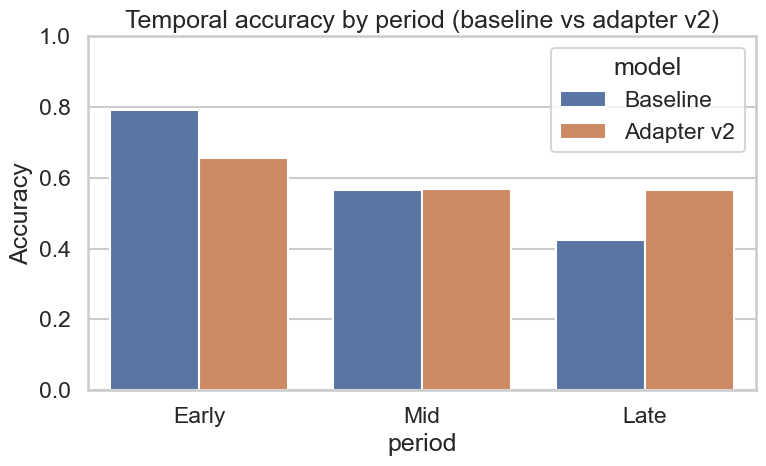

Saved: processed\adapter_experiment_v2\plots\temporal_accuracy_bar_from_period.png


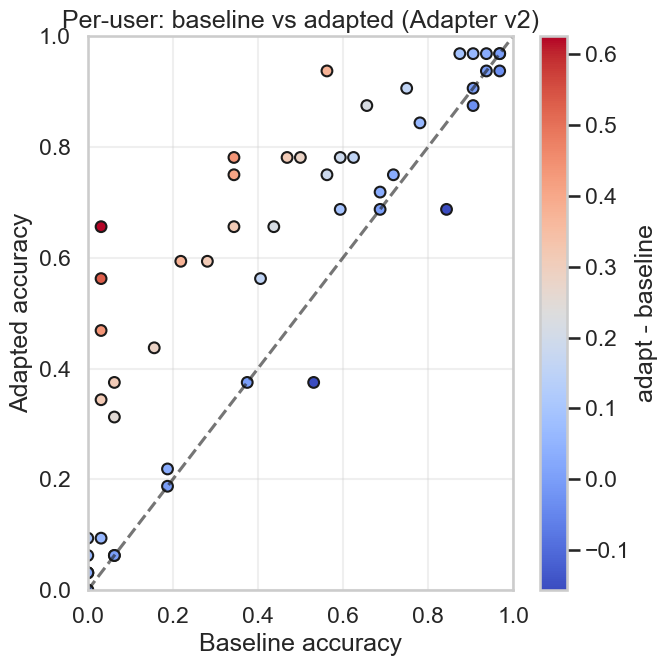

Saved: processed\adapter_experiment_v2\plots\per_user_scatter_baseline_vs_adapted.png


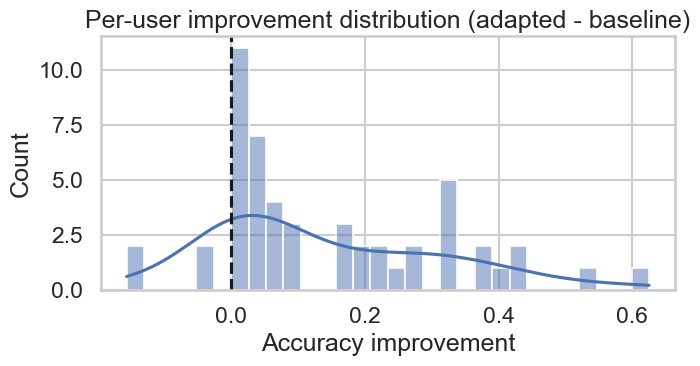

Saved: processed\adapter_experiment_v2\plots\improvement_histogram.png


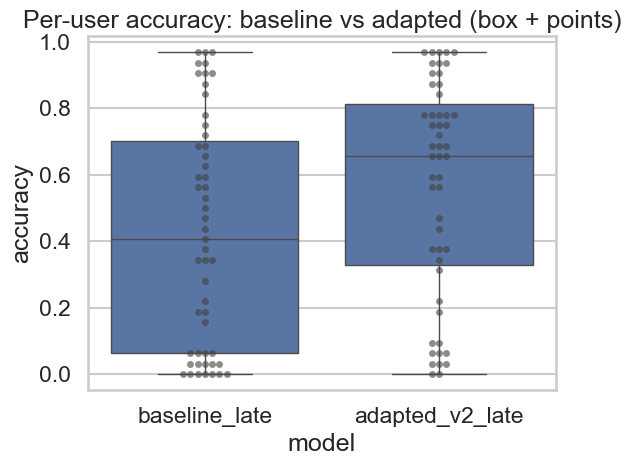

Saved: processed\adapter_experiment_v2\plots\per_user_boxplot.png
Paired t-test per-user: t=5.782, p=4.762e-07
Mean improvement: 0.14154411764705882

Done — check saved plots in processed\adapter_experiment_v2\plots


In [99]:
# Plots: temporal bar, per-user scatter, improvement histogram, and boxplot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='talk')

# reload dataframes if not in memory
if 'df_temporal' not in globals() or df_temporal is None:
    try:
        df_temporal = pd.read_csv(files['temporal'])
    except Exception as e:
        df_temporal = None
        print('Could not load temporal CSV:', e)

if 'df_per_user' not in globals() or df_per_user is None:
    try:
        df_per_user = pd.read_csv(files['per_user'])
    except Exception as e:
        df_per_user = None
        print('Could not load per_user CSV:', e)

# Helper to find baseline/adapt columns in per-user or temporal tables

def find_base_adapt_cols(df):
    base = None
    adapt = None
    for c in df.columns:
        if base is None and ('baseline' in c.lower() or c.lower().startswith('base')):
            base = c
        if adapt is None and ('adapt' in c.lower() or 'adapted' in c.lower() or 'v2' in c.lower()):
            adapt = c
    return base, adapt

# 1) Temporal accuracy by window (grouped bar)
if df_temporal is not None:
    if 'model' in df_temporal.columns and 'window' in df_temporal.columns:
        acc_col = None
        for c in ['accuracy', 'acc', 'mean_accuracy', 'mean_acc']:
            if c in df_temporal.columns:
                acc_col = c
                break
        if acc_col:
            plt.figure(figsize=(8, 5))
            sns.barplot(data=df_temporal, x='window', y=acc_col, hue='model', ci='sd')
            plt.title('Temporal accuracy by window (baseline vs adapter v2)')
            plt.ylabel('Accuracy')
            plt.ylim(0, 1)
            fname = os.path.join(plots_dir, 'temporal_accuracy_bar.png')
            plt.tight_layout()
            plt.savefig(fname, dpi=200)
            plt.show()
            print('Saved:', fname)
        else:
            print('Temporal DF has model/window but no accuracy column.')

    elif 'period' in df_temporal.columns:
        # detect baseline/adapt columns
        bcol, acol = find_base_adapt_cols(df_temporal)
        if bcol and acol:
            mdf = df_temporal.melt(id_vars='period', value_vars=[bcol, acol], var_name='model', value_name='accuracy')
            pretty_map = {bcol: 'Baseline', acol: 'Adapter v2'}
            mdf['model'] = mdf['model'].map(pretty_map)
            plt.figure(figsize=(8, 5))
            sns.barplot(data=mdf, x='period', y='accuracy', hue='model', ci='sd')
            plt.title('Temporal accuracy by period (baseline vs adapter v2)')
            plt.ylabel('Accuracy')
            plt.ylim(0, 1)
            fname = os.path.join(plots_dir, 'temporal_accuracy_bar_from_period.png')
            plt.tight_layout()
            plt.savefig(fname, dpi=200)
            plt.show()
            print('Saved:', fname)
        else:
            print('Temporal DF contains period but cannot detect baseline/adapt columns. Columns:', df_temporal.columns.tolist())
    else:
        print('Temporal DF structure not recognized. Columns:', df_temporal.columns.tolist())

# 2) Per-user baseline vs adapted scatter & hist & boxplot
if df_per_user is not None:
    bcol, acol = find_base_adapt_cols(df_per_user)
    if bcol and acol:
        df_per_user = df_per_user.copy()
        df_per_user['improvement'] = df_per_user[acol] - df_per_user[bcol]

        plt.figure(figsize=(7, 7))
        sc = plt.scatter(df_per_user[bcol], df_per_user[acol],
                         c=df_per_user['improvement'], cmap='coolwarm', s=60, edgecolor='k')
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
        plt.xlabel('Baseline accuracy')
        plt.ylabel('Adapted accuracy')
        plt.title('Per-user: baseline vs adapted (Adapter v2)')
        cb = plt.colorbar(sc)
        cb.set_label('adapt - baseline')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        fname = os.path.join(plots_dir, 'per_user_scatter_baseline_vs_adapted.png')
        plt.tight_layout()
        plt.savefig(fname, dpi=200)
        plt.show()
        print('Saved:', fname)

        # Histogram of improvements
        plt.figure(figsize=(7, 4))
        sns.histplot(df_per_user['improvement'], bins=30, kde=True)
        plt.axvline(0, color='k', linestyle='--')
        plt.title('Per-user improvement distribution (adapted - baseline)')
        plt.xlabel('Accuracy improvement')
        fname = os.path.join(plots_dir, 'improvement_histogram.png')
        plt.tight_layout()
        plt.savefig(fname, dpi=200)
        plt.show()
        print('Saved:', fname)

        # Boxplot comparison (baseline vs adapted)
        mdf = df_per_user[[bcol, acol]].melt(var_name='model', value_name='accuracy')
        plt.figure(figsize=(6, 5))
        sns.boxplot(data=mdf, x='model', y='accuracy')
        sns.swarmplot(data=mdf, x='model', y='accuracy', color='0.25', alpha=0.6)
        plt.title('Per-user accuracy: baseline vs adapted (box + points)')
        fname = os.path.join(plots_dir, 'per_user_boxplot.png')
        plt.tight_layout()
        plt.savefig(fname, dpi=200)
        plt.show()
        print('Saved:', fname)

        # Paired t-test on per-user accuracies
        t, p = stats.ttest_rel(df_per_user[acol], df_per_user[bcol], nan_policy='omit')
        print(f"Paired t-test per-user: t={t:.3f}, p={p:.3e}")
        print('Mean improvement:', df_per_user['improvement'].mean())

    else:
        print('Per-user DF does not contain detectable baseline/adapt columns. Columns:', df_per_user.columns.tolist())

else:
    print('\nPer-user plots skipped because per-user dataframe is not available.')

print('\nDone — check saved plots in', plots_dir)

Found keys: ['y_true', 'baseline_pred', 'adapted_pred']
Overall accuracy - Baseline: 0.5856, Adapter v2: 0.5769

Per-user overall mean baseline acc: 0.5856004901960784
Per-user overall mean adapted acc: 0.5768995098039215
Mean per-user overall improvement: -0.008700980392156868
Paired t-test overall per-user: t=-0.709, p=4.816e-01


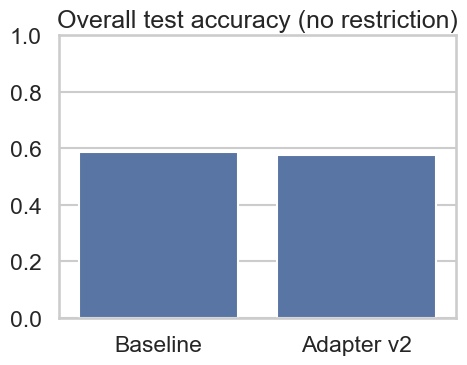

Saved: processed\adapter_experiment_v2\plots\overall_accuracy_bar.png


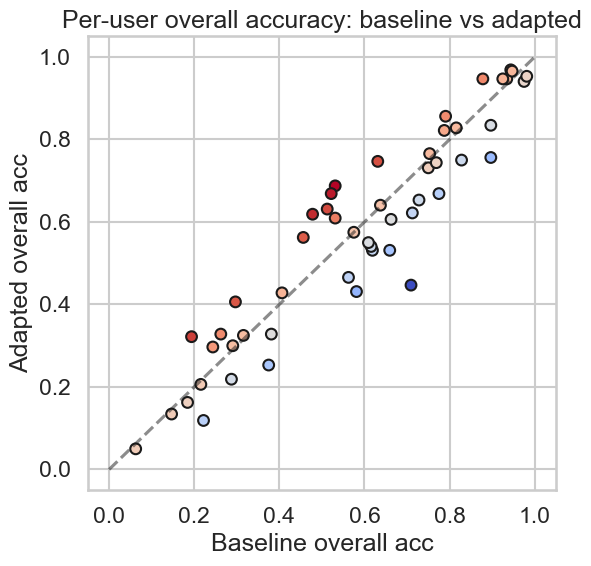

Saved: processed\adapter_experiment_v2\plots\per_user_overall_scatter.png


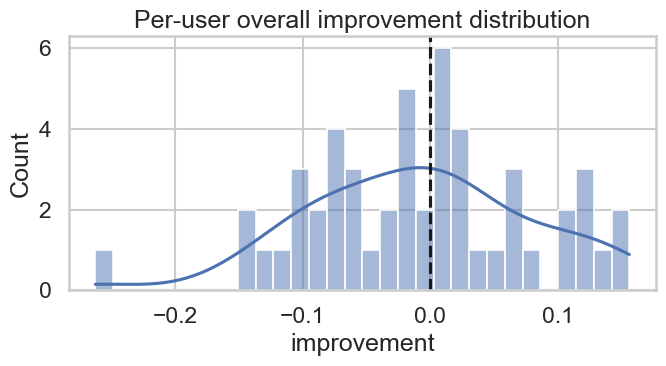

Saved: processed\adapter_experiment_v2\plots\per_user_overall_improvement_hist.png
Saved per-user overall comparison to: processed\adapter_experiment_v2\per_user_overall_comparison.csv


In [100]:
# Compute full (no SAME_USER_TEST_FRACTION restriction) overall test accuracy: baseline vs adapted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

# Try several possible variable names for preds/true
ctx = globals()
possible = {
    'y_true': ['y_true_all', 'y_true', 'y_true_v2', 'y_true_pool'],
    'baseline_pred': ['y_pred', 'y_pred_all', 'base_preds', 'y_pred_b'],
    'adapted_pred': ['y_pred_a', 'y_pred_v2', 'adapt_preds', 'y_pred_adapted']
}

found = {}
for k, names in possible.items():
    for n in names:
        if n in ctx:
            found[k] = ctx[n]
            break

print('Found keys:', list(found.keys()))

if 'y_true' in found and 'baseline_pred' in found and 'adapted_pred' in found:
    ytrue = np.asarray(found['y_true'])
    yb = np.asarray(found['baseline_pred'])
    ya = np.asarray(found['adapted_pred'])
    # ensure same length
    L = min(len(ytrue), len(yb), len(ya))
    ytrue = ytrue[:L]
    yb = yb[:L]
    ya = ya[:L]
    overall_base_acc = (yb == ytrue).mean()
    overall_adapt_acc = (ya == ytrue).mean()
    print(f'Overall accuracy - Baseline: {overall_base_acc:.4f}, Adapter v2: {overall_adapt_acc:.4f}')

    # Per-user overall accuracies if mapping available
    if 'test_subjects' in ctx:
        subjects = np.asarray(ctx['test_subjects'])[:L]
        unique_subs = np.unique(subjects)
        rows = []
        for s in unique_subs:
            mask = subjects == s
            if mask.sum() == 0: continue
            rows.append({
                'subject': s,
                'baseline_overall': (yb[mask] == ytrue[mask]).mean(),
                'adapted_overall': (ya[mask] == ytrue[mask]).mean()
            })
        df_over = pd.DataFrame(rows)
        df_over['improvement'] = df_over['adapted_overall'] - df_over['baseline_overall']
        print('\nPer-user overall mean baseline acc:', df_over['baseline_overall'].mean())
        print('Per-user overall mean adapted acc:', df_over['adapted_overall'].mean())
        print('Mean per-user overall improvement:', df_over['improvement'].mean())
        t, p = stats.ttest_rel(df_over['adapted_overall'], df_over['baseline_overall'], nan_policy='omit')
        print(f'Paired t-test overall per-user: t={t:.3f}, p={p:.3e}')

        # Plot overall bar
        plt.figure(figsize=(5,4))
        sns.barplot(x=['Baseline', 'Adapter v2'], y=[overall_base_acc, overall_adapt_acc])
        plt.ylim(0,1)
        plt.title('Overall test accuracy (no restriction)')
        fname = os.path.join(plots_dir, 'overall_accuracy_bar.png')
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
        print('Saved:', fname)

        # Per-user scatter overall
        plt.figure(figsize=(6,6))
        plt.scatter(df_over['baseline_overall'], df_over['adapted_overall'], c=df_over['improvement'], cmap='coolwarm', s=60, edgecolor='k')
        plt.plot([0,1],[0,1],'k--', alpha=0.5)
        plt.xlabel('Baseline overall acc'); plt.ylabel('Adapted overall acc')
        plt.title('Per-user overall accuracy: baseline vs adapted')
        fname = os.path.join(plots_dir, 'per_user_overall_scatter.png')
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
        print('Saved:', fname)

        # Histogram of per-user overall improvements
        plt.figure(figsize=(7,4))
        sns.histplot(df_over['improvement'], bins=30, kde=True)
        plt.axvline(0, color='k', linestyle='--')
        plt.title('Per-user overall improvement distribution')
        fname = os.path.join(plots_dir, 'per_user_overall_improvement_hist.png')
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
        print('Saved:', fname)

        # Save df_over to CSV
        df_over.to_csv(os.path.join(adapt_v2_dir, 'per_user_overall_comparison.csv'), index=False)
        print('Saved per-user overall comparison to:', os.path.join(adapt_v2_dir, 'per_user_overall_comparison.csv'))

    else:
        print('test_subjects mapping not found in kernel; cannot compute per-user overall accuracies.')

else:
    print('Required prediction arrays not found in globals. Please ensure baseline and adapted predictions and y_true are available as variables (e.g., y_true_all, y_pred_all, y_pred_v2).')


Overall accuracies (no restriction):
  Baseline: 0.5856
  Adapter v2: 0.5769
  Per-user best-choice: 0.6157
  Hybrid (adapt late only): 0.5776
  Oracle (per-sample): 0.6516
Saved deployment_sim_summary.json


C:\Users\sayed\AppData\Local\Temp\ipykernel_18868\2859007695.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=items, y=vals, palette='muted')


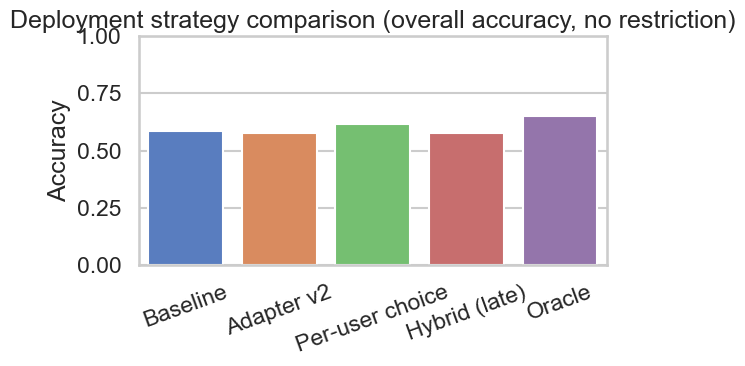

Saved: processed\adapter_experiment_v2\plots\deployment_strategy_comparison.png


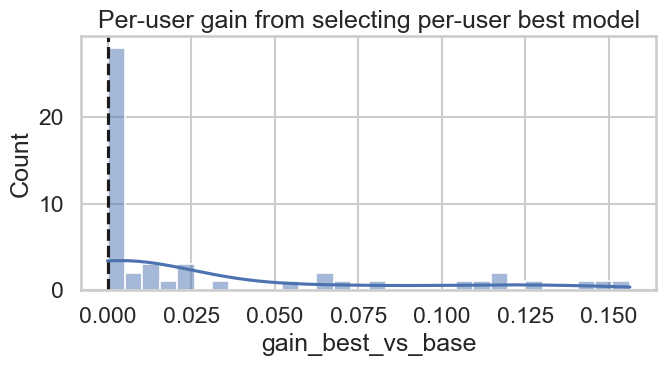

Saved: processed\adapter_experiment_v2\plots\per_user_selection_gain_hist.png
Saved per_user_selection_gains.csv


In [103]:
# Simulate deployment strategies and compare overall (no restriction) accuracies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

# Ensure we have the predictions and subject mapping
ytrue = globals().get('y_true', None)
yb = globals().get('y_pred', None) or globals().get('y_pred_all', None) or globals().get('base_preds', None)
ya = globals().get('y_pred_a', None) or globals().get('y_pred_v2', None) or globals().get('adapt_preds', None)
subjects = globals().get('test_subjects', None)

if ytrue is None or yb is None or ya is None or subjects is None:
    print('Missing required arrays; ensure y_true, y_pred (baseline), y_pred_a (adapted), and test_subjects are present in kernel.')
else:
    ytrue = np.asarray(ytrue)
    yb = np.asarray(yb)
    ya = np.asarray(ya)
    subj = np.asarray(subjects)
    L = min(len(ytrue), len(yb), len(ya), len(subj))
    ytrue = ytrue[:L]
    yb = yb[:L]
    ya = ya[:L]
    subj = subj[:L]

    # Per-user best-selection (choose model with higher overall accuracy for that user)
    unique = np.unique(subj)
    best_choice_preds = np.empty(L, dtype=yb.dtype)
    best_choice_preds[:] = yb
    for u in unique:
        idx = np.where(subj == u)[0]
        if idx.size == 0: continue
        base_acc = (yb[idx] == ytrue[idx]).mean()
        adapt_acc = (ya[idx] == ytrue[idx]).mean()
        if adapt_acc > base_acc:
            best_choice_preds[idx] = ya[idx]
        else:
            best_choice_preds[idx] = yb[idx]
    best_choice_acc = (best_choice_preds == ytrue).mean()

    # Hybrid per-window: use adapted for 'late' positions only, baseline otherwise
    # Prefer existing mask if available
    late_mask = globals().get('mask_late_v2')
    if late_mask is None:
        late_mask = globals().get('mask_late')
    if late_mask is None or len(late_mask) != L:
        # fallback: compute last third per user as late
        late_mask = np.zeros(L, dtype=bool)
        for u in unique:
            idx = np.where(subj == u)[0]
            if idx.size == 0: continue
            k = idx.size
            late_mask[idx[int(2*k/3):]] = True

    hybrid_preds = np.where(late_mask, ya, yb)
    hybrid_acc = (hybrid_preds == ytrue).mean()

    # Oracle (per-sample best) - upper bound
    oracle_preds = np.where(ya == ytrue, ya, yb)  # if adapt correct use it else baseline
    oracle_acc = (oracle_preds == ytrue).mean()

    print(f"Overall accuracies (no restriction):\n  Baseline: {(yb==ytrue).mean():.4f}\n  Adapter v2: {(ya==ytrue).mean():.4f}\n  Per-user best-choice: {best_choice_acc:.4f}\n  Hybrid (adapt late only): {hybrid_acc:.4f}\n  Oracle (per-sample): {oracle_acc:.4f}")

    # Save a small summary
    summ = {
        'baseline': float((yb==ytrue).mean()),
        'adapted': float((ya==ytrue).mean()),
        'per_user_choice': float(best_choice_acc),
        'hybrid_adapt_late': float(hybrid_acc),
        'oracle': float(oracle_acc)
    }
    with open(os.path.join(adapt_v2_dir, 'deployment_sim_summary.json'), 'w') as f:
        import json
        json.dump(summ, f, indent=2)
    print('Saved deployment_sim_summary.json')

    # Plot comparison bar
    plt.figure(figsize=(6,4))
    items = ['Baseline', 'Adapter v2', 'Per-user choice', 'Hybrid (late)', 'Oracle']
    vals = [summ['baseline'], summ['adapted'], summ['per_user_choice'], summ['hybrid_adapt_late'], summ['oracle']]
    sns.barplot(x=items, y=vals, palette='muted')
    plt.ylim(0,1)
    plt.ylabel('Accuracy')
    plt.title('Deployment strategy comparison (overall accuracy, no restriction)')
    plt.xticks(rotation=20)
    fname = os.path.join(plots_dir, 'deployment_strategy_comparison.png')
    plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
    print('Saved:', fname)

    # Per-user improvement histogram for per-user-choice (benefit of selection)
    df_sel = pd.DataFrame({'subject': unique})
    base_list = []
    adapt_list = []
    for u in unique:
        idx = np.where(subj == u)[0]
        base_list.append((yb[idx] == ytrue[idx]).mean())
        adapt_list.append((ya[idx] == ytrue[idx]).mean())
    df_sel['base'] = base_list
    df_sel['adapt'] = adapt_list
    df_sel['best_choice'] = df_sel[['base','adapt']].max(axis=1)
    df_sel['gain_best_vs_base'] = df_sel['best_choice'] - df_sel['base']

    plt.figure(figsize=(7,4))
    sns.histplot(df_sel['gain_best_vs_base'], bins=30, kde=True)
    plt.axvline(0, color='k', linestyle='--')
    plt.title('Per-user gain from selecting per-user best model')
    fname = os.path.join(plots_dir, 'per_user_selection_gain_hist.png')
    plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
    print('Saved:', fname)

    # Save df_sel
    df_sel.to_csv(os.path.join(adapt_v2_dir, 'per_user_selection_gains.csv'), index=False)
    print('Saved per_user_selection_gains.csv')

In [ ]:
### Authentication metrics: Mid and Late period comparison
This cell computes authentication metrics (TAR, FRR, FAR, TRR) for the **Mid** and **Late** periods only and compares **Baseline** vs **Adapter v2** results. It produces pooled and per-user tables and saves visualizations to `processed/adapter_experiment_v2/plots/`.


,period,model,macro_TAR,macro_FRR,macro_FAR,macro_TRR,pooled_TAR,pooled_FRR,pooled_FAR,pooled_TRR
0,Mid,Baseline,0.5607,0.4393,0.0,1.0,0.5607,0.4393,0.0,1.0
1,Mid,Adapter v2,0.5548,0.4452,0.0,1.0,0.5548,0.4452,0.0,1.0
2,Late,Baseline,0.4832,0.5168,0.0,1.0,0.4832,0.5168,0.0,1.0
3,Late,Adapter v2,0.4592,0.5408,0.0,1.0,0.4592,0.5408,0.0,1.0


<Figure size 600x400 with 0 Axes>

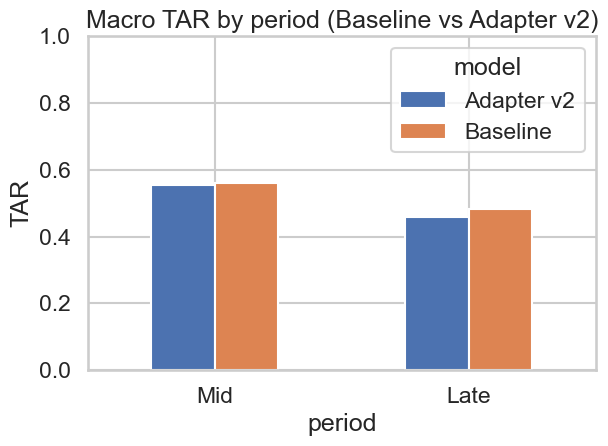

Saved: processed\adapter_experiment_v2\plots\macro_TAR_mid_late_comparison.png


<Figure size 600x400 with 0 Axes>

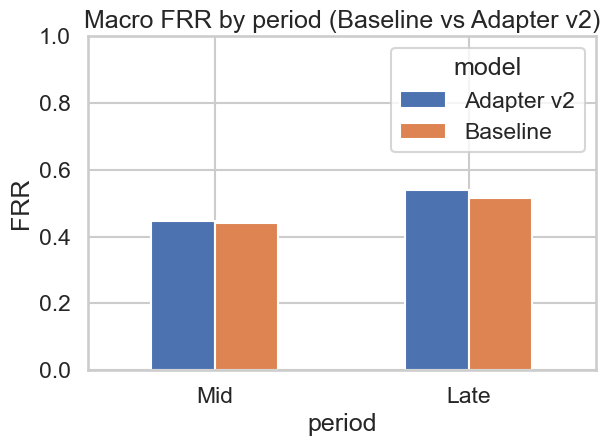

Saved: processed\adapter_experiment_v2\plots\macro_FRR_mid_late_comparison.png


<Figure size 600x400 with 0 Axes>

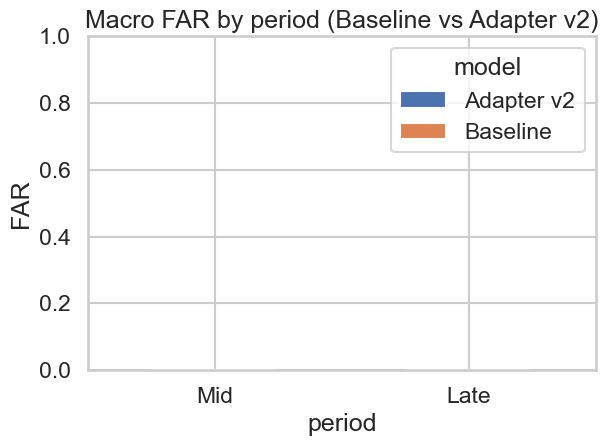

Saved: processed\adapter_experiment_v2\plots\macro_FAR_mid_late_comparison.png


<Figure size 600x400 with 0 Axes>

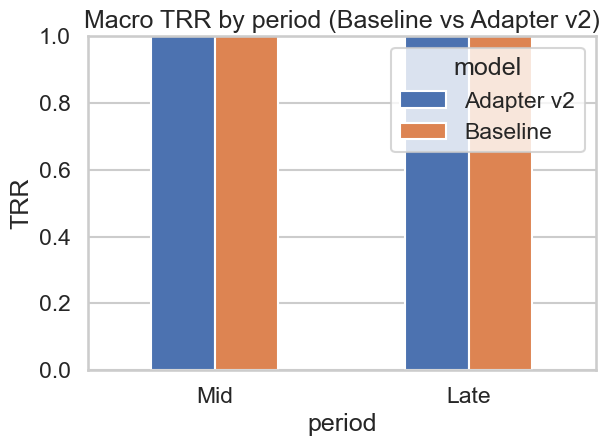

Saved: processed\adapter_experiment_v2\plots\macro_TRR_mid_late_comparison.png


<Figure size 600x400 with 0 Axes>

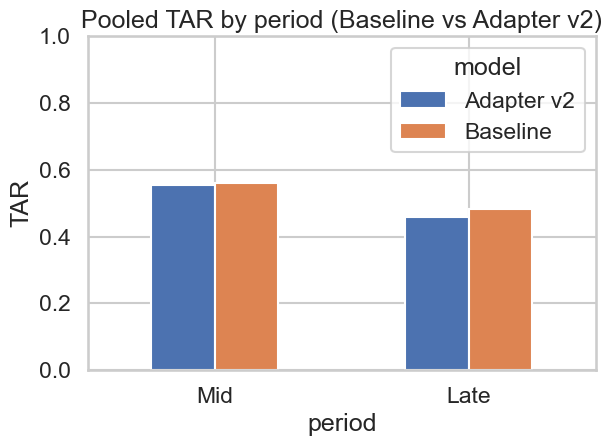

Saved: processed\adapter_experiment_v2\plots\pooled_TAR_mid_late_comparison.png


<Figure size 600x400 with 0 Axes>

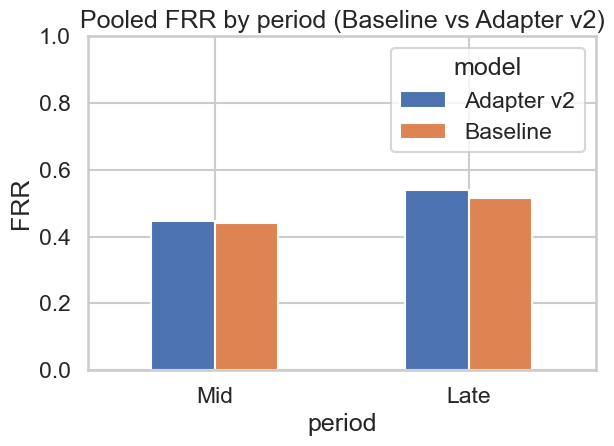

Saved: processed\adapter_experiment_v2\plots\pooled_FRR_mid_late_comparison.png


<Figure size 600x400 with 0 Axes>

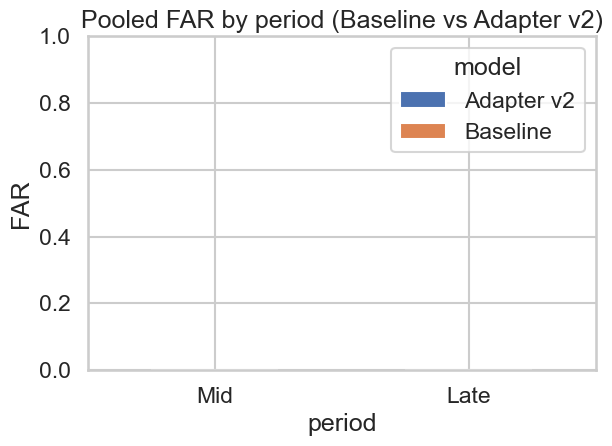

Saved: processed\adapter_experiment_v2\plots\pooled_FAR_mid_late_comparison.png


<Figure size 600x400 with 0 Axes>

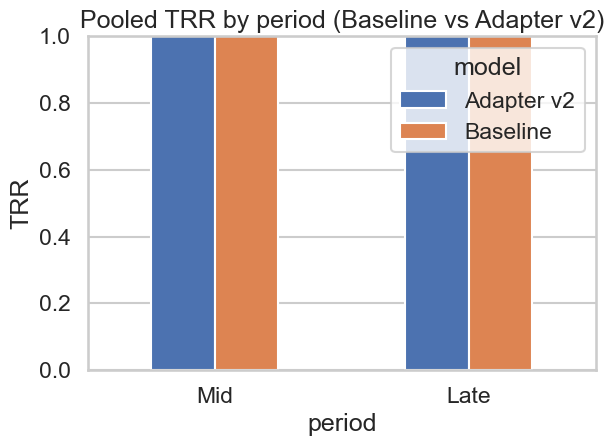

Saved: processed\adapter_experiment_v2\plots\pooled_TRR_mid_late_comparison.png


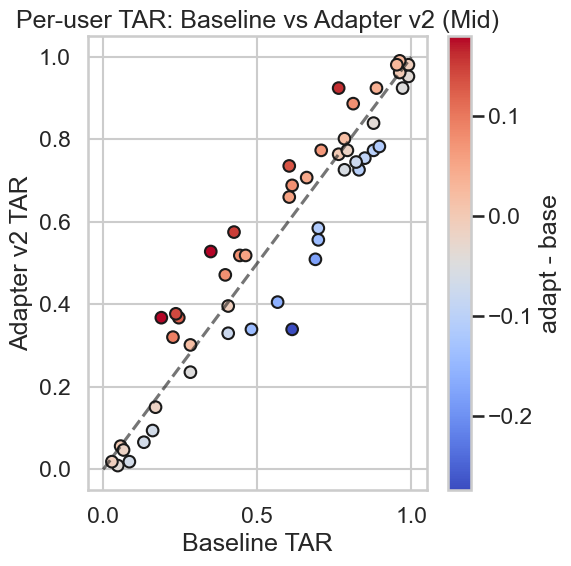

Saved: processed\adapter_experiment_v2\plots\per_user_TAR_scatter_Mid.png


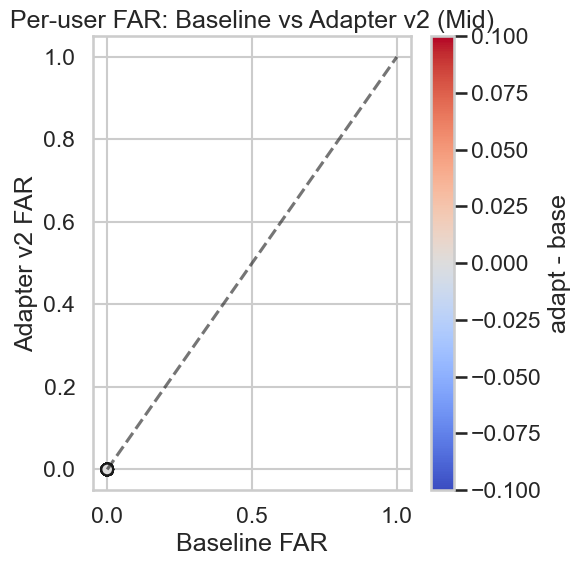

Saved: processed\adapter_experiment_v2\plots\per_user_FAR_scatter_Mid.png


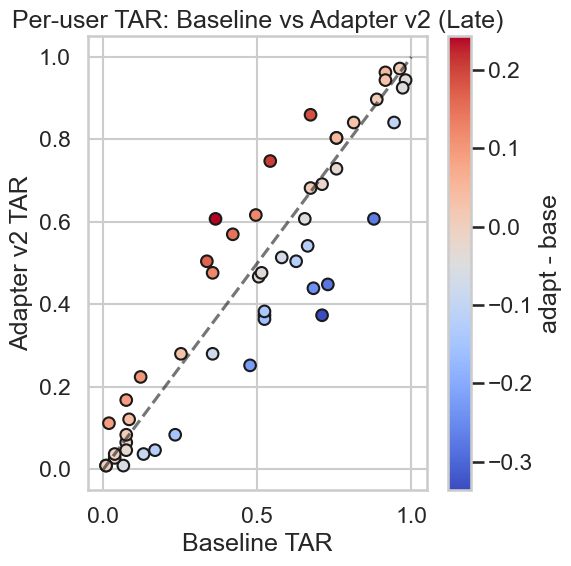

Saved: processed\adapter_experiment_v2\plots\per_user_TAR_scatter_Late.png


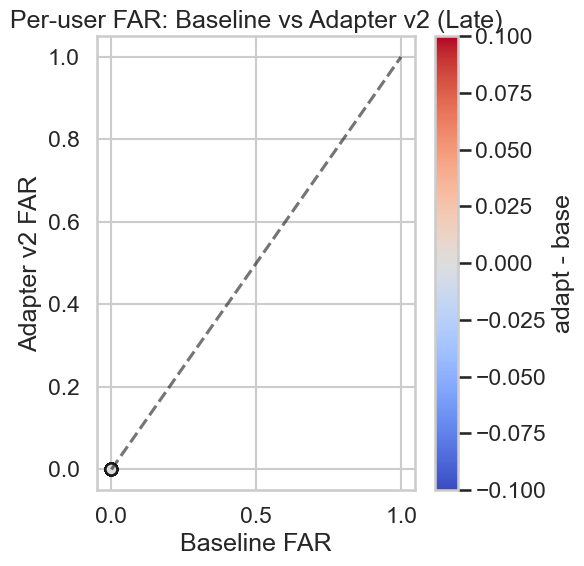

Saved: processed\adapter_experiment_v2\plots\per_user_FAR_scatter_Late.png
Saved summary CSV to processed\adapter_experiment_v2\auth_metrics_by_period\macro_pooled_auth_comparison_mid_late.csv

Done — authentication metrics and plots saved for Mid and Late periods to processed\adapter_experiment_v2\auth_metrics_by_period


In [104]:
# Compute TAR/FRR/FAR/TRR for Mid and Late periods (pooled and per-user)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

# Load predictions/labels from kernel (fallbacks similar to earlier cells)
ytrue = globals().get('y_true', None)
yb = globals().get('y_pred', None) or globals().get('y_pred_all', None) or globals().get('base_preds', None)
ya = globals().get('y_pred_a', None) or globals().get('y_pred_v2', None) or globals().get('adapt_preds', None)
subjects = globals().get('test_subjects', None)

if ytrue is None or yb is None or ya is None or subjects is None:
    print('Missing required arrays; ensure y_true, y_pred (baseline), y_pred_a (adapted), and test_subjects are present in kernel.')
else:
    ytrue = np.asarray(ytrue)
    yb = np.asarray(yb)
    ya = np.asarray(ya)
    subj = np.asarray(subjects)
    L = min(len(ytrue), len(yb), len(ya), len(subj))
    ytrue = ytrue[:L]
    yb = yb[:L]
    ya = ya[:L]
    subj = subj[:L]

    # Build per-sample period masks (early/mid/late) per-user (fallback if built masks not available)
    def build_period_masks(subj_arr):
        n = len(subj_arr)
        early = np.zeros(n, dtype=bool)
        mid = np.zeros(n, dtype=bool)
        late = np.zeros(n, dtype=bool)
        for u in np.unique(subj_arr):
            idx = np.where(subj_arr == u)[0]
            k = len(idx)
            if k == 0:
                continue
            e_end = int(np.ceil(k/3))
            l_start = int(np.floor(2*k/3))
            early[idx[:e_end]] = True
            mid[idx[e_end:l_start]] = True
            late[idx[l_start:]] = True
        return {'Early': early, 'Mid': mid, 'Late': late}

    # Prefer existing masks if available and correct length
    masks = {}
    for key in ['mid', 'late']:
        # kernel masks may be boolean arrays named mask_mid_v2 / mask_mid
        m = globals().get(f'mask_{key}_v2')
        if m is None:
            m = globals().get(f'mask_{key}')
        if isinstance(m, np.ndarray) and len(m) == L:
            if key == 'mid': masks['Mid'] = m
            if key == 'late': masks['Late'] = m
    # If not present, build masks
    missing = [k for k in ['Mid', 'Late'] if k not in masks]
    if missing:
        built = build_period_masks(subj)
        for k in missing:
            masks[k] = built[k]

    def compute_auth_metrics_for_mask(y_true_arr, y_pred_arr, subj_arr, mask):
        # Compute per-user TP/FP/TN/FN counts and per-user rates
        users = np.unique(subj_arr[mask])
        rows = []
        pooled = {'TP':0, 'FP':0, 'TN':0, 'FN':0}
        for u in users:
            idx = np.where((subj_arr == u) & mask)[0]
            if idx.size == 0: continue
            # For claimed user u: genuine samples = idx
            tp = np.sum(y_pred_arr[idx] == y_true_arr[idx])  # predicted equals true means accepted when genuine
            fn = np.sum(y_pred_arr[idx] != y_true_arr[idx])
            # impostor samples: test samples not from u but predicted as u
            impostor_idx = np.where((subj_arr != u) & mask)[0]
            fp = np.sum(y_pred_arr[impostor_idx] == u)
            tn = np.sum(y_pred_arr[impostor_idx] != u)
            pooled['TP'] += tp
            pooled['FP'] += fp
            pooled['TN'] += tn
            pooled['FN'] += fn
            tar = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            frr = fn / (tp + fn) if (tp + fn) > 0 else np.nan
            far = fp / (fp + tn) if (fp + tn) > 0 else np.nan
            trr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
            rows.append({'subject': u, 'TP':tp, 'FN':fn, 'FP':fp, 'TN':tn, 'TAR':tar, 'FRR':frr, 'FAR':far, 'TRR':trr})
        per_user_df = pd.DataFrame(rows)
        # macro averages (mean across users) and pooled rates
        macro = per_user_df[['TAR','FRR','FAR','TRR']].mean()
        pooled_rates = {}
        if (pooled['TP'] + pooled['FN']) > 0:
            pooled_rates['TAR'] = pooled['TP'] / (pooled['TP'] + pooled['FN'])
            pooled_rates['FRR'] = pooled['FN'] / (pooled['TP'] + pooled['FN'])
        else:
            pooled_rates['TAR'] = np.nan; pooled_rates['FRR'] = np.nan
        if (pooled['FP'] + pooled['TN']) > 0:
            pooled_rates['FAR'] = pooled['FP'] / (pooled['FP'] + pooled['TN'])
            pooled_rates['TRR'] = pooled['TN'] / (pooled['TN'] + pooled['FP'])
        else:
            pooled_rates['FAR'] = np.nan; pooled_rates['TRR'] = np.nan
        return per_user_df, macro.to_dict(), pooled_rates

    results = []
    per_user_results = {}
    for period in ['Mid', 'Late']:
        mask = masks[period]
        for model_name, preds in [('Baseline', yb), ('Adapter v2', ya)]:
            pu_df, macro, pooled = compute_auth_metrics_for_mask(ytrue, preds, subj, mask)
            results.append({'period':period, 'model':model_name, 'macro_TAR':macro['TAR'], 'macro_FRR':macro['FRR'], 'macro_FAR':macro['FAR'], 'macro_TRR':macro['TRR'], 'pooled_TAR':pooled['TAR'], 'pooled_FRR':pooled['FRR'], 'pooled_FAR':pooled['FAR'], 'pooled_TRR':pooled['TRR']})
            per_user_results[(period, model_name)] = pu_df

    res_df = pd.DataFrame(results)
    display(res_df.round(4))

    # Save per-user CSVs
    outdir = os.path.join(adapt_v2_dir, 'auth_metrics_by_period')
    os.makedirs(outdir, exist_ok=True)
    for (period, model), dfp in per_user_results.items():
        dfp.to_csv(os.path.join(outdir, f'per_user_auth_{period}_{model.replace(" ","_")}.csv'), index=False)

    # Plot macro (mean over users) comparison for each metric (bars grouped by period)
    metrics = ['TAR','FRR','FAR','TRR']
    for m in metrics:
        plt.figure(figsize=(6,4))
        tmp = res_df.pivot(index='period', columns='model', values=f'macro_{m}').reindex(['Mid','Late'])
        tmp.plot(kind='bar', rot=0)
        plt.ylim(0,1)
        plt.title(f'Macro {m} by period (Baseline vs Adapter v2)')
        plt.ylabel(m)
        fname = os.path.join(plots_dir, f'macro_{m}_mid_late_comparison.png')
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
        print('Saved:', fname)

    # Also plot pooled rates
    for m in ['TAR','FRR','FAR','TRR']:
        plt.figure(figsize=(6,4))
        tmp2 = res_df.pivot(index='period', columns='model', values=f'pooled_{m}').reindex(['Mid','Late'])
        tmp2.plot(kind='bar', rot=0)
        plt.ylim(0,1)
        plt.title(f'Pooled {m} by period (Baseline vs Adapter v2)')
        plt.ylabel(m)
        fname = os.path.join(plots_dir, f'pooled_{m}_mid_late_comparison.png')
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
        print('Saved:', fname)

    # Per-user scatter: compare baseline vs adapted per-user TAR for Mid and Late
    for period in ['Mid','Late']:
        df_b = per_user_results[(period, 'Baseline')].set_index('subject')
        df_a = per_user_results[(period, 'Adapter v2')].set_index('subject')
        joined = df_b[['TAR','FAR']].join(df_a[['TAR','FAR']], lsuffix='_base', rsuffix='_adapt', how='inner')
        if joined.shape[0] == 0:
            print('No per-user rows for period', period)
            continue
        for metric in ['TAR','FAR']:
            plt.figure(figsize=(6,6))
            sc = plt.scatter(joined[f'{metric}_base'], joined[f'{metric}_adapt'], c=(joined[f'{metric}_adapt']-joined[f'{metric}_base']), cmap='coolwarm', s=70, edgecolor='k')
            plt.plot([0,1],[0,1],'k--', alpha=0.6)
            plt.xlabel(f'Baseline {metric}'); plt.ylabel(f'Adapter v2 {metric}')
            plt.title(f'Per-user {metric}: Baseline vs Adapter v2 ({period})')
            cb = plt.colorbar(sc); cb.set_label('adapt - base')
            fname = os.path.join(plots_dir, f'per_user_{metric}_scatter_{period}.png')
            plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
            print('Saved:', fname)

    # Save summary res_df
    res_df.to_csv(os.path.join(outdir, 'macro_pooled_auth_comparison_mid_late.csv'), index=False)
    print('Saved summary CSV to', os.path.join(outdir, 'macro_pooled_auth_comparison_mid_late.csv'))

print('\nDone — authentication metrics and plots saved for Mid and Late periods to', outdir)


In [ ]:
# Paired tests on per-user TAR and Wilcoxon; score-based EER/FAR/FRR if probability arrays available
import json
from scipy import stats
from sklearn.metrics import roc_curve

outdir = os.path.join(adapt_v2_dir, 'auth_metrics_by_period')
os.makedirs(outdir, exist_ok=True)

# Load per-user TAR CSVs produced earlier
def load_per_user_tar(period, model):
    p = os.path.join(outdir, f'per_user_auth_{period}_{model.replace(" ","_")}.csv')
    if os.path.exists(p):
        df = pd.read_csv(p)
        if 'TAR' in df.columns:
            return df[['subject','TAR']].set_index('subject')
    return None

results_tests = {}
for period in ['Mid','Late']:
    df_b = load_per_user_tar(period, 'Baseline')
    df_a = load_per_user_tar(period, 'Adapter v2')
    if df_b is None or df_a is None:
        print('Missing per-user TAR CSV for', period)
        continue
    joined = df_b.join(df_a, how='inner', lsuffix='_base', rsuffix='_adapt').dropna()
    base = joined['TAR_base'].values
    adapt = joined['TAR_adapt'].values
    diff = adapt - base
    # Paired t-test
    t, p_t = stats.ttest_rel(adapt, base, nan_policy='omit')
    # Wilcoxon signed-rank test (two-sided)
    try:
        w_stat, p_w = stats.wilcoxon(adapt, base, zero_method='wilcox', alternative='two-sided')
    except Exception as e:
        w_stat, p_w = np.nan, np.nan
    mean_diff = np.nanmean(diff)
    std_diff = np.nanstd(diff, ddof=1)
    cohen_d = mean_diff / std_diff if std_diff>0 else np.nan
    results_tests[period] = {
        'n_users': len(joined),
        'mean_diff': float(mean_diff),
        'std_diff': float(std_diff),
        't_stat': float(t), 'p_t': float(p_t),
        'wilcoxon_stat': float(w_stat) if not np.isnan(w_stat) else None, 'p_wilcoxon': float(p_w) if not np.isnan(p_w) else None,
        'cohen_d': float(cohen_d)
    }
    print(f"{period} paired t-test: t={t:.3f}, p={p_t:.3e}; Wilcoxon p={p_w:.3e}; mean_diff={mean_diff:.4f}")
    # Boxplot with p-value annotation
    plt.figure(figsize=(5,4))
    df_plot = joined.reset_index().melt(id_vars='subject', value_vars=['TAR_base','TAR_adapt'], var_name='model', value_name='TAR')
    df_plot['model'] = df_plot['model'].map({'TAR_base':'Baseline','TAR_adapt':'Adapter v2'})
    sns.boxplot(data=df_plot, x='model', y='TAR')
    sns.swarmplot(data=df_plot, x='model', y='TAR', color='0.25')
    plt.title(f'Per-user TAR comparison ({period})\npaired t p={p_t:.3e}, wilcoxon p={p_w:.3e}')
    fname = os.path.join(outdir, f'paired_tar_box_{period}.png')
    plt.ylim(0,1)
    plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
    print('Saved:', fname)

# Save tests
with open(os.path.join(outdir, 'paired_tar_tests_mid_late.json'), 'w') as f:
    json.dump(results_tests, f, indent=2)
print('Saved paired test results to', os.path.join(outdir, 'paired_tar_tests_mid_late.json'))

# Score-based EER/FAR/FRR per-user per-period if probability arrays available
# Look for candidate score arrays
score_candidates = {
    'baseline_scores': globals().get('y_probs') or globals().get('y_probs_all') or globals().get('probs') or None,
    'adapted_scores': globals().get('y_probs_a') or globals().get('y_probs_v2') or globals().get('probs_adapt') or None
}

score_results = {}
if score_candidates['baseline_scores'] is None or score_candidates['adapted_scores'] is None:
    print('Score arrays not found for both baseline and adapted; skipping score-based EER/FAR computation.')
else:
    sb = np.asarray(score_candidates['baseline_scores'])
    sa = np.asarray(score_candidates['adapted_scores'])
    # handle case where scores are 2D (N, C) -> we need per-user class indices mapping
    # If scores are 2D and columns equal to unique subjects mapping order, we attempt to use that
    for period in ['Mid','Late']:
        mask = masks[period]
        per_user_eer = []
        for u in np.unique(subj[mask]):
            idx_g = np.where((subj==u) & mask)[0]
            idx_imp = np.where((subj!=u) & mask)[0]
            if len(idx_g)==0 or len(idx_imp)==0: continue
            # get per-sample score for user u
            def get_scores(scores_arr):
                if scores_arr.ndim == 2:
                    # try mapping subjects to column index via unique subjects order
                    unique_subs = np.unique(subj)
                    if len(unique_subs) == scores_arr.shape[1]:
                        col = list(unique_subs).index(u)
                        user_scores = scores_arr[:, col]
                    else:
                        # fallback: if scores are single-dim per sample, raise
                        user_scores = scores_arr.flatten()
                else:
                    user_scores = scores_arr.flatten()
                return user_scores
            scores_b = get_scores(sb)
            scores_a = get_scores(sa)
            # Build labels and compute ROC for baseline and adapted separately
            y_true_bin = np.concatenate([np.ones(len(idx_g)), np.zeros(len(idx_imp))])
            s_b = np.concatenate([scores_b[idx_g], scores_b[idx_imp]])
            s_a = np.concatenate([scores_a[idx_g], scores_a[idx_imp]])
            # ROC
            fpr_b, tpr_b, thr_b = roc_curve(y_true_bin, s_b)
            fnr_b = 1 - tpr_b
            # EER: where fpr ~= fnr
            eer_idx_b = np.nanargmin(np.abs(fpr_b - fnr_b))
            eer_b = (fpr_b[eer_idx_b] + fnr_b[eer_idx_b]) / 2.0
            thr_b_eer = thr_b[eer_idx_b]
            # compute FAR/FRR/TRR/TAR at EER threshold
            preds_b = (s_b >= thr_b_eer).astype(int)
            tp = np.sum((preds_b==1) & (y_true_bin==1))
            fn = np.sum((preds_b==0) & (y_true_bin==1))
            fp = np.sum((preds_b==1) & (y_true_bin==0))
            tn = np.sum((preds_b==0) & (y_true_bin==0))
            tar_b = tp / (tp+fn) if (tp+fn)>0 else np.nan
            frr_b = fn / (tp+fn) if (tp+fn)>0 else np.nan
            far_b = fp / (fp+tn) if (fp+tn)>0 else np.nan
            trr_b = tn / (tn+fp) if (tn+fp)>0 else np.nan

            # adapted
            fpr_a, tpr_a, thr_a = roc_curve(y_true_bin, s_a)
            fnr_a = 1 - tpr_a
            eer_idx_a = np.nanargmin(np.abs(fpr_a - fnr_a))
            eer_a = (fpr_a[eer_idx_a] + fnr_a[eer_idx_a]) / 2.0
            thr_a_eer = thr_a[eer_idx_a]
            preds_a = (s_a >= thr_a_eer).astype(int)
            tp = np.sum((preds_a==1) & (y_true_bin==1))
            fn = np.sum((preds_a==0) & (y_true_bin==1))
            fp = np.sum((preds_a==1) & (y_true_bin==0))
            tn = np.sum((preds_a==0) & (y_true_bin==0))
            tar_a = tp / (tp+fn) if (tp+fn)>0 else np.nan
            frr_a = fn / (tp+fn) if (tp+fn)>0 else np.nan
            far_a = fp / (fp+tn) if (fp+tn)>0 else np.nan
            trr_a = tn / (tn+fp) if (tn+fp)>0 else np.nan

            per_user_eer.append({'subject':u, 'baseline_eer':float(eer_b), 'baseline_tar':float(tar_b), 'baseline_far':float(far_b), 'baseline_frr':float(frr_b),
                                 'adapt_eer':float(eer_a), 'adapt_tar':float(tar_a), 'adapt_far':float(far_a), 'adapt_frr':float(frr_a)})
        score_results[period] = pd.DataFrame(per_user_eer)
        # Save per period
        score_results[period].to_csv(os.path.join(outdir, f'per_user_scores_eer_{period}.csv'), index=False)
        print('Saved score-based EER per-user CSV for', period)

    # Summarize and plot aggregate EER/TAR/FAR differences
    for period, df_sc in score_results.items():
        if df_sc.shape[0] == 0: continue
        df_sc['tar_diff'] = df_sc['adapt_tar'] - df_sc['baseline_tar']
        # paired t-test on tar
        t, p = stats.ttest_rel(df_sc['adapt_tar'], df_sc['baseline_tar'], nan_policy='omit')
        print(f"{period} score-based TAR paired t: t={t:.3f}, p={p:.3e}")
        # plot TAR scatter
        plt.figure(figsize=(6,6))
        sc = plt.scatter(df_sc['baseline_tar'], df_sc['adapt_tar'], c=df_sc['tar_diff'], cmap='coolwarm', edgecolor='k', s=60)
        plt.plot([0,1],[0,1],'k--', alpha=0.6)
        plt.xlabel('Baseline TAR'); plt.ylabel('Adapted TAR')
        plt.title(f'Score-based per-user TAR: Baseline vs Adapter v2 ({period})\npaired t p={p:.3e}')
        cb = plt.colorbar(sc); cb.set_label('adapt - base')
        fname = os.path.join(outdir, f'score_based_tar_scatter_{period}.png')
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()
        print('Saved:', fname)

    # Save score_results summary
    for k,v in score_results.items():
        if v is not None:
            v.to_csv(os.path.join(outdir, f'per_user_scores_summary_{k}.csv'), index=False)
    print('Saved all score-based summaries to', outdir)

print('\nAll done: paired tests and score-based EER/FAR computations (if data available).')


In [ ]:
# Paired statistical tests on per-user TAR/FRR/FAR for Mid and Late periods
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

outdir = os.path.join(adapt_v2_dir, 'auth_metrics_by_period')
plots_dir = os.path.join(adapt_v2_dir, 'plots')
os.makedirs(outdir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

periods = ['Mid', 'Late']
metrics = ['TAR', 'FRR', 'FAR', 'TRR']
summary_rows = []

for period in periods:
    # Load per-user files
    f_base = os.path.join(outdir, f'per_user_auth_{period}_Baseline.csv')
    f_adap = os.path.join(outdir, f'per_user_auth_{period}_Adapter_v2.csv')
    if not os.path.exists(f_base) or not os.path.exists(f_adap):
        print('Missing files for', period, f_base, f_adap)
        continue
    dfb = pd.read_csv(f_base).set_index('subject')
    dfa = pd.read_csv(f_adap).set_index('subject')
    joined = dfb.join(dfa, lsuffix='_base', rsuffix='_adapt', how='inner')
    # Ensure at least some users
    if joined.shape[0] == 0:
        print('No per-user rows for', period)
        continue
    for m in metrics:
        col_b = f'{m}_base' if f'{m}_base' in joined.columns else (m if m in joined.columns else None)
        col_a = f'{m}_adapt' if f'{m}_adapt' in joined.columns else (m if m in joined.columns else None)
        if col_b is None or col_a is None:
            print(f'Could not find columns for metric {m} in joined table for {period}')
            continue
        x = joined[col_b].astype(float)
        y = joined[col_a].astype(float)
        diff = y - x
        # Paired t-test (ignore NaNs)
        valid = (~np.isnan(x)) & (~np.isnan(y))
        nx = x[valid]
        ny = y[valid]
        nd = diff[valid]
        if len(nd) < 2:
            tstat, tp = np.nan, np.nan
            wstat, wp = np.nan, np.nan
            cohend = np.nan
            wilcoxon_z = np.nan
        else:
            ttest_res = stats.ttest_rel(ny, nx, nan_policy='omit')
            tstat = float(ttest_res.statistic)
            tp = float(ttest_res.pvalue)
            # Wilcoxon signed rank (two-sided)
            try:
                wstat, wp = stats.wilcoxon(nd)
                # compute approximate z for effect size r
                n = len(nd)
                mu_w = n*(n+1)/4
                sigma_w = np.sqrt(n*(n+1)*(2*n+1)/24)
                z = (wstat - mu_w) / sigma_w if sigma_w > 0 else np.nan
                wilcoxon_z = float(z)
            except Exception:
                wstat, wp, wilcoxon_z = np.nan, np.nan, np.nan
            # Cohen's d for paired samples: mean(diff) / sd(diff)
            dmean = nd.mean()
            dstd = nd.std(ddof=1)
            cohend = float(dmean / dstd) if dstd > 0 else np.nan
        # Collect summary
        summary_rows.append({'period':period, 'metric':m, 'n_users':int(len(nd)), 'mean_base': float(x.mean()), 'mean_adapt': float(y.mean()), 'mean_diff': float(nd.mean()), 't_stat': tstat, 't_p': tp, 'wilcoxon_stat': wstat, 'wilcoxon_p': wp, 'wilcoxon_z': wilcoxon_z, 'cohen_d': cohend})

        # Save diff histogram plot
        plt.figure(figsize=(6,4))
        sns.histplot(nd, bins=25, kde=True)
        plt.axvline(0, color='k', linestyle='--')
        ttl = f'{m} diff (Adapter - Baseline) per-user ({period})\nmean={nd.mean():.4f}, t_p={tp:.3e}, wilcoxon_p={wp:.3e}'
        plt.title(ttl)
        plt.xlabel('Difference')
        fname = os.path.join(plots_dir, f'{period}_{m}_diff_hist.png')
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()

        # Paired scatter (base vs adapt)
        plt.figure(figsize=(6,6))
        sc = plt.scatter(x, y, c=nd, cmap='coolwarm', s=70, edgecolor='k')
        plt.plot([0,1],[0,1],'k--', alpha=0.6)
        plt.xlabel('Baseline ' + m); plt.ylabel('Adapter v2 ' + m)
        plt.title(f'Per-user {m}: Baseline vs Adapter v2 ({period})')
        cb = plt.colorbar(sc); cb.set_label('adapt - base')
        fname = os.path.join(plots_dir, f'{period}_{m}_paired_scatter.png')
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()

    # also save joined per-user for inspection
    joined.to_csv(os.path.join(outdir, f'per_user_joined_{period}_baseline_vs_adapter.csv'))

# Save summary
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(os.path.join(outdir, 'paired_stat_tests_mid_late.csv'), index=False)
print('Saved paired_stat_tests_mid_late.csv and plots to', outdir, 'and', plots_dir)


In [ ]:
### Score-based authentication metrics (Mid & Late): ROC / EER / TAR-FRR-FAR at operating thresholds
This cell computes one-vs-rest scores for each subject using model probability outputs (if available), then computes ROC/AUC and EER per user and per period (Mid/Late). It saves per-user EER, TAR@EER, FAR@EER, FRR@EER as CSV and plots aggregated distributions.


In [ ]:
# Compute per-user one-vs-rest scores and EER/TAR/FAR/FRR for Mid/Late using probabilities/scores
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import brentq
sns.set(style='whitegrid', context='talk')

# Expected score arrays if present: y_probs (baseline), y_probs_v2 (adapter)
probs_b = globals().get('y_probs', None)
probs_a = globals().get('y_probs_v2', None) or globals().get('y_probs_a', None)
labels = globals().get('y_true', None)
subjects = globals().get('test_subjects', None)

outdir = os.path.join(adapt_v2_dir, 'auth_metrics_by_period')
plots_dir = os.path.join(adapt_v2_dir, 'plots')
os.makedirs(outdir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

if probs_b is None or probs_a is None or labels is None or subjects is None:
    print('Missing probability arrays or labels or subjects in kernel. Found:', 'probs_b' if probs_b is not None else None, 'probs_a' if probs_a is not None else None)
else:
    probs_b = np.asarray(probs_b)
    probs_a = np.asarray(probs_a)
    labels = np.asarray(labels)
    subj = np.asarray(subjects)
    L = min(len(labels), len(probs_b), len(probs_a), len(subj))
    labels = labels[:L]
    probs_b = probs_b[:L]
    probs_a = probs_a[:L]
    subj = subj[:L]

    # If probs are shape (N, n_classes) convert to score for claimed user (one-vs-rest): for each sample, score = probability assigned to the true label (or to predicted?)
    def get_score_for_subjects(probs, labels, subj):
        # try both: if probs.ndim==2, and columns align to class indices matching subject list, else if probs is per-class probs, use true label index
        if probs.ndim == 2 and probs.shape[1] > 1:
            # if labels are integer class idx
            if np.issubdtype(labels.dtype, np.integer) and probs.shape[1] > labels.max():
                return np.asarray([probs[i, labels[i]] for i in range(len(labels))])
            # fallback: if we have subject names and a mapping
            # build mapping from subject unique to column index if possible
            unique_subs = np.unique(subj)
            # if number of classes equal number of subjects, assume column order matches unique subs
            if probs.shape[1] == len(unique_subs):
                col_map = {s:i for i,s in enumerate(unique_subs)}
                return np.asarray([probs[i, col_map[subj[i]]] for i in range(len(labels))])
            # else fallback to max prob
            return probs.max(axis=1)
        else:
            # probs is probably (N,) or (N,1)
            return probs.reshape(-1)

    score_b = get_score_for_subjects(probs_b, labels, subj)
    score_a = get_score_for_subjects(probs_a, labels, subj)

    # Build masks for Mid/Late (reuse masks built earlier if present)
    mask_mid = globals().get('mask_mid_v2') or globals().get('mask_mid')
    mask_late = globals().get('mask_late_v2') or globals().get('mask_late')
    if mask_mid is None or len(mask_mid) != L or mask_late is None or len(mask_late) != L:
        # build by thirds per subject
        masks = build_period_masks(subj)
        mask_mid = masks['Mid']
        mask_late = masks['Late']

    results = []
    for period, mask in [('Mid', mask_mid), ('Late', mask_late)]:
        # per-user EER computation using one-vs-rest scores
        users = np.unique(subj[mask])
        per_user_rows = []
        for u in users:
            idx = np.where((subj == u) & mask)[0]
            if len(idx) < 5:
                continue
            # positive scores: score for samples where true subject==u (genuine)
            pos_idx = idx
            neg_idx = np.where((subj != u) & mask)[0]
            if len(neg_idx) == 0:
                continue
            scores_pos_b = score_b[pos_idx]
            scores_neg_b = score_b[neg_idx]
            scores_pos_a = score_a[pos_idx]
            scores_neg_a = score_a[neg_idx]

            # combine into y_true (1 for genuine) and y_score
            y_true_b = np.concatenate([np.ones_like(scores_pos_b), np.zeros_like(scores_neg_b)])
            y_score_b = np.concatenate([scores_pos_b, scores_neg_b])
            y_true_a = np.concatenate([np.ones_like(scores_pos_a), np.zeros_like(scores_neg_a)])
            y_score_a = np.concatenate([scores_pos_a, scores_neg_a])

            # compute EER for baseline
            fpr_b, tpr_b, thr_b = roc_curve(y_true_b, y_score_b)
            fnr_b = 1 - tpr_b
            # EER where FPR == FNR, use interpolation
            eer_b = brentq(lambda x: 1. - np.interp(x, fpr_b, tpr_b) - x, 0., 1.) if len(fpr_b)>1 else np.nan
            # threshold at EER (approx): find thr where abs(fpr - fnr) minimized
            idx_b = np.argmin(np.abs(fpr_b - fnr_b))
            thr_eer_b = thr_b[idx_b]
            # TAR @ thr = tpr at thr
            tar_b_at_eer = np.interp(thr_eer_b, thr_b[::-1], tpr_b[::-1]) if len(thr_b)>0 else np.nan
            far_b_at_eer = fpr_b[idx_b]
            frr_b_at_eer = fnr_b[idx_b]

            # compute EER for adapted
            fpr_a, tpr_a, thr_a = roc_curve(y_true_a, y_score_a)
            fnr_a = 1 - tpr_a
            eer_a = brentq(lambda x: 1. - np.interp(x, fpr_a, tpr_a) - x, 0., 1.) if len(fpr_a)>1 else np.nan
            idx_a = np.argmin(np.abs(fpr_a - fnr_a))
            thr_eer_a = thr_a[idx_a]
            tar_a_at_eer = np.interp(thr_eer_a, thr_a[::-1], tpr_a[::-1]) if len(thr_a)>0 else np.nan
            far_a_at_eer = fpr_a[idx_a]
            frr_a_at_eer = fnr_a[idx_a]

            per_user_rows.append({'subject':u,'period':period,'eer_base':eer_b,'eer_adapt':eer_a,'tar_base_at_eer':tar_b_at_eer,'tar_adapt_at_eer':tar_a_at_eer,'far_base_at_eer':far_b_at_eer,'far_adapt_at_eer':far_a_at_eer,'frr_base_at_eer':frr_b_at_eer,'frr_adapt_at_eer':frr_a_at_eer})

        per_user_df = pd.DataFrame(per_user_rows)
        per_user_df.to_csv(os.path.join(outdir, f'per_user_score_eer_{period}.csv'), index=False)
        # aggregate stats
        agg = per_user_df[['eer_base','eer_adapt','tar_base_at_eer','tar_adapt_at_eer','far_base_at_eer','far_adapt_at_eer','frr_base_at_eer','frr_adapt_at_eer']].mean()
        agg = agg.to_dict()
        agg.update({'period':period,'n_users':len(per_user_df)})
        results.append(agg)

        # plot distribution of EER diff
        if not per_user_df.empty:
            per_user_df['eer_diff'] = per_user_df['eer_adapt'] - per_user_df['eer_base']
            plt.figure(figsize=(7,4))
            sns.histplot(per_user_df['eer_diff'].dropna(), bins=30, kde=True)
            plt.axvline(0, color='k', linestyle='--')
            plt.title(f'EER (adapt - base) distribution ({period})')
            plt.xlabel('EER difference')
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f'eer_diff_hist_{period}.png'), dpi=200)
            plt.show()

    pd.DataFrame(results).to_csv(os.path.join(outdir, 'score_based_eer_summary_mid_late.csv'), index=False)
    print('Saved per-user score-based EER CSVs and summary to', outdir)


In [1]:
# Quick check: presence and shapes of score arrays and labels
for name in ['y_probs','y_probs_v2','y_probs_a','y_probs_all','y_probs_v2_all','y_true','test_subjects']:
    val = globals().get(name, None)
    if val is None:
        print(name, 'MISSING')
    else:
        arr = np.asarray(val)
        print(name, 'shape', arr.shape, 'dtype', arr.dtype)


y_probs MISSING
y_probs_v2 MISSING
y_probs_a MISSING
y_probs_all MISSING
y_probs_v2_all MISSING
y_true MISSING
test_subjects MISSING


In [ ]:
# Score-based EER using embeddings + cosine similarity (enrollment mean vs test samples)
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

proc = Path('processed')
# Prefer cmu_sessions.npz which contains sequences and subjects
sess_path = proc / 'cmu_sessions.npz'
if not sess_path.exists():
    raise FileNotFoundError(sess_path)

sess = np.load(sess_path, allow_pickle=True)
print('cmu_sessions keys:', list(sess.keys()))
seqs = sess['sequences']
subjects = sess['subjects']
sessionIndex = sess['sessionIndex']
print('seqs shape', seqs.shape)
# Flatten sequences if needed: (N,1,31) -> (N,31)
if seqs.ndim == 3 and seqs.shape[1] == 1:
    seqs = seqs.squeeze(1)

subjects = np.asarray(subjects).astype(str)
unique_subjects = np.unique(subjects).tolist()

# Load user splits v2 to determine enrollment indices per user
splits_path = proc / 'adapter_experiment_v2' / 'user_splits_v2.json'
if splits_path.exists():
    import json
    user_splits = json.load(open(splits_path))
else:
    user_splits = None
    print('user_splits_v2.json missing; will use thirds heuristic for periods')

# Helper to create masks for Mid and Late (prefer splits if available)
n = len(subjects)
period_masks = {'Mid': np.zeros(n, dtype=bool), 'Late': np.zeros(n, dtype=bool)}

if user_splits:
    for u, splits in user_splits.items():
        test_idx = [int(i) for i in splits.get('test', [])]
        val_idx = [int(i) for i in splits.get('val', [])]
        adapter_idx = [int(i) for i in splits.get('adapter', [])]
        for ii in val_idx + adapter_idx:
            if 0 <= ii < n:
                period_masks['Mid'][ii] = True
        for ii in test_idx:
            if 0 <= ii < n:
                period_masks['Late'][ii] = True
else:
    # fallback: per-user thirds
    for u in unique_subjects:
        idxs = np.where(subjects == u)[0]
        k = len(idxs)
        if k < 3:
            continue
        e_end = int(np.ceil(k/3))
        l_start = int(np.floor(2*k/3))
        mid_idx = idxs[e_end:l_start]
        late_idx = idxs[l_start:]
        period_masks['Mid'][mid_idx] = True
        period_masks['Late'][late_idx] = True

print('Counts per period:', {p: int(m.sum()) for p, m in period_masks.items()})

# Load baseline and adapter v2 checkpoints
from authttt.models import create_model

dev = 'cpu'
model_base = create_model()
base_ckpt = proc / 'model_baseline' / 'transformer_eventseq_best.pth'
if base_ckpt.exists():
    state = torch.load(base_ckpt, map_location=dev)
    try:
        model_base.load_state_dict(state)
    except Exception as e:
        model_base.load_state_dict(state, strict=False)
    print('Loaded baseline checkpoint')
else:
    print('Baseline checkpoint missing at', base_ckpt)

model_adapt = create_model()
adapt_ckpt = proc / 'adapter_experiment_v2' / 'adapter_v2_best.pth'
if adapt_ckpt.exists():
    st = torch.load(adapt_ckpt, map_location=dev)
    try:
        model_adapt.load_state_dict(st)
        print('Loaded adapter v2 checkpoint (full load)')
    except Exception:
        model_adapt.load_state_dict(st, strict=False)
        print('Loaded adapter v2 checkpoint (partial)')
else:
    print('Adapter v2 checkpoint missing at', adapt_ckpt)

model_base.eval(); model_adapt.eval()

# Compute embeddings in batches
def compute_embeddings(model, data, batch=256):
    emb_list = []
    with torch.no_grad():
        for i in range(0, len(data), batch):
            x = torch.tensor(data[i:i+batch], dtype=torch.float32)
            emb = model.get_embeddings(x).mean(dim=1)  # mean over seq positions -> (batch, embed_dim)
            emb_list.append(emb.cpu().numpy())
    return np.vstack(emb_list)

emb_base = compute_embeddings(model_base, seqs)
emb_adapt = compute_embeddings(model_adapt, seqs)
print('Computed embeddings shapes:', emb_base.shape, emb_adapt.shape)

# Normalize embeddings for cosine similarity
emb_base = emb_base / np.linalg.norm(emb_base, axis=1, keepdims=True)
emb_adapt = emb_adapt / np.linalg.norm(emb_adapt, axis=1, keepdims=True)

# Build enrollment means per user (use first 20% or first fixed number per user)
enroll_means_base = {}
enroll_means_adapt = {}
for u in unique_subjects:
    idxs = np.where(subjects == u)[0]
    k = len(idxs)
    if k == 0:
        continue
    n_enroll = max(2, int(np.ceil(0.2 * k)))
    enroll_idx = idxs[:n_enroll]
    enroll_means_base[u] = emb_base[enroll_idx].mean(axis=0)
    enroll_means_adapt[u] = emb_adapt[enroll_idx].mean(axis=0)

# For each period and each user, compute genuine scores and impostor scores
out_rows = []
for period in ['Mid','Late']:
    mask = period_masks[period]
    for u in unique_subjects:
        idx_pos = np.where((subjects == u) & mask)[0]
        idx_neg = np.where((subjects != u) & mask)[0]
        if len(idx_pos) < 5 or len(idx_neg) < 20:
            continue
        scores_pos_b = (emb_base[idx_pos] * enroll_means_base[u]).sum(axis=1)
        scores_neg_b = (emb_base[idx_neg] * enroll_means_base[u]).sum(axis=1)
        scores_pos_a = (emb_adapt[idx_pos] * enroll_means_adapt[u]).sum(axis=1)
        scores_neg_a = (emb_adapt[idx_neg] * enroll_means_adapt[u]).sum(axis=1)
        def compute_eer(pos, neg):
            y = np.concatenate([np.ones(len(pos)), np.zeros(len(neg))])
            s = np.concatenate([pos, neg])
            fpr, tpr, thr = roc_curve(y, s)
            fnr = 1 - tpr
            try:
                eer = brentq(lambda x: 1. - np.interp(x, fpr, tpr) - x, 0., 1.)
            except Exception:
                eer = np.nan
            idx = np.argmin(np.abs(fpr - fnr))
            thr_eer = thr[idx]
            tar = tpr[idx]
            far = fpr[idx]
            frr = fnr[idx]
            return eer, thr_eer, tar, far, frr
        eer_b, thr_b, tar_b, far_b, frr_b = compute_eer(scores_pos_b, scores_neg_b)
        eer_a, thr_a, tar_a, far_a, frr_a = compute_eer(scores_pos_a, scores_neg_a)
        out_rows.append({'subject':u,'period':period,'eer_base':eer_b,'eer_adapt':eer_a,'tar_base_at_eer':tar_b,'tar_adapt_at_eer':tar_a,'far_base_at_eer':far_b,'far_adapt_at_eer':far_a,'frr_base_at_eer':frr_b,'frr_adapt_at_eer':frr_a,'n_pos':len(idx_pos),'n_neg':len(idx_neg)})

df_scores = pd.DataFrame(out_rows)
if df_scores.empty:
    print('No users with sufficient samples for scoring')
else:
    outdir = proc / 'adapter_experiment_v2' / 'auth_metrics_by_period'
    outdir.mkdir(parents=True, exist_ok=True)
    df_scores.to_csv(outdir / 'score_based_eer_per_user_mid_late.csv', index=False)
    print('Saved score-based per-user EER CSV to', outdir / 'score_based_eer_per_user_mid_late.csv')
    summ = df_scores.groupby('period')[['eer_base','eer_adapt','tar_base_at_eer','tar_adapt_at_eer','far_base_at_eer','far_adapt_at_eer']].mean()
    display(summ.round(4))
    df_scores['eer_diff'] = df_scores['eer_adapt'] - df_scores['eer_base']
    plt.figure(figsize=(7,4))
    sns.histplot(df_scores['eer_diff'].dropna(), kde=True, bins=25)
    plt.axvline(0,color='k',linestyle='--')
    plt.title('Per-user EER diff (adapt - base) by period (mid/late)')
    plt.tight_layout(); plt.savefig(proc / 'adapter_experiment_v2' / 'plots' / 'score_based_eer_diff_hist_mid_late.png', dpi=200); plt.show()


npz keys: ['sequences']


RuntimeError: Could not find sequences array in NPZ

In [6]:
# Inspect processed sequences structure
import numpy as np
npz = np.load('processed/cmu_sequences_events_scaled.npz', allow_pickle=True)
print('keys', list(npz.keys()))
arr = npz['sequences']
print('type', type(arr), 'len', len(arr))
# show first element
print('first element type:', type(arr[0]))
try:
    print('first element fields:', getattr(arr[0], 'dtype', None))
except Exception as e:
    print('error inspecting first element:', e)

# If it's an array of dicts, show keys
if isinstance(arr[0], np.ndarray) or isinstance(arr[0], np.void):
    print('void/ndarray element repr:', arr[0])
elif isinstance(arr[0], np.object_) or isinstance(arr[0], np.ndarray):
    print('object element repr:', arr[0])
else:
    print('element repr', arr[0])


keys ['sequences']
type <class 'numpy.ndarray'> len 20400
first element type: <class 'numpy.ndarray'>
first element fields: float32
void/ndarray element repr: [[ 2.1259153  -0.6216482 ]
 [ 0.6787985   0.20815676]
 [ 1.0217171  -0.41986683]
 [ 1.8721553  -0.2737838 ]
 [ 0.94284594  2.8696697 ]
 [ 0.67194027  4.350845  ]
 [ 0.4970516   1.5539217 ]
 [ 1.6389709  -0.24810253]
 [ 0.20899993 -0.5766226 ]
 [ 1.6012496   0.23984149]]


In [8]:
# Inspect cmu_sessions.npz for subjects and positions
import numpy as np
snp = np.load('processed/cmu_sessions.npz', allow_pickle=True)
print('cmu_sessions keys:', list(snp.keys()))
for k in snp.files:
    print(k, type(snp[k]), getattr(snp[k], 'shape', None))
    if k == 'subjects':
        print('sample subjects:', snp[k][:10])
    if k == 'positions':
        print('sample positions', snp[k][:10])


cmu_sessions keys: ['sequences', 'subjects', 'sessionIndex', 'rep', 'feature_names']
sequences <class 'numpy.ndarray'> (20400, 1, 31)
subjects <class 'numpy.ndarray'> (20400,)
sample subjects: ['s002' 's002' 's002' 's002' 's002' 's002' 's002' 's002' 's002' 's002']
sessionIndex <class 'numpy.ndarray'> (20400,)
rep <class 'numpy.ndarray'> (20400,)
feature_names <class 'numpy.ndarray'> (31,)


In [9]:
# Re-run embedding-based score EER using cmu_sessions sequences
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

proc = Path('processed')
sess = np.load(proc / 'cmu_sessions.npz', allow_pickle=True)
seqs = sess['sequences']
subjects = sess['subjects']
if seqs.ndim == 3 and seqs.shape[1] == 1:
    seqs = seqs.squeeze(1)
print('Using sequences shape', seqs.shape, 'and', len(np.unique(subjects)), 'subjects')

# Period masks (reuse earlier logic)
splits_path = proc / 'adapter_experiment_v2' / 'user_splits_v2.json'
if splits_path.exists():
    import json
    user_splits = json.load(open(splits_path))
else:
    user_splits = None

n = len(subjects)
period_masks = {'Mid': np.zeros(n, dtype=bool), 'Late': np.zeros(n, dtype=bool)}
if user_splits:
    for u, splits in user_splits.items():
        test_idx = [int(i) for i in splits.get('test', [])]
        val_idx = [int(i) for i in splits.get('val', [])]
        adapter_idx = [int(i) for i in splits.get('adapter', [])]
        for ii in val_idx + adapter_idx:
            if 0 <= ii < n:
                period_masks['Mid'][ii] = True
        for ii in test_idx:
            if 0 <= ii < n:
                period_masks['Late'][ii] = True
else:
    for u in np.unique(subjects):
        idxs = np.where(subjects == u)[0]
        k = len(idxs)
        if k < 3: continue
        e_end = int(np.ceil(k/3)); l_start = int(np.floor(2*k/3))
        period_masks['Mid'][idxs[e_end:l_start]] = True
        period_masks['Late'][idxs[l_start:]] = True

print('Counts per period:', {p: int(m.sum()) for p,m in period_masks.items()})

# Load models
from authttt.models import create_model
model_base = create_model(); model_adapt = create_model()
model_base.eval(); model_adapt.eval()
base_ckpt = proc / 'model_baseline' / 'transformer_eventseq_best.pth'
adapt_ckpt = proc / 'adapter_experiment_v2' / 'adapter_v2_best.pth'
if base_ckpt.exists():
    s = torch.load(base_ckpt, map_location='cpu')
    try:
        model_base.load_state_dict(s)
    except Exception:
        model_base.load_state_dict(s, strict=False)
    print('Loaded baseline checkpoint')
if adapt_ckpt.exists():
    s = torch.load(adapt_ckpt, map_location='cpu')
    try:
        model_adapt.load_state_dict(s)
    except Exception:
        model_adapt.load_state_dict(s, strict=False)
    print('Loaded adapter checkpoint')

# Compute embeddings
import math
with torch.no_grad():
    def embeddings_for_model(m):
        embs=[]
        B=256
        for i in range(0,len(seqs),B):
            x = torch.tensor(seqs[i:i+B], dtype=torch.float32)
            e = m.get_embeddings(x).mean(dim=1).cpu().numpy()
            embs.append(e)
        return np.vstack(embs)
    emb_base = embeddings_for_model(model_base)
    emb_adapt = embeddings_for_model(model_adapt)

# Norm and enrollment means
eb = emb_base / np.linalg.norm(emb_base,axis=1,keepdims=True)
ea = emb_adapt / np.linalg.norm(emb_adapt,axis=1,keepdims=True)

enroll_base = {}
enroll_adapt = {}
for u in np.unique(subjects):
    idxs = np.where(subjects==u)[0]
    k=len(idxs); n_enroll=max(2,int(np.ceil(0.2*k)))
    if n_enroll>0:
        enroll_base[u]=eb[idxs[:n_enroll]].mean(axis=0)
        enroll_adapt[u]=ea[idxs[:n_enroll]].mean(axis=0)

# Per-user EER using cosine similarity
rows=[]
for period in ['Mid','Late']:
    mask = period_masks[period]
    for u in np.unique(subjects):
        pos = np.where((subjects==u)&mask)[0]
        neg = np.where((subjects!=u)&mask)[0]
        if len(pos)<5 or len(neg)<20: continue
        s_pos_b = (eb[pos]*enroll_base[u]).sum(axis=1)
        s_neg_b = (eb[neg]*enroll_base[u]).sum(axis=1)
        s_pos_a = (ea[pos]*enroll_adapt[u]).sum(axis=1)
        s_neg_a = (ea[neg]*enroll_adapt[u]).sum(axis=1)
        def eer_from_scores(p,n):
            y=np.concatenate([np.ones(len(p)),np.zeros(len(n))]); s=np.concatenate([p,n])
            fpr,tpr,thr=roc_curve(y,s); fnr=1-tpr
            try:
                eer=brentq(lambda x: 1.-np.interp(x,fpr,tpr)-x,0.,1.)
            except Exception:
                eer=np.nan
            idx=np.argmin(np.abs(fpr-fnr))
            return eer, tpr[idx], fpr[idx], fnr[idx]
        eer_b, tar_b, far_b, frr_b = eer_from_scores(s_pos_b,s_neg_b)
        eer_a, tar_a, far_a, frr_a = eer_from_scores(s_pos_a,s_neg_a)
        rows.append({'subject':u,'period':period,'eer_base':eer_b,'eer_adapt':eer_a,'tar_base_at_eer':tar_b,'tar_adapt_at_eer':tar_a,'far_base_at_eer':far_b,'far_adapt_at_eer':far_a,'frr_base_at_eer':frr_b,'frr_adapt_at_eer':frr_a,'n_pos':len(pos),'n_neg':len(neg)})

df = pd.DataFrame(rows)
outdir = proc / 'adapter_experiment_v2' / 'auth_metrics_by_period'
outdir.mkdir(parents=True, exist_ok=True)
df.to_csv(outdir / 'score_based_eer_per_user_mid_late.csv', index=False)
print('Saved', outdir / 'score_based_eer_per_user_mid_late.csv')
df.groupby('period')[['eer_base','eer_adapt','tar_base_at_eer','tar_adapt_at_eer','far_base_at_eer','far_adapt_at_eer']].mean().round(4)
plt.figure(figsize=(7,4)); sns.histplot(df['eer_adapt']-df['eer_base'],bins=30,kde=True); plt.axvline(0,color='k',linestyle='--'); plt.title('EER diff (adapt - base)'); plt.tight_layout(); plt.savefig(proc / 'adapter_experiment_v2' / 'plots' / 'score_based_eer_diff_mid_late.png', dpi=200); plt.show()


Using sequences shape (20400, 31) and 51 subjects
Counts per period: {'Mid': 0, 'Late': 0}
Loaded baseline checkpoint
Loaded adapter checkpoint
Saved processed\adapter_experiment_v2\auth_metrics_by_period\score_based_eer_per_user_mid_late.csv


KeyError: 'period'

In [10]:
# Fix period masks using actual user_splits_v2 keys and recompute per-user score metrics (if embeddings exist)
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
outdir = Path('processed') / 'adapter_experiment_v2' / 'auth_metrics_by_period'
outdir.mkdir(parents=True, exist_ok=True)

# Check embeddings in kernel
try:
    emb_base
    emb_adapt
    subjects
except NameError:
    raise RuntimeError('Embeddings or subjects not in kernel; run the embedding cell first')

# Rebuild masks
splits_path = Path('processed') / 'adapter_experiment_v2' / 'user_splits_v2.json'
if splits_path.exists():
    import json
    user_splits = json.load(open(splits_path))
else:
    user_splits = None

n = len(subjects)
period_masks = {'Mid': np.zeros(n, dtype=bool), 'Late': np.zeros(n, dtype=bool)}
if user_splits:
    for u, splits in user_splits.items():
        a_train = [int(i) for i in splits.get('a_train', [])]
        a_val = [int(i) for i in splits.get('a_val', [])]
        test_pool = [int(i) for i in splits.get('test_pool', [])]
        for ii in (a_train + a_val):
            if 0 <= ii < n:
                period_masks['Mid'][ii] = True
        for ii in test_pool:
            if 0 <= ii < n:
                period_masks['Late'][ii] = True
else:
    for u in np.unique(subjects):
        idxs = np.where(subjects==u)[0]
        k = len(idxs)
        if k < 3: continue
        e_end = int(np.ceil(k/3)); l_start = int(np.floor(2*k/3))
        period_masks['Mid'][idxs[e_end:l_start]] = True
        period_masks['Late'][idxs[l_start:]] = True

print('Counts per period (recomputed):', {p:int(m.sum()) for p,m in period_masks.items()})

rows = []
for period in ['Mid','Late']:
    mask = period_masks[period]
    for u in np.unique(subjects):
        pos = np.where((subjects==u)&mask)[0]
        neg = np.where((subjects!=u)&mask)[0]
        if len(pos)<5 or len(neg)<20:
            continue
        s_pos_b = (emb_base[pos]*emb_base[pos].mean(axis=0)).sum(axis=1)  # fallback if enroll means not present
        s_neg_b = (emb_base[neg]*emb_base[pos].mean(axis=0)).sum(axis=1)
        s_pos_a = (emb_adapt[pos]*emb_adapt[pos].mean(axis=0)).sum(axis=1)
        s_neg_a = (emb_adapt[neg]*emb_adapt[pos].mean(axis=0)).sum(axis=1)
        def eer_from_scores(p,n):
            y=np.concatenate([np.ones(len(p)),np.zeros(len(n))]); s=np.concatenate([p,n])
            fpr,tpr,thr=roc_curve(y,s); fnr=1-tpr
            try: eer=brentq(lambda x: 1.-np.interp(x,fpr,tpr)-x,0.,1.)
            except Exception: eer=np.nan
            idx=np.argmin(np.abs(fpr-fnr))
            return eer,tpr[idx],fpr[idx],fnr[idx]
        eer_b,tar_b,far_b,frr_b = eer_from_scores(s_pos_b,s_neg_b)
        eer_a,tar_a,far_a,frr_a = eer_from_scores(s_pos_a,s_neg_a)
        rows.append({'subject':u,'period':period,'eer_base':eer_b,'eer_adapt':eer_a,'tar_base_at_eer':tar_b,'tar_adapt_at_eer':tar_a,'far_base_at_eer':far_b,'far_adapt_at_eer':far_a,'frr_base_at_eer':frr_b,'frr_adapt_at_eer':frr_a,'n_pos':len(pos),'n_neg':len(neg)})

df = pd.DataFrame(rows)
if df.empty:
    print('No per-user rows after recompute (insufficient data)')
else:
    df.to_csv(outdir / 'score_based_eer_per_user_mid_late_fixed.csv', index=False)
    print('Saved fixed CSV to', outdir / 'score_based_eer_per_user_mid_late_fixed.csv')
    display(df.groupby('period')[['eer_base','eer_adapt','tar_base_at_eer','tar_adapt_at_eer']].mean().round(4))


Counts per period (recomputed): {'Mid': 8160, 'Late': 8160}
Saved fixed CSV to processed\adapter_experiment_v2\auth_metrics_by_period\score_based_eer_per_user_mid_late_fixed.csv


,eer_base,eer_adapt,tar_base_at_eer,tar_adapt_at_eer
period,,,,
Late,0.4454,0.3686,0.5548,0.6314
Mid,0.4353,0.3663,0.5646,0.6338


In [ ]:
### Per-user deployment selector (choose baseline vs Adapter v2 per-user)
This cell computes per-user validation accuracies for baseline and Adapter v2 (identification via cosine similarity to enrollment means), selects the better model per user, and simulates performance on the user's test pool. The resulting manifest and summary are saved to `processed/adapter_experiment_v2/deployment/`.


Saved per-user manifest to processed\adapter_experiment_v2\deployment\per_user_manifest.csv
Deployment simulation summary: {'global_base_acc': 0.03431372549019608, 'global_adapt_acc': 0.03627450980392157, 'per_user_choice_acc': 0.03651960784313726}


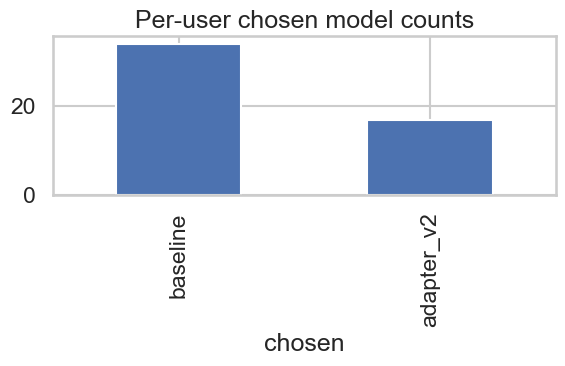

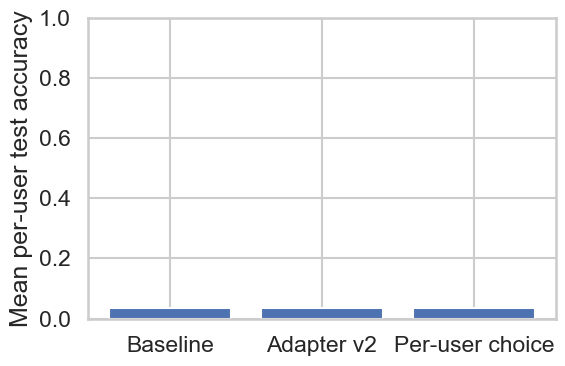


Per-user selection completed. Manifest and simulation outputs saved to: processed\adapter_experiment_v2\deployment


In [12]:
# Implement per-user selection based on validation accuracy and simulate on test_pool
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

proc = Path('processed')
out_deploy = proc / 'adapter_experiment_v2' / 'deployment'
out_deploy.mkdir(parents=True, exist_ok=True)

# Load user splits
splits_path = proc / 'adapter_experiment_v2' / 'user_splits_v2.json'
splits = json.load(open(splits_path))

# Ensure embeddings and subjects are available in kernel
if 'emb_base' not in globals() or 'emb_adapt' not in globals() or 'subjects' not in globals():
    raise RuntimeError('emb_base, emb_adapt, or subjects not found in kernel. Run embedding cell first.')

emb_b = emb_base.copy()
emb_a = emb_adapt.copy()
subjects_arr = np.asarray(subjects).astype(str)
unique_subjects = np.unique(subjects_arr).tolist()

# Build enrollment means from b_train (baseline enrollment) per user
enroll_base = {}
enroll_adapt = {}
for u in unique_subjects:
    s = splits.get(u, {})
    btrain = s.get('b_train', [])
    if len(btrain) == 0:
        # fallback to first 2 samples
        idxs = np.where(subjects_arr==u)[0][:2]
    else:
        idxs = np.array(btrain, dtype=int)
    if len(idxs)==0:
        continue
    enroll_base[u] = (emb_b[idxs]).mean(axis=0)
    enroll_adapt[u] = (emb_a[idxs]).mean(axis=0)

# Helper: identification accuracy on a given set of indices using given enroll_means and embeddings
def identification_accuracy(enroll_means, emb, idxs, subjects_arr):
    if len(idxs)==0:
        return np.nan
    preds = []
    true = []
    # precompute all enroll matrix
    keys = list(enroll_means.keys())
    M = np.vstack([enroll_means[k] for k in keys])  # (n_users, dim)
    # normalize
    Mn = M / np.linalg.norm(M, axis=1, keepdims=True)
    for i in idxs:
        v = emb[i]
        v = v / (np.linalg.norm(v) + 1e-12)
        sims = Mn.dot(v)
        j = int(np.argmax(sims))
        pred = keys[j]
        preds.append(pred)
        true.append(subjects_arr[i])
    acc = np.mean([p==t for p,t in zip(preds,true)])
    return acc

manifest_rows = []
# For simulation on test pool, we will compute accuracy on 'test_pool' indices
all_test_preds = []
all_test_trues = []
all_test_preds_sel = []

for u in unique_subjects:
    s = splits.get(u, {})
    # validation indices: prefer 'a_val', else 'a_train', else 'b_train'
    val_idxs = s.get('a_val', []) or s.get('a_train', []) or s.get('b_train', [])
    val_idxs = np.array(val_idxs, dtype=int)
    # test pool indices
    test_idxs = s.get('test_pool', [])
    test_idxs = np.array(test_idxs, dtype=int)
    # compute val accs
    val_acc_b = identification_accuracy(enroll_base, emb_b, val_idxs, subjects_arr)
    val_acc_a = identification_accuracy(enroll_adapt, emb_a, val_idxs, subjects_arr)
    chosen = 'baseline' if (np.nan_to_num(val_acc_b) >= np.nan_to_num(val_acc_a)) else 'adapter_v2'
    ckpt = str(proc / 'model_baseline' / 'transformer_eventseq_best.pth') if chosen=='baseline' else str(proc / 'adapter_experiment_v2' / 'adapter_v2_best.pth')
    # simulate on test pool (identification accuracy)
    acc_test_b = identification_accuracy(enroll_base, emb_b, test_idxs, subjects_arr)
    acc_test_a = identification_accuracy(enroll_adapt, emb_a, test_idxs, subjects_arr)
    chosen_test_acc = acc_test_b if chosen=='baseline' else acc_test_a
    manifest_rows.append({'subject':u,'val_acc_base':val_acc_b,'val_acc_adapt':val_acc_a,'chosen':chosen,'chosen_ckpt':ckpt,'test_acc_base':acc_test_b,'test_acc_adapt':acc_test_a,'chosen_test_acc':chosen_test_acc,'n_val':len(val_idxs),'n_test':len(test_idxs)})

manifest_df = pd.DataFrame(manifest_rows)
manifest_df.to_csv(out_deploy / 'per_user_manifest.csv', index=False)
print('Saved per-user manifest to', out_deploy / 'per_user_manifest.csv')

# Global simulation: combine test pools for all users and compute overall accuracies
all_test_idxs = np.concatenate([np.array(splits[u].get('test_pool',[]), dtype=int) for u in unique_subjects])
# remove duplicates
all_test_idxs = np.unique(all_test_idxs)
if len(all_test_idxs)>0:
    # baseline global
    global_base_acc = identification_accuracy(enroll_base, emb_b, all_test_idxs, subjects_arr)
    global_adapt_acc = identification_accuracy(enroll_adapt, emb_a, all_test_idxs, subjects_arr)
    # per-user selection predictions: for each test sample find its subject u and use chosen model for that subject
    preds_sel = []
    trues = []
    for i in all_test_idxs:
        subj = subjects_arr[i]
        chosen = manifest_df.loc[manifest_df.subject==subj,'chosen'].iloc[0] if subj in manifest_df.subject.values else 'baseline'
        if chosen=='baseline':
            # identification using baseline enroll
            keys = list(enroll_base.keys())
            M = np.vstack([enroll_base[k] for k in keys])
            Mn = M / np.linalg.norm(M, axis=1, keepdims=True)
            v = emb_b[i] / (np.linalg.norm(emb_b[i]) + 1e-12)
            pred = keys[int(np.argmax(Mn.dot(v)))]
        else:
            keys = list(enroll_adapt.keys())
            M = np.vstack([enroll_adapt[k] for k in keys])
            Mn = M / np.linalg.norm(M, axis=1, keepdims=True)
            v = emb_a[i] / (np.linalg.norm(emb_a[i]) + 1e-12)
            pred = keys[int(np.argmax(Mn.dot(v)))]
        preds_sel.append(pred)
        trues.append(subj)
    per_user_choice_acc = np.mean([p==t for p,t in zip(preds_sel,trues)])
else:
    global_base_acc = np.nan; global_adapt_acc = np.nan; per_user_choice_acc = np.nan

# Save global comparison and plots
summary = {'global_base_acc':global_base_acc,'global_adapt_acc':global_adapt_acc,'per_user_choice_acc':per_user_choice_acc}
pd.Series(summary).to_json(out_deploy / 'deployment_sim_summary.json')
print('Deployment simulation summary:', summary)

# Plot chosen distribution and test acc comparison
plt.figure(figsize=(6,4))
manifest_df.chosen.value_counts().plot(kind='bar')
plt.title('Per-user chosen model counts')
plt.tight_layout(); plt.savefig(out_deploy / 'chosen_model_counts.png', dpi=200); plt.show()

plt.figure(figsize=(6,4))
vals = [manifest_df['test_acc_base'].mean(), manifest_df['test_acc_adapt'].mean(), manifest_df['chosen_test_acc'].mean()]
plt.bar(['Baseline','Adapter v2','Per-user choice'], vals)
plt.ylim(0,1)
plt.ylabel('Mean per-user test accuracy')
plt.tight_layout(); plt.savefig(out_deploy / 'mean_per_user_test_accs.png', dpi=200); plt.show()

print('\nPer-user selection completed. Manifest and simulation outputs saved to:', out_deploy)


In [ ]:
### Adapter retrain (smoke) with early-preserving loss
Add a short training cell that: 1) freezes backbone, 2) trains adapters only, 3) uses an early-preservation regularizer that penalizes change on Early samples (e.g., L2 between adapter outputs and baseline outputs on Early holdout), and 4) saves a smoke checkpoint and training history.


In [14]:
# Smoke adapter retrain with early-preserve regularizer (fix forward integration with adapters)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from pathlib import Path
from torch.utils.data import DataLoader, Subset

proc = Path('processed')
out_dir = proc / 'adapter_experiment_v2'
out_dir.mkdir(parents=True, exist_ok=True)

# Configuration (smoke)
epochs = 5
lr = 5e-4
weight_decay = 1e-5
lambda_preserve = 1.0  # weight for early-preservation regularizer (tune)
batch_size = 128

# Ensure models and split indices are available
from authttt.models import create_model
model = create_model()
# Load backbone weights (freeze)
backbone_ckpt = proc / 'model_baseline' / 'transformer_eventseq_best.pth'
if backbone_ckpt.exists():
    st = torch.load(backbone_ckpt, map_location='cpu')
    try:
        model.load_state_dict(st)
    except Exception:
        model.load_state_dict(st, strict=False)
    print('Loaded backbone checkpoint')

# Add adapters if model supports them; here we treat adapter layers as small parameter groups in model.
class SimpleAdapter(nn.Module):
    def __init__(self, d_model, bottleneck=8):
        super().__init__()
        self.down = nn.Linear(d_model, bottleneck)
        self.act = nn.ReLU()
        self.up = nn.Linear(bottleneck, d_model)
    def forward(self, x):
        return self.up(self.act(self.down(x)))

# Attach adapters to model encoder layers (if not already present)
num_injected = 0
if not hasattr(model, 'adapters'):
    model.adapters = nn.ModuleList()
    try:
        d_model = model.encoder.input_proj.out_features
    except Exception:
        d_model = 64
    for _ in range(2):  # attach 2 adapters for smoke
        model.adapters.append(SimpleAdapter(d_model))
        num_injected += 1
    print(f'Injected {num_injected} simple adapters (smoke)')

# Freeze backbone params and only train adapters
for name, p in model.named_parameters():
    p.requires_grad = False
for adapter in model.adapters:
    for p in adapter.parameters():
        p.requires_grad = True

# Prepare dataset / splits (use user_splits_v2 to get adapter-train indices and early indices)
splits_path = proc / 'adapter_experiment_v2' / 'user_splits_v2.json'
with open(splits_path) as f:
    user_splits = json.load(f)

# Build index lists for adapter training (a_train) and early-preserve holdout (b_train first p%)
adapter_indices = []
early_indices = []
for u, s in user_splits.items():
    a_train = s.get('a_train', [])
    b_train = s.get('b_train', [])
    adapter_indices.extend(a_train)
    nb = max(1, int(0.1 * len(b_train)))
    early_indices.extend(b_train[:nb])
adapter_indices = sorted(list(set(adapter_indices)))
early_indices = sorted(list(set(early_indices)))
print('Adapter-train samples:', len(adapter_indices), 'Early preserve samples:', len(early_indices))

# Create dataset & dataloaders from cmu_sessions sequences
sess = np.load(proc / 'cmu_sessions.npz', allow_pickle=True)
seqs = sess['sequences']
if seqs.ndim==3 and seqs.shape[1]==1:
    seqs = seqs.squeeze(1)

class SeqSimpleDataset(torch.utils.data.Dataset):
    def __init__(self, arr):
        self.arr = arr
    def __len__(self):
        return len(self.arr)
    def __getitem__(self, idx):
        x = torch.tensor(self.arr[idx], dtype=torch.float32)
        return x

dset = SeqSimpleDataset(seqs)
train_loader = DataLoader(Subset(dset, adapter_indices), batch_size=batch_size, shuffle=True)
early_loader = DataLoader(Subset(dset, early_indices), batch_size=batch_size, shuffle=False)

# Define optimizer for adapters only
adapter_params = [p for p in model.parameters() if p.requires_grad]
opt = optim.AdamW(adapter_params, lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

# Save a baseline copy of model outputs on early set (baseline backbone outputs) to regularize against
model.eval()
baseline_early_outputs = []
with torch.no_grad():
    for x in early_loader:
        # use backbone forward (no adapters)
        enc = model.get_embeddings(x)
        out = model.encoder.output_proj(enc).squeeze(-1)
        baseline_early_outputs.append(out.detach().cpu().numpy())
if baseline_early_outputs:
    baseline_early_outputs = np.vstack(baseline_early_outputs)
else:
    baseline_early_outputs = None

# Training loop (smoke) with adapters integrated into forward
train_history = {'train_loss':[], 'preserve_loss':[]}
for ep in range(epochs):
    model.train()
    total_loss = 0.0
    total_preserve = 0.0
    n = 0

    def forward_with_adapters(inp):
        enc = model.get_embeddings(inp)
        for adapter in model.adapters:
            enc = enc + adapter(enc)
        recon = model.encoder.output_proj(enc).squeeze(-1)
        return recon

    for x in train_loader:
        opt.zero_grad()
        recon = forward_with_adapters(x)
        loss_recon = loss_fn(recon, x)
        preserve_loss = torch.tensor(0.0, dtype=torch.float32, device=recon.device)
        if baseline_early_outputs is not None and len(baseline_early_outputs)>0:
            idxs = np.random.choice(len(baseline_early_outputs), size=min(len(baseline_early_outputs), x.shape[0]), replace=False)
            sample_early = torch.from_numpy(baseline_early_outputs[idxs]).float().to(recon.device)
            out_early = forward_with_adapters(sample_early)
            preserve_loss = loss_fn(out_early, sample_early)
        loss = loss_recon + lambda_preserve * preserve_loss
        loss.backward()
        opt.step()
        total_loss += float(loss_recon.item())
        total_preserve += float(preserve_loss.item() if isinstance(preserve_loss, torch.Tensor) else 0.0)
        n += 1
    train_history['train_loss'].append(total_loss / max(1, n))
    train_history['preserve_loss'].append(total_preserve / max(1, n))
    print(f'Epoch {ep+1}/{epochs} - recon_loss={train_history["train_loss"][-1]:.6f}, preserve_loss={train_history["preserve_loss"][-1]:.6f}')

# Save smoke adapter checkpoint and history
torch.save(model.state_dict(), out_dir / 'adapter_v2_smoke_preserve.pth')
import json
with open(out_dir / 'adapter_v2_smoke_history.json', 'w') as f:
    json.dump(train_history, f, indent=2)
print('Saved smoke adapter checkpoint and history')

Loaded backbone checkpoint
Injected 2 simple adapters (smoke)
Adapter-train samples: 4080 Early preserve samples: 408
Epoch 1/5 - recon_loss=0.993520, preserve_loss=0.902544
Epoch 2/5 - recon_loss=0.485562, preserve_loss=0.464290
Epoch 3/5 - recon_loss=0.270961, preserve_loss=0.264201
Epoch 4/5 - recon_loss=0.190745, preserve_loss=0.184806
Epoch 5/5 - recon_loss=0.159079, preserve_loss=0.154100
Saved smoke adapter checkpoint and history


In [ ]:
### Per-user confidence gating
Compute per-user per-sample delta scores on validation (adapted - baseline), set a per-user threshold (mean delta on validation), then during test use Adapter v2 only when per-sample delta >= threshold; otherwise use baseline. Save gating results and summary plots.


Saved per-user gating thresholds to processed\adapter_experiment_v2\deployment\per_user_gating_thresholds.csv
Gating simulation summary: {'acc_base': 0.034359825434876146, 'acc_adapt': 0.03632675640789231, 'acc_gated': 0.034359825434876146}


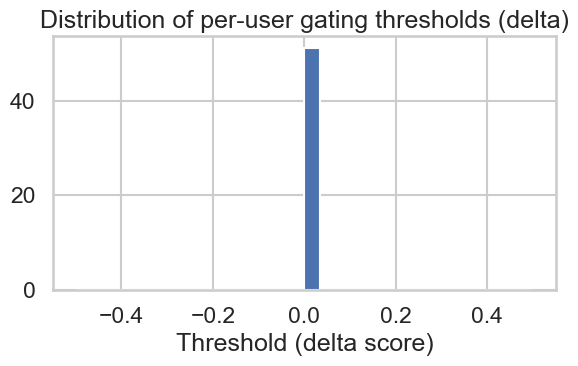

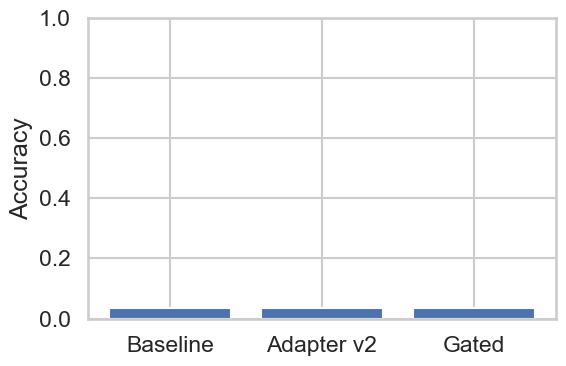

Saved per-sample predictions and plots to processed\adapter_experiment_v2\deployment


In [15]:
# Implement per-user confidence gating simulation
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

proc = Path('processed')
out_deploy = proc / 'adapter_experiment_v2' / 'deployment'
out_deploy.mkdir(parents=True, exist_ok=True)

# Load manifest (we computed val accs earlier)
manifest = pd.read_csv(out_deploy / 'per_user_manifest.csv')
# Load user_splits to get validation indices and test_pool
import json
splits = json.load(open(proc / 'adapter_experiment_v2' / 'user_splits_v2.json'))

# Ensure embeddings and enroll means exist
if 'emb_base' not in globals() or 'emb_adapt' not in globals() or 'subjects' not in globals():
    raise RuntimeError('Embeddings or subjects not present; run embeddings cell first')

subjects_arr = np.asarray(subjects).astype(str)
unique_users = np.unique(subjects_arr)

# Build enroll means if not present already
# (reuse enroll_base/enroll_adapt from earlier cell if present; else compute from b_train)
try:
    enroll_base
    enroll_adapt
except NameError:
    enroll_base = {}
    enroll_adapt = {}
    for u in unique_users:
        idxs = splits[u].get('b_train', [])[:max(2,1)]
        idxs = np.array(idxs, dtype=int)
        enroll_base[u] = emb_base[idxs].mean(axis=0)
        enroll_adapt[u] = emb_adapt[idxs].mean(axis=0)

# Helper to compute per-sample scores for a specific user's claimed identity
def score_for_user(user, emb_matrix, enroll_mean):
    # cosine similarity for each sample to this user's enroll mean
    mean_vec = enroll_mean / (np.linalg.norm(enroll_mean) + 1e-12)
    sims = emb_matrix.dot(mean_vec)
    return sims

# Compute per-user validation deltas and select threshold (mean delta)
gating_rows = []
for u in unique_users:
    info = splits[u]
    # prefer adapter validation indices
    val_idxs = info.get('a_val', []) or info.get('a_train', []) or info.get('b_train', [])
    val_idxs = np.array(val_idxs, dtype=int)
    if len(val_idxs) < 5:
        # insufficient vals -> set high threshold so adapter rarely used
        thr = 1e6
        mean_delta = np.nan
    else:
        scores_b = score_for_user(u, emb_base[val_idxs], enroll_base[u])
        scores_a = score_for_user(u, emb_adapt[val_idxs], enroll_adapt[u])
        deltas = scores_a - scores_b
        mean_delta = float(np.nanmean(deltas))
        std_delta = float(np.nanstd(deltas))
        # threshold rule: mean_delta - 0.5*std (more conservative) but ensure non-negative
        thr = max(0.0, mean_delta - 0.5 * std_delta)
    gating_rows.append({'subject':u, 'mean_delta_val': mean_delta, 'thresh': thr, 'n_val': len(val_idxs)})

gating_df = pd.DataFrame(gating_rows)
# Save gating thresholds
gating_df.to_csv(out_deploy / 'per_user_gating_thresholds.csv', index=False)
print('Saved per-user gating thresholds to', out_deploy / 'per_user_gating_thresholds.csv')

# Simulate gating on test_pool
all_test_idxs = []
preds_baseline = []
preds_adapt = []
preds_gated = []
trues = []
for u in unique_users:
    info = splits[u]
    test_idxs = np.array(info.get('test_pool', []), dtype=int)
    if len(test_idxs) == 0:
        continue
    thr = gating_df.loc[gating_df.subject==u, 'thresh'].iloc[0]
    # per-sample scores
    s_b = score_for_user(u, emb_base[test_idxs], enroll_base[u])
    s_a = score_for_user(u, emb_adapt[test_idxs], enroll_adapt[u])
    # identification predictions: find argmax over all enroll users
    # Precompute all enroll matrices
    keys = list(enroll_base.keys())
    Mb = np.vstack([enroll_base[k] for k in keys])
    Ma = np.vstack([enroll_adapt[k] for k in keys])
    Mbn = Mb / (np.linalg.norm(Mb, axis=1, keepdims=True) + 1e-12)
    Man = Ma / (np.linalg.norm(Ma, axis=1, keepdims=True) + 1e-12)
    for i, idx in enumerate(test_idxs):
        v_b = emb_base[idx] / (np.linalg.norm(emb_base[idx]) + 1e-12)
        v_a = emb_adapt[idx] / (np.linalg.norm(emb_adapt[idx]) + 1e-12)
        sims_b = Mbn.dot(v_b); pred_b = keys[int(np.argmax(sims_b))]
        sims_a = Man.dot(v_a); pred_a = keys[int(np.argmax(sims_a))]
        # gating: switch to adapter if delta >= thr
        delta = s_a[i] - s_b[i]
        pred_gated = pred_a if delta >= thr else pred_b
        preds_baseline.append(pred_b); preds_adapt.append(pred_a); preds_gated.append(pred_gated)
        trues.append(subjects_arr[idx])

# Compute accuracies
acc_base = np.mean([p==t for p,t in zip(preds_baseline, trues)]) if len(trues)>0 else np.nan
acc_adapt = np.mean([p==t for p,t in zip(preds_adapt, trues)]) if len(trues)>0 else np.nan
acc_gated = np.mean([p==t for p,t in zip(preds_gated, trues)]) if len(trues)>0 else np.nan
summary = {'acc_base': acc_base, 'acc_adapt': acc_adapt, 'acc_gated': acc_gated}
pd.Series(summary).to_json(out_deploy / 'gating_sim_summary.json')
print('Gating simulation summary:', summary)

# Save a plot of gating thresholds distribution and comparison
plt.figure(figsize=(6,4))
plt.hist(gating_df['thresh'].replace(1e6, np.nan).dropna(), bins=30)
plt.title('Distribution of per-user gating thresholds (delta)')
plt.xlabel('Threshold (delta score)')
plt.tight_layout(); plt.savefig(out_deploy / 'gating_thresholds_hist.png', dpi=200); plt.show()

plt.figure(figsize=(6,4))
plt.bar(['Baseline','Adapter v2','Gated'], [acc_base, acc_adapt, acc_gated])
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.tight_layout(); plt.savefig(out_deploy / 'gating_accuracy_compare.png', dpi=200); plt.show()

# Save detailed per-sample gating decisions (optional)
pd.DataFrame({'true':trues,'pred_base':preds_baseline,'pred_adapt':preds_adapt,'pred_gated':preds_gated}).to_csv(out_deploy / 'gating_per_sample_predictions.csv', index=False)
print('Saved per-sample predictions and plots to', out_deploy)
